# Active Learning

In this work we review and implement the probcover agorithm introduced in the paper  ["Active Learning Through a Covering Lens"](https://https://arxiv.org/pdf/2205.11320)  by Ofer Yehuda et al, on three image datasets (STL10, CIFAR10, CIFAR100). We then introduce a new method we call "Varslc" and compare the two.


Shachar Ashkenazi

## ProbCover
The purpose of active learning is to find a way of choosing the 'best' data points for the machine to learn from, i.e. choosing the most efficient learning set. We show that probcover reaches higher accuracy than random sampling, focusing on low budget (about 10 - 500 labled datapoints).

 The **ProbCover algorithm** requires $L$ - labled data (may even be an empty set), $U$ - un-labled data, $\delta$ - ball size, $b$ - budget. First the algorithm requiers a represenation (latent space) of the data from an unsupervised algorithm (here we use Simclr as the unsupervised learning algorithm), than acting in this latent space, we construct an adjacency graph $G = (V, E)$, with $V= L\cup U$, and  $(x, x') \in E$ exists if $x'\in B_\delta(x)$, where distance is calculated using the cosine distance. Initially, for every $c \in L$, the algorithm iterates and removes all incoming edges from the graph that correspond to vertices already covered by these labeled samples $\{(x,x'):x\in B_\delta(c)\}$.

After updating the graph to exclude already covered points, the algorithm selects the vertex with the highest out-degree, $m$, representing the sample that covers the largest number of remaining uncovered points. Once a node is selected, the graph is further updated by removing all incoming edges associated with the selected node and its neighbors within the radius $\delta$, marking these points as covered $\{(x,x'):x\in B_\delta(m)\}$.
this process repeats iteratively for $b$ iterations, ensuring that each selected sample contributes maximally to the overall coverage. This careful sequence---removing edges, selecting a node, and updating coverage---ensures that the algorithm avoids redundancy and efficiently maximizes the coverage of the data distribution.

After getting the "active learning set" we train a small neuaral net on it, and calculate the acuuracy.


* We used online availble [implementation of Simclr](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial17/SimCLR.ipynb#scrollTo=-mT1josKM6NC).

## Setup and imports

In [ ]:
!pip install pytorch_lightning

In [ ]:
import os
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torchvision
from torchvision.datasets import STL10
from torchvision.datasets import CIFAR10
from torchvision.datasets import CIFAR100

from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

%load_ext tensorboard
%matplotlib inline
import urllib.request
from urllib.error import HTTPError

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from scipy.sparse import csgraph, coo_matrix
from scipy.sparse.linalg import eigsh

DATASET_PATH = "../data"
CHECKPOINT_PATH = "../saved_models/tutorial17"
NUM_WORKERS = os.cpu_count()
pl.seed_everything(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

Seed set to 42


Device: cpu
Number of workers: 8


<Figure size 640x480 with 0 Axes>

Pretrain Simclr weights.

In [ ]:
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial17/"
# Files to download
pretrained_files = ["SimCLR.ckpt", "ResNet.ckpt",
                    "tensorboards/SimCLR/events.out.tfevents.SimCLR",
                    "tensorboards/classification/ResNet/events.out.tfevents.ResNet"]
pretrained_files += [f"LogisticRegression_{size}.ckpt" for size in [10, 20, 50, 100, 200, 500]]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

## SimCLR

we implement SimCLR with PyTorch Lightning, and finally train it on a large, unlabeled dataset.

### Data Augmentation for Contrastive Learning

In [ ]:
class ContrastiveTransformations(object):

    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

In [ ]:
contrast_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop(size=96),
                                          transforms.RandomApply([
                                              transforms.ColorJitter(brightness=0.5,
                                                                     contrast=0.5,
                                                                     saturation=0.5,
                                                                     hue=0.1)
                                          ], p=0.8),
                                          transforms.RandomGrayscale(p=0.2),
                                          transforms.GaussianBlur(kernel_size=9),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))
                                         ])

## Datasets

In-order to evaluate probcover, we use three different data sets:  [CIFAR10  dataset], contains 50,000  $32\times 32$ colour images of 10 classes (5000 images perclass): airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck. [STL10  dataset], Similarly to CIFAR10 it contians the same 10 classes, with 500 images per class. However, the images have a higher resolution, namely $96\times 96$ pixels, and we are only provided with 500 labeled images per class (5000 images in the training set). Lastly, we also used [CIFAR100 dataset], this dataset is just like the CIFAR-10, except it has 100 classes containing 500 images each.

### STL10

In [ ]:
img_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5,))])

In [ ]:
stl10_dataset = STL10(root=DATASET_PATH, split='train', download=True,
                       transform=img_transforms)
print("Number of training examples:", len(stl10_dataset))
stl10_dataset

Files already downloaded and verified
Number of training examples: 5000


Dataset STL10
    Number of datapoints: 5000
    Root location: ../data
    Split: train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

### CIFAR10

In [ ]:
cifar10_dataset = CIFAR10(root='./data', train=True, download=True, transform=img_transforms)
cifar10_dataset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

### CIFAR100

In [ ]:
cifar100_dataset = CIFAR100(root='./data', train=True, download=True, transform=img_transforms)
cifar100_dataset

Files already downloaded and verified


Dataset CIFAR100
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

Intialize Simclr for each dataset

In [ ]:
class SimCLR(pl.LightningModule):

    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        # Base model f(.)
        self.convnet = torchvision.models.resnet18(num_classes=4*hidden_dim)  # Output of last linear layer
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        imgs, _ = batch
        imgs = torch.cat(imgs, dim=0)

        # Encode all images
        feats = self.convnet(imgs)
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode+'_loss', nll)
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)],
                             dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode+'_acc_top1', (sim_argsort == 0).float().mean())
        self.log(mode+'_acc_top5', (sim_argsort < 5).float().mean())
        self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean())

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')

In [ ]:
def train_simclr(batch_size, max_epochs=500, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, 'SimCLR'),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc_top5'),
                                    LearningRateMonitor('epoch')])
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'SimCLR.ckpt')
    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = SimCLR.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        model = None
        # train_loader = data.DataLoader(unlabeled_data, batch_size=batch_size, shuffle=True,
        #                                drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)
        # val_loader = data.DataLoader(train_data_contrast, batch_size=batch_size, shuffle=False,
        #                              drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)
        # pl.seed_everything(42) # To be reproducable
        # model = SimCLR(max_epochs=max_epochs, **kwargs)
        # trainer.fit(model, train_loader, val_loader)
        # model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    return model

In [ ]:
simclr_model = train_simclr(batch_size=256,
                            hidden_dim=128,
                            lr=5e-4,
                            temperature=0.07,
                            weight_decay=1e-4,
                            max_epochs=500)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../saved_models/tutorial17/SimCLR.ckpt`


Found pretrained model at ../saved_models/tutorial17/SimCLR.ckpt, loading...


**Our Simclr latent space is constructed, and now we can use it to represent images!**

Next, we implement a small function to encode all images in our datasets. The output representations are then used as inputs to the NN.

In [ ]:
@torch.no_grad()
def prepare_data_features(model, dataset):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    data_loader = data.DataLoader(dataset, batch_size=64, num_workers=NUM_WORKERS, shuffle=False, drop_last=False)
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(data_loader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)

    # Sort images by labels
    labels, idxs = labels.sort()
    feats = feats[idxs]

    return data.TensorDataset(feats, labels)

Let's apply the function to out datasets

In [ ]:
stl10_features, _ = prepare_data_features(simclr_model, stl10_dataset).tensors

  0%|          | 0/79 [00:00<?, ?it/s]

In [ ]:
cifar10_features, _ = prepare_data_features(simclr_model, cifar10_dataset).tensors

  0%|          | 0/782 [00:00<?, ?it/s]

In [ ]:
cifar100_feaures, _ = prepare_data_features(simclr_model, cifar100_dataset).tensors

  0%|          | 0/782 [00:00<?, ?it/s]

## Probcover algorithm

Let's implement the probcover algorithm as formalized in the begining.


In [ ]:
class ProbCover:
    def __init__(self, lSet, uSet, budgetSize, delta, features):
        """
        Inits the ProbCover class.
        - lSet: Indices of labeled samples.
        - uSet: Indices of unlabeled samples.
        - budgetSize: Number of samples to select.
        - delta: Distance threshold.
        - features: Transformed features (e.g., PCA-reduced or SimCLR embeddings).
        """
        self.all_features = features
        self.lSet = lSet
        self.uSet = uSet
        self.budgetSize = budgetSize
        self.delta = delta
        self.relevant_indices = np.concatenate([self.lSet, self.uSet]).astype(int)
        self.rel_features = self.all_features[self.relevant_indices]
        self.graph_df = self.construct_graph()


    def construct_graph(self, batch_size=500):
        """
        Construct the graph of distances between samples based on cosine similarity and delta.
        """
        xs, ys, ds = [], [], []
        print(f'Start constructing graph using delta={self.delta} (cosine similarity)')
        cuda_feats = torch.tensor(self.rel_features)
        cuda_feats = F.normalize(cuda_feats, p=2, dim=1)

        for i in range(len(self.rel_features) // batch_size + 1):
            cur_feats = cuda_feats[i * batch_size: (i + 1) * batch_size]
            sim = torch.matmul(cur_feats, cuda_feats.T)
            mask = sim > self.delta
            x, y = mask.nonzero(as_tuple=True)
            xs.append(x + batch_size * i)
            ys.append(y)
            ds.append(sim[mask])
        xs = torch.cat(xs).numpy()
        ys = torch.cat(ys).numpy()
        ds = torch.cat(ds).numpy()
        df = pd.DataFrame({'x': xs, 'y': ys, 'd': ds})
        print(f'Finished constructing graph using delta={self.delta} (cosine similarity)')
        print(f'Graph contains {len(df)} edges.')
        return df

    def select_samples(self):
        """
        Select samples based on the ProbCover algorithm.
        """
        print(f'Start selecting {self.budgetSize} samples.')
        selected = []
        edge_from_seen = np.isin(self.graph_df.x, np.arange(len(self.lSet)))
        covered_samples = self.graph_df.y[edge_from_seen].unique()
        cur_df = self.graph_df[(~np.isin(self.graph_df.y, covered_samples))]
        for i in range(self.budgetSize):
            coverage = len(covered_samples) / len(self.relevant_indices)
            degrees = np.bincount(cur_df.x, minlength=len(self.relevant_indices))
            print(f'Iteration {i}.\tGraph edges: {len(cur_df)}.\tMax degree: {degrees.max()}.\tCoverage: {coverage:.3f}')
            cur = degrees.argmax()
            new_covered_samples = cur_df.y[cur_df.x == cur].values
            cur_df = cur_df[(~np.isin(cur_df.y, new_covered_samples))]
            covered_samples = np.concatenate([covered_samples, new_covered_samples])
            selected.append(cur)

        assert len(selected) == self.budgetSize, 'Incorrect number of samples selected'
        activeSet = self.relevant_indices[selected]
        remainSet = np.array(sorted(list(set(self.uSet) - set(activeSet))))
        print(f'Finished selecting {len(activeSet)} samples.')
        print(f'Active set: {activeSet}')
        return activeSet, remainSet

Now, we are set to run the probcover algorithm. The following function takes the image sets, transform it to the latent space and performs the probcover algorithm.

In [ ]:
def run_probcover(budget_size: int, delta: int, img_data_trained):
    n_samples = len(img_data_trained)
    lSet = np.array([])
    uSet = np.arange(n_samples)

    prob_cover = ProbCover(lSet, uSet, budget_size, delta, img_data_trained)
    graph_df = prob_cover.construct_graph()
    print("\nGraph DataFrame:")
    print(graph_df.head())

    active_set, remain_set = prob_cover.select_samples()
    return active_set, remain_set

## Var Selection Algorithm Motivation and Implemantation

The **motivation** for this algorithm can be summarized in two points:

1. A simple 1-layer neural network first learns directions in the data corresponding to principal components.  These directions are ranked by their eigenvalues (EVs)—higher eigenvalues mean more variance in that direction, so the network learns those first (higher variance means larger gradients).

2. SimCLR, projects images into a latent space where similar images are closer together. The output distribution of this latent space often resembles a mixture of Gaussians. This is expected because SimCLR tends to cluster similar instances together while pushing apart dissimilar ones.

From the first two points we can strategize: Feeding high-variance clusters (gaussians) to the model first.  High-variance directions in the data align with the leading principal components, which neural networks learn faster.


**Implemantaion:**
we divide the data into $I$ clusters, with information about the variance ($\text{Var}_i$) and number of examples in each cluster $n_i$. we then define $p_i = \frac{n_i}{N}$, where $n_i$ is the number of datapoints in cluster $i$ and $\lambda_i = \frac{\text{Var}_i}{\sum_j\text{Var}_j}$, the relative variance of cluster $i$. Assuming the budget is b, we iterate over the budget size and update the labled data point by randomly selecting a new labled point from cluster $i$ with probability $\frac{(p_i-\frac{l_i}{N})\cdot \lambda_i}{\sum_j(p_j-\frac{l_j}{N})\cdot \lambda_j}$ where $l_i$ is the number of already labled points in the cluster (either from the iteration or it was preiviously given).



In [ ]:
class Varslc:
    def __init__(self, lSet, uSet, budgetSize, features):
        self.all_features = features
        self.lSet = lSet
        self.uSet = uSet
        self.budgetSize = budgetSize
        self.relevant_indices = np.concatenate([self.lSet, self.uSet]).astype(int)
        self.rel_features = self.all_features[self.relevant_indices]

    def laplacian(self, A):
        degrees = A.sum(axis=1)
        D = np.diag(degrees)
        L = D - A
        return L

    def self_tuning_spectral_clustering(self, n_clusters, n_neighbors=10):
        group = self.all_features
        # Compute knn and distances
        nbrs = NearestNeighbors(n_neighbors=n_neighbors, n_jobs=8).fit(group)
        distances, indices = nbrs.kneighbors(group)
        sigma = distances.max(axis=1)

        # Build sparse affinity matrix using the self-tuning kernel
        rows, cols, vals = [], [], []
        n_samples = group.shape[0]
        for i in range(n_samples):#iterate over each sample and its neighbors O(n_Samples*n_neighbors)
            for j_idx, j in enumerate(indices[i]):
                if i == j:
                    continue
                d = distances[i, j_idx]
                affinity = np.exp(-d / (2 * sigma[i] * sigma[j] + 1e-8))
                rows.append(i)
                cols.append(j)
                vals.append(affinity)
        W = coo_matrix((vals, (rows, cols)), shape=(n_samples, n_samples))
        W = (W + W.T) / 2

        L = csgraph.laplacian(W, normed=False)
        # Compute the smallest n_clusters eigenvectors
        eigenvalues, eigenvectors = eigsh(L, k=n_clusters, which='SM')
        U = normalize(eigenvectors, norm='l2', axis=1)

        # cluster the rows
        kmeans_res = KMeans(n_clusters=n_clusters).fit_predict(U)
        unique, counts = np.unique(kmeans_res, return_counts=True)
        return kmeans_res, dict(zip(unique, counts))

    def get_active_set(self, budget_size, normzlized_dataset, n_clusters):
        n_samples = len(normzlized_dataset)
        clusters, n_cluster = self.self_tuning_spectral_clustering(n_clusters=n_clusters)
        clusters_cnt = list(n_cluster.values())
        var_cluster = np.array([np.var(normzlized_dataset[clusters == i].numpy()) for i in range(len(clusters_cnt))])
        active_set = []
        for i in range(budget_size):
            p = np.array(clusters_cnt)/n_samples
            Lambda = var_cluster/np.sum(var_cluster)
            prob_cluster = p*Lambda/(p*Lambda).sum()
            cluster_index = np.random.choice(np.arange(len(prob_cluster)), p=prob_cluster)
            rnd = np.random.choice(list(set(np.where(clusters == cluster_index)[0])-set(active_set)))
            active_set.append(rnd)
            clusters_cnt[cluster_index] -= 1

        remain_set = np.array(sorted(list(set(self.uSet) - set(active_set))))
        return active_set, remain_set

In [ ]:
def run_Varslc(budget_size: int, normalized_dataset, n_clusters: int):
    n_samples = len(normalized_dataset)
    lSet = np.array([]) #emptly label set
    uSet = np.arange(n_samples)
    varslc = Varslc(lSet, uSet, budget_size, normalized_dataset)
    active_set, remain_set = varslc.get_active_set(budget_size, normalized_dataset, n_clusters = n_clusters)
    return np.array(active_set), np.array(remain_set)

## Define a simple NN

For our NN, we would like to get x_train, x_test, y_train, y_test.
The labels on each class are changing every divide_factor. So, in order to get the labels for y_train. y_Test, we simply divide the indexes by the divide_factor.

In [ ]:
def get_x_y(indexes, remained_indexes, img_data_trained, divide_factor):
  """
  returns x,y as tensors for training/testing
  """
  x_train = img_data_trained[indexes]
  y_train = indexes//divide_factor

  x_test = img_data_trained[remained_indexes]
  y_test = remained_indexes//divide_factor

  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)

  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
  y_test_tensor = torch.tensor(y_test, dtype=torch.long)

  return x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor


A simple 3 layer NN implementation.

In [ ]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

def train_model(x_train_tensor, y_train_tensor, num_classes, num_epochs=10, batch_size=32,learning_rate=0.001):
    dataset = TensorDataset(x_train_tensor, y_train_tensor)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    input_size = x_train_tensor.shape[1]
    model = FeedforwardNN(input_size, num_classes)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

    return model


In [ ]:
def evaluate_model(model, x_test_tensor, y_test_tensor, batch_size=32):
  test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
      for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  print(f"Accuracy: {accuracy:.2f}%")
  return accuracy

## Run probcover for the three datasets.

In [ ]:
def plot_accuracy(df: pd.DataFrame, dataset_name: str):
  df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
  plt.figure(figsize=(10, 8))
  plt.plot(df['budget'], df['acc_prob'], label='Accuracy ProbCover', marker='o')
  plt.plot(df['budget'], df['acc_rand'], label='Accuracy Random', marker='o')
  plt.plot(df['budget'], df['acc_varslc'], label='Accuracy Varslc', marker='s')
  plt.xlabel('Budget Size', fontsize=12)
  plt.ylabel('Accuracy', fontsize=12)
  plt.xticks(ticks=df['budget'], labels=df['budget'].astype(str), fontsize=10, rotation = 90)
  plt.title(f'ProbCover, Varslc and random selection accuracies \n Dataset: {dataset_name}', fontsize=14)
  plt.legend(fontsize=12)
  plt.grid(True)
  plt.show()

We compare the performence of the probCover algorithm with random sampling.

In [ ]:
def train_on_active_set(active_set, remain_set, img_data_trained, divide_factor, num_classes):
    """
    Trains the network on the images from the active set
    """
    x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor = get_x_y(active_set, remain_set, img_data_trained, divide_factor=divide_factor)
    trained_model = train_model(x_train_tensor, y_train_tensor, num_classes=num_classes)
    model_accuracy = evaluate_model(trained_model, x_test_tensor, y_test_tensor)
    return trained_model, model_accuracy


### Select the optimal delta for the probCover algorithm

From experiments we made, we found out that the best delta is between 0.6 and 0.8. We will find the best delta and compare the probcover algorithm with the optimal delta to the var selection algorithm

In [ ]:
def compare_probcover_alg(budget_sizes: np.ndarray, delta: float, divide_factor: float, num_classes: int, dataset_features, n_clusters: int = None, run_varslc: bool = False):
    """
    Compares probcover and random selection, with an option to disable varslc.
    n_clusters is none where run_varslc is false
    """
    results = pd.DataFrame(columns=["budget", "delta", "acc_prob", "acc_rand", "acc_varslc", "probcover_active_set", "random_set", "varslc_active_set"])

    prob_active_sets, prob_remain_sets = run_probcover(max(budget_sizes), delta, dataset_features)

    if run_varslc:
        var_active_sets, var_remain_sets = run_Varslc(max(budget_sizes), dataset_features, n_clusters=n_clusters)
    all_random_indices = np.random.choice(a=dataset_features.shape[0], size=max(budget_sizes), replace=False)

    for budget in budget_sizes:
        # Eval prob cover
        prob_active_set = prob_active_sets[:budget]
        prob_remain_set = np.concatenate([prob_remain_sets, prob_active_sets[budget:]])
        trained_model_prob, accuracy_prob = train_on_active_set(active_set=prob_active_set, remain_set=prob_remain_set, img_data_trained=dataset_features, divide_factor=divide_factor, num_classes=num_classes)

        # Eval rand module
        random_indices = all_random_indices[:budget]
        left_indices = np.array(list(set(range(dataset_features.shape[0])) - set(random_indices)))
        trained_model_rand, accuracy_rand = train_on_active_set(active_set=random_indices, remain_set=left_indices, img_data_trained=dataset_features, divide_factor=divide_factor, num_classes=num_classes)

        row_data = {
            "budget": budget,
            "delta": delta,
            "acc_prob": accuracy_prob,
            "acc_rand": accuracy_rand,
            "probcover_active_set": prob_active_set,
            "random_set": random_indices
        }
        row_data["acc_varslc"] = None
        row_data["varslc_active_set"] = None

        if run_varslc:
            varslc_active = var_active_sets[:budget]
            var_slc_remain = np.concatenate([var_remain_sets, varslc_active[budget:]])
            trained_model_varslc, accuracy_varslc = train_on_active_set(active_set=varslc_active, remain_set=var_slc_remain, img_data_trained=dataset_features, divide_factor=divide_factor, num_classes=num_classes)
            row_data["acc_varslc"] = accuracy_varslc
            row_data["varslc_active_set"] = varslc_active
        row_df = pd.DataFrame([row_data])
        results = pd.concat([results, row_df], ignore_index=True)

    return results


Now, we would like to select the optimal delta for each dataset. For reading convenience, we commented the code that does it, but below, you can see the optimal delta value for each dataset.
We select the delta value for which the accuracy for the ProbCover algorithm (acc_prob) is at least 10% higher than the accuracy in random selection (acc_rand) and that maximizes the difference between them.

In [ ]:
deltas = np.arange(0.6, 0.95, 0.05)
budget_sizes = np.arange(10, 510, 10)
STL10_DIVIDE_FACTOR = 500
CIFAR10_DIVIDE_FACTOR = 5000
CIFAR100_DIVIDE_FACTOR = 500
STL10_NUM_CLASSES = 10
CIFAR10_NUM_CLASSES = 10
CIFAR100_NUM_CLASSES = 100

# stl10_delta_results = pd.DataFrame()
# cifar10_delta_results = pd.DataFrame()
# cifar100_delta_results = pd.DataFrame()

# for delta in deltas:
#     stl10_df = compare_probcover_alg(budget_sizes=budget_sizes, delta=delta, divide_factor=STL10_DIVIDE_FACTOR, num_classes=STL10_NUM_CLASSES, dataset_features=stl10_features)
#     cifar10_df = compare_probcover_alg(budget_sizes=budget_sizes, delta=delta, divide_factor=CIFAR10_DIVIDE_FACTOR, num_classes=CIFAR10_NUM_CLASSES, dataset_features=cifar10_features)
#     cifar100_df = compare_probcover_alg(budget_sizes=budget_sizes, delta=delta, divide_factor=CIFAR100_DIVIDE_FACTOR, num_classes=CIFAR100_NUM_CLASSES, dataset_features=cifar100_feaures)
#     stl10_delta_results = pd.concat([stl10_delta_results, stl10_df], ignore_index=True)
#     cifar10_delta_results = pd.concat([cifar10_delta_results, cifar10_df], ignore_index=True)
#     cifar100_delta_results = pd.concat([cifar100_delta_results, cifar100_df], ignore_index=True)


In [ ]:
def select_optimal_delta(df):
    significance_threshold = 0.10
    df["acc_diff"] = df["acc_prob"] - df["acc_rand"]
    df_filtered = df[df["acc_prob"] > df["acc_rand"] * (1 + significance_threshold)]
    optimal_row = df_filtered.loc[df_filtered["acc_diff"].idxmax()]
    optimal_delta = optimal_row["delta"]
    print(f"Optimal delta: {optimal_delta}")

In [ ]:
# select_optimal_delta(stl10_delta_results)

Optimal delta: 0.7000000000000001


We can see that for stl10, the optimal value for delta is 0.7

In [ ]:
# select_optimal_delta(cifar10_delta_results)

Optimal delta: 0.8500000000000002


In [ ]:
# select_optimal_delta(cifar100_delta_results)

Optimal delta: 0.7500000000000001


For each dataset, we will delect the optimal $\delta$ for it

In [ ]:
stl10_optimal_delta = 0.7
cifar10_optimal_delta = 0.85
cifar100_optimal_delta = 0.75

### STL10

In the above plot, The x-axis is the budget size - the size of the learning set. The y-axis is the prediction accuracy of the test set. We compare the probCover algorithm with random selection. In the probCover algorithm, we might get imbalanced training set, however, as shown above, it stills performs better then random selection for very low budget. In particular, it performs better up to 80 labeled data points. This is what we expected from the article.

In [ ]:
final_results_stl10 = compare_probcover_alg(budget_sizes=np.arange(10, 510, 10), delta=stl10_optimal_delta, divide_factor=STL10_DIVIDE_FACTOR, num_classes=STL10_NUM_CLASSES, dataset_features=stl10_features, n_clusters=150, run_varslc=True)

Start constructing graph using delta=0.7 (cosine similarity)
Finished constructing graph using delta=0.7 (cosine similarity)
Graph contains 1012826 edges.
Start constructing graph using delta=0.7 (cosine similarity)


/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/2282487937.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cuda_feats = torch.tensor(self.rel_features)


Finished constructing graph using delta=0.7 (cosine similarity)
Graph contains 1012826 edges.

Graph DataFrame:
   x   y         d
0  0   0  1.000000
1  0   7  0.718027
2  0  16  0.728481
3  0  18  0.716898
4  0  21  0.706861
Start selecting 500 samples.
Iteration 0.	Graph edges: 1012826.	Max degree: 930.	Coverage: 0.000
Iteration 1.	Graph edges: 586524.	Max degree: 536.	Coverage: 0.186
Iteration 2.	Graph edges: 475670.	Max degree: 358.	Coverage: 0.293
Iteration 3.	Graph edges: 400344.	Max degree: 270.	Coverage: 0.365
Iteration 4.	Graph edges: 339291.	Max degree: 265.	Coverage: 0.419
Iteration 5.	Graph edges: 303477.	Max degree: 261.	Coverage: 0.472
Iteration 6.	Graph edges: 258587.	Max degree: 229.	Coverage: 0.524
Iteration 7.	Graph edges: 227631.	Max degree: 188.	Coverage: 0.570
Iteration 8.	Graph edges: 172213.	Max degree: 146.	Coverage: 0.607
Iteration 9.	Graph edges: 152245.	Max degree: 119.	Coverage: 0.637
Iteration 10.	Graph edges: 140381.	Max degree: 114.	Coverage: 0.660
Iterat

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 1/10, Loss: 2.3215694427490234
Epoch 2/10, Loss: 2.1410558223724365
Epoch 3/10, Loss: 1.9976524114608765
Epoch 4/10, Loss: 1.8463691473007202
Epoch 5/10, Loss: 1.6800386905670166
Epoch 6/10, Loss: 1.500859022140503
Epoch 7/10, Loss: 1.3133089542388916
Epoch 8/10, Loss: 1.1211403608322144
Epoch 9/10, Loss: 0.9356458783149719
Epoch 10/10, Loss: 0.7573317289352417
Accuracy: 33.78%
Epoch 1/10, Loss: 2.226691722869873
Epoch 2/10, Loss: 1.8634799718856812
Epoch 3/10, Loss: 1.5531370639801025
Epoch 4/10, Loss: 1.3068921566009521
Epoch 5/10, Loss: 1.1490235328674316
Epoch 6/10, Loss: 1.0090277194976807
Epoch 7/10, Loss: 0.8492441177368164
Epoch 8/10, Loss: 0.7004475593566895
Epoch 9/10, Loss: 0.590391218662262
Epoch 10/10, Loss: 0.49117642641067505
Accuracy: 15.91%
Epoch 1/10, Loss: 2.280034065246582
Epoch 2/10, Loss: 2.038573980331421
Epoch 3/10, Loss: 1.8235191106796265
Epoch 4/10, Loss: 1.589176893234253
Epoch 5/10, Loss: 1.337064266204834
Epoch 6/10, Loss: 1.0902854204177856
Epoch 7/

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/4218523931.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, row_df], ignore_index=True)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires

Accuracy: 30.56%
Epoch 1/10, Loss: 2.2635574340820312
Epoch 2/10, Loss: 2.0620741844177246
Epoch 3/10, Loss: 1.8761208057403564
Epoch 4/10, Loss: 1.6787879467010498
Epoch 5/10, Loss: 1.486383318901062
Epoch 6/10, Loss: 1.3058743476867676
Epoch 7/10, Loss: 1.1288203001022339
Epoch 8/10, Loss: 0.9521562457084656
Epoch 9/10, Loss: 0.7805860042572021
Epoch 10/10, Loss: 0.6250817179679871
Accuracy: 35.89%
Epoch 1/10, Loss: 2.305091619491577
Epoch 2/10, Loss: 2.1424672603607178
Epoch 3/10, Loss: 2.005711793899536
Epoch 4/10, Loss: 1.875627875328064
Epoch 5/10, Loss: 1.7502198219299316
Epoch 6/10, Loss: 1.6128630638122559
Epoch 7/10, Loss: 1.4666959047317505
Epoch 8/10, Loss: 1.320382833480835
Epoch 9/10, Loss: 1.1740292310714722
Epoch 10/10, Loss: 1.029801845550537
Accuracy: 41.60%
Epoch 1/10, Loss: 2.319732904434204
Epoch 2/10, Loss: 2.1723790168762207
Epoch 3/10, Loss: 2.0438928604125977
Epoch 4/10, Loss: 1.9079140424728394
Epoch 5/10, Loss: 1.7663493156433105
Epoch 6/10, Loss: 1.618991136

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 10/10, Loss: 0.9811485409736633
Accuracy: 34.53%
Epoch 1/10, Loss: 2.317317485809326
Epoch 2/10, Loss: 2.1622705459594727
Epoch 3/10, Loss: 2.0338547229766846
Epoch 4/10, Loss: 1.8918476104736328
Epoch 5/10, Loss: 1.7375507354736328
Epoch 6/10, Loss: 1.5770111083984375
Epoch 7/10, Loss: 1.4143933057785034
Epoch 8/10, Loss: 1.2552975416183472
Epoch 9/10, Loss: 1.1038674116134644
Epoch 10/10, Loss: 0.9598492980003357
Accuracy: 34.02%
Epoch 1/10, Loss: 2.304502844810486
Epoch 2/10, Loss: 2.074317991733551
Epoch 3/10, Loss: 1.9395514726638794
Epoch 4/10, Loss: 1.6399706602096558
Epoch 5/10, Loss: 1.6309494972229004
Epoch 6/10, Loss: 1.4464764595031738
Epoch 7/10, Loss: 1.2300791144371033
Epoch 8/10, Loss: 1.0020774602890015
Epoch 9/10, Loss: 0.8481152355670929
Epoch 10/10, Loss: 0.924927830696106


/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 46.82%
Epoch 1/10, Loss: 2.289080858230591
Epoch 2/10, Loss: 2.1126317977905273
Epoch 3/10, Loss: 1.9462110996246338
Epoch 4/10, Loss: 1.7991538643836975
Epoch 5/10, Loss: 1.6271668672561646
Epoch 6/10, Loss: 1.3837876915931702
Epoch 7/10, Loss: 1.1817805171012878
Epoch 8/10, Loss: 1.0805301666259766
Epoch 9/10, Loss: 0.8642621338367462
Epoch 10/10, Loss: 0.7042449414730072
Accuracy: 43.00%
Epoch 1/10, Loss: 2.3018243312835693
Epoch 2/10, Loss: 2.110761284828186
Epoch 3/10, Loss: 2.021387279033661
Epoch 4/10, Loss: 1.7718766927719116
Epoch 5/10, Loss: 1.5756982564926147
Epoch 6/10, Loss: 1.4097376465797424
Epoch 7/10, Loss: 1.229164719581604
Epoch 8/10, Loss: 0.9581003487110138
Epoch 9/10, Loss: 0.9048051536083221
Epoch 10/10, Loss: 0.8017300367355347
Accuracy: 39.47%
Epoch 1/10, Loss: 2.2700159549713135
Epoch 2/10, Loss: 2.0763756036758423
Epoch 3/10, Loss: 1.8892831802368164
Epoch 4/10, Loss: 1.7254553437232971
Epoch 5/10, Loss: 1.5043174028396606
Epoch 6/10, Loss: 1.362423

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 7/10, Loss: 1.1893703937530518
Epoch 8/10, Loss: 1.0723509192466736
Epoch 9/10, Loss: 0.9096773862838745
Epoch 10/10, Loss: 0.7636964023113251
Accuracy: 43.87%
Epoch 1/10, Loss: 2.3207192420959473
Epoch 2/10, Loss: 2.119506001472473
Epoch 3/10, Loss: 1.9900763034820557
Epoch 4/10, Loss: 1.807596743106842
Epoch 5/10, Loss: 1.5963887572288513
Epoch 6/10, Loss: 1.420199990272522
Epoch 7/10, Loss: 1.181481659412384
Epoch 8/10, Loss: 0.9810459315776825
Epoch 9/10, Loss: 0.7859885394573212
Epoch 10/10, Loss: 0.6627297699451447
Accuracy: 45.45%
Epoch 1/10, Loss: 2.265554428100586
Epoch 2/10, Loss: 2.045087993144989
Epoch 3/10, Loss: 1.895283043384552
Epoch 4/10, Loss: 1.6671542525291443
Epoch 5/10, Loss: 1.4048123955726624
Epoch 6/10, Loss: 1.2268229126930237
Epoch 7/10, Loss: 0.9774253666400909
Epoch 8/10, Loss: 0.83072829246521
Epoch 9/10, Loss: 0.6463508307933807
Epoch 10/10, Loss: 0.48815807700157166
Accuracy: 48.80%
Epoch 1/10, Loss: 2.286093831062317
Epoch 2/10, Loss: 2.0642225146

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 45.00%
Epoch 1/10, Loss: 2.29292893409729
Epoch 2/10, Loss: 2.1212050914764404
Epoch 3/10, Loss: 1.938538134098053
Epoch 4/10, Loss: 1.7444750666618347
Epoch 5/10, Loss: 1.5076528787612915
Epoch 6/10, Loss: 1.299326241016388
Epoch 7/10, Loss: 1.1101054549217224
Epoch 8/10, Loss: 0.9087938368320465
Epoch 9/10, Loss: 0.7338114678859711
Epoch 10/10, Loss: 0.589397132396698
Accuracy: 49.98%
Epoch 1/10, Loss: 2.2461041609446206
Epoch 2/10, Loss: 1.9594699144363403
Epoch 3/10, Loss: 1.709887703259786
Epoch 4/10, Loss: 1.7953908840815227
Epoch 5/10, Loss: 1.443297545115153
Epoch 6/10, Loss: 1.3094380696614583
Epoch 7/10, Loss: 1.0034517447153728
Epoch 8/10, Loss: 1.0615210334459941
Epoch 9/10, Loss: 0.9497961004575094
Epoch 10/10, Loss: 0.7342466513315836
Accuracy: 52.32%


/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 1/10, Loss: 2.2692639032999673
Epoch 2/10, Loss: 2.041011174519857
Epoch 3/10, Loss: 1.8112756411234539
Epoch 4/10, Loss: 1.867379903793335
Epoch 5/10, Loss: 1.5128816763559978
Epoch 6/10, Loss: 1.3727266391118367
Epoch 7/10, Loss: 1.1287374099095662
Epoch 8/10, Loss: 0.8117715716362
Epoch 9/10, Loss: 0.9225465655326843
Epoch 10/10, Loss: 0.6458057562510172
Accuracy: 41.70%
Epoch 1/10, Loss: 2.2536683082580566
Epoch 2/10, Loss: 2.0192426443099976
Epoch 3/10, Loss: 1.8334942658742268
Epoch 4/10, Loss: 1.6445447603861492
Epoch 5/10, Loss: 1.4872265259424846
Epoch 6/10, Loss: 1.2456196149190266
Epoch 7/10, Loss: 1.060947557290395
Epoch 8/10, Loss: 0.9416336615880331
Epoch 9/10, Loss: 0.7006432414054871
Epoch 10/10, Loss: 0.5187921822071075
Accuracy: 45.76%
Epoch 1/10, Loss: 2.2607456048329673
Epoch 2/10, Loss: 1.9919263124465942
Epoch 3/10, Loss: 1.8786738713582356
Epoch 4/10, Loss: 1.6551478306452434
Epoch 5/10, Loss: 1.476044774055481
Epoch 6/10, Loss: 1.2442030906677246
Epoch 7/1

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 52.10%
Epoch 1/10, Loss: 2.273219188054403
Epoch 2/10, Loss: 2.011492451032003
Epoch 3/10, Loss: 1.7844423453013103
Epoch 4/10, Loss: 1.5499443610509236
Epoch 5/10, Loss: 1.265524427096049
Epoch 6/10, Loss: 1.07060972849528
Epoch 7/10, Loss: 0.8605904976526896
Epoch 8/10, Loss: 0.7427215377489725
Epoch 9/10, Loss: 0.5724841157595316
Epoch 10/10, Loss: 0.4634134769439697
Accuracy: 51.65%
Epoch 1/10, Loss: 2.2862181663513184
Epoch 2/10, Loss: 2.0437201658884683
Epoch 3/10, Loss: 1.7676083246866863
Epoch 4/10, Loss: 1.4861161708831787
Epoch 5/10, Loss: 1.1830005248387654
Epoch 6/10, Loss: 1.0215103030204773
Epoch 7/10, Loss: 0.8078033725420634
Epoch 8/10, Loss: 0.6610743800799052
Epoch 9/10, Loss: 0.5464914441108704
Epoch 10/10, Loss: 0.38339580098787945
Accuracy: 58.69%
Epoch 1/10, Loss: 2.268444856007894
Epoch 2/10, Loss: 2.048452615737915
Epoch 3/10, Loss: 1.8427854379018147
Epoch 4/10, Loss: 1.6694138447443645
Epoch 5/10, Loss: 1.4599705934524536
Epoch 6/10, Loss: 1.25521429

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 54.24%
Epoch 1/10, Loss: 2.290160894393921
Epoch 2/10, Loss: 2.056591192881266
Epoch 3/10, Loss: 1.8123863538106282
Epoch 4/10, Loss: 1.538852572441101
Epoch 5/10, Loss: 1.252745509147644
Epoch 6/10, Loss: 1.0139492551485698
Epoch 7/10, Loss: 0.833114226659139
Epoch 8/10, Loss: 0.6322665810585022
Epoch 9/10, Loss: 0.5046393672625223
Epoch 10/10, Loss: 0.4195806086063385
Accuracy: 60.96%
Epoch 1/10, Loss: 2.1882033944129944
Epoch 2/10, Loss: 1.8823343813419342
Epoch 3/10, Loss: 1.7965853810310364
Epoch 4/10, Loss: 1.5556043982505798
Epoch 5/10, Loss: 1.4703322350978851
Epoch 6/10, Loss: 1.3213835060596466
Epoch 7/10, Loss: 1.166108101606369
Epoch 8/10, Loss: 0.916403204202652
Epoch 9/10, Loss: 0.8668018579483032
Epoch 10/10, Loss: 0.7623057216405869


/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 47.82%
Epoch 1/10, Loss: 2.2745020389556885
Epoch 2/10, Loss: 2.003698945045471
Epoch 3/10, Loss: 1.7810330390930176
Epoch 4/10, Loss: 1.6092048585414886
Epoch 5/10, Loss: 1.2693864107131958
Epoch 6/10, Loss: 1.1440028250217438
Epoch 7/10, Loss: 0.8333515375852585
Epoch 8/10, Loss: 0.7237167358398438
Epoch 9/10, Loss: 0.790515698492527
Epoch 10/10, Loss: 0.583880715072155
Accuracy: 52.63%
Epoch 1/10, Loss: 2.235915184020996
Epoch 2/10, Loss: 1.9976015090942383
Epoch 3/10, Loss: 1.6158612668514252
Epoch 4/10, Loss: 1.4452001452445984
Epoch 5/10, Loss: 1.1847122609615326
Epoch 6/10, Loss: 1.0506787598133087
Epoch 7/10, Loss: 0.8004054129123688
Epoch 8/10, Loss: 0.6665137708187103
Epoch 9/10, Loss: 0.5773074328899384
Epoch 10/10, Loss: 0.46549008786678314
Accuracy: 59.18%
Epoch 1/10, Loss: 2.233549654483795
Epoch 2/10, Loss: 1.9362893104553223
Epoch 3/10, Loss: 1.7494580447673798
Epoch 4/10, Loss: 1.5638172328472137
Epoch 5/10, Loss: 1.3417536914348602
Epoch 6/10, Loss: 1.167426

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 7/10, Loss: 0.77958744764328
Epoch 8/10, Loss: 0.5992964431643486
Epoch 9/10, Loss: 0.5434665158390999
Epoch 10/10, Loss: 0.3718889355659485
Accuracy: 55.03%
Epoch 1/10, Loss: 2.238733470439911
Epoch 2/10, Loss: 1.9674286246299744
Epoch 3/10, Loss: 1.6436897218227386
Epoch 4/10, Loss: 1.3660021126270294
Epoch 5/10, Loss: 1.0670949071645737
Epoch 6/10, Loss: 0.8376147150993347
Epoch 7/10, Loss: 0.6762955188751221
Epoch 8/10, Loss: 0.5396535992622375
Epoch 9/10, Loss: 0.4256095439195633
Epoch 10/10, Loss: 0.32800520583987236
Accuracy: 63.64%
Epoch 1/10, Loss: 2.231388807296753
Epoch 2/10, Loss: 1.929538071155548
Epoch 3/10, Loss: 1.6592160761356354
Epoch 4/10, Loss: 1.436255395412445
Epoch 5/10, Loss: 1.1873838305473328
Epoch 6/10, Loss: 1.0024110972881317
Epoch 7/10, Loss: 0.8142356723546982
Epoch 8/10, Loss: 0.6520253270864487
Epoch 9/10, Loss: 0.5600069910287857
Epoch 10/10, Loss: 0.44254596531391144


/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 61.60%
Epoch 1/10, Loss: 2.28159362077713
Epoch 2/10, Loss: 2.019075870513916
Epoch 3/10, Loss: 1.7356867790222168
Epoch 4/10, Loss: 1.4240776300430298
Epoch 5/10, Loss: 1.1435593366622925
Epoch 6/10, Loss: 0.8499495536088943
Epoch 7/10, Loss: 0.655193492770195
Epoch 8/10, Loss: 0.5212672650814056
Epoch 9/10, Loss: 0.45218080282211304
Epoch 10/10, Loss: 0.31670307368040085
Accuracy: 54.92%
Epoch 1/10, Loss: 2.2520252466201782
Epoch 2/10, Loss: 1.9772407114505768
Epoch 3/10, Loss: 1.6688120067119598
Epoch 4/10, Loss: 1.3390542268753052
Epoch 5/10, Loss: 1.0740472078323364
Epoch 6/10, Loss: 0.8234388083219528
Epoch 7/10, Loss: 0.6524013429880142
Epoch 8/10, Loss: 0.5126397088170052
Epoch 9/10, Loss: 0.4027062952518463
Epoch 10/10, Loss: 0.31025661528110504
Accuracy: 63.38%
Epoch 1/10, Loss: 2.1761563777923585
Epoch 2/10, Loss: 1.933035635948181
Epoch 3/10, Loss: 1.6650636911392211
Epoch 4/10, Loss: 1.4240351915359497
Epoch 5/10, Loss: 1.1017010271549226


/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 6/10, Loss: 1.2316473960876464
Epoch 7/10, Loss: 0.9993736863136291
Epoch 8/10, Loss: 1.0045164704322815
Epoch 9/10, Loss: 0.6838924050331116
Epoch 10/10, Loss: 0.7527811706066132
Accuracy: 56.35%
Epoch 1/10, Loss: 2.193319892883301
Epoch 2/10, Loss: 1.896128487586975
Epoch 3/10, Loss: 1.6329134941101073
Epoch 4/10, Loss: 1.2873567819595337
Epoch 5/10, Loss: 1.186362385749817
Epoch 6/10, Loss: 1.0768629431724548
Epoch 7/10, Loss: 1.0427239537239075
Epoch 8/10, Loss: 0.6984955161809921
Epoch 9/10, Loss: 0.7507319450378418
Epoch 10/10, Loss: 0.687774932384491
Accuracy: 51.19%
Epoch 1/10, Loss: 2.3009774684906006
Epoch 2/10, Loss: 2.0080765008926393
Epoch 3/10, Loss: 1.7385323762893676
Epoch 4/10, Loss: 1.4394450664520264
Epoch 5/10, Loss: 1.2973244905471801
Epoch 6/10, Loss: 0.92442547082901
Epoch 7/10, Loss: 0.8498672366142273
Epoch 8/10, Loss: 0.7967689275741577
Epoch 9/10, Loss: 0.5932080030441285
Epoch 10/10, Loss: 0.5169803261756897
Accuracy: 61.82%
Epoch 1/10, Loss: 2.2169506

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 57.52%
Epoch 1/10, Loss: 2.2440980434417725
Epoch 2/10, Loss: 1.961539340019226
Epoch 3/10, Loss: 1.637774109840393
Epoch 4/10, Loss: 1.3204028129577636
Epoch 5/10, Loss: 1.039767038822174
Epoch 6/10, Loss: 0.8048862457275391
Epoch 7/10, Loss: 0.5904289901256561
Epoch 8/10, Loss: 0.5187024712562561
Epoch 9/10, Loss: 0.4023358166217804
Epoch 10/10, Loss: 0.31923296451568606
Accuracy: 58.42%
Epoch 1/10, Loss: 2.1583215475082396
Epoch 2/10, Loss: 1.8267808198928832
Epoch 3/10, Loss: 1.4015549421310425
Epoch 4/10, Loss: 1.0496779084205627
Epoch 5/10, Loss: 0.8038754224777221
Epoch 6/10, Loss: 0.6399488091468811
Epoch 7/10, Loss: 0.5132814466953277
Epoch 8/10, Loss: 0.37388025522232055
Epoch 9/10, Loss: 0.30016944706439974
Epoch 10/10, Loss: 0.23005925714969636
Accuracy: 63.56%
Epoch 1/10, Loss: 2.2366824626922606
Epoch 2/10, Loss: 1.9450144529342652
Epoch 3/10, Loss: 1.6939764022827148
Epoch 4/10, Loss: 1.4258676528930665
Epoch 5/10, Loss: 1.1926157474517822
Epoch 6/10, Loss: 0.9

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 8/10, Loss: 0.5011710464954376
Epoch 9/10, Loss: 0.3945862829685211
Epoch 10/10, Loss: 0.3356173634529114
Accuracy: 60.06%
Epoch 1/10, Loss: 2.2083531856536864
Epoch 2/10, Loss: 1.8740628957748413
Epoch 3/10, Loss: 1.50906822681427
Epoch 4/10, Loss: 1.1682682275772094
Epoch 5/10, Loss: 0.8888408303260803
Epoch 6/10, Loss: 0.7095008134841919
Epoch 7/10, Loss: 0.5577497780323029
Epoch 8/10, Loss: 0.4077391862869263
Epoch 9/10, Loss: 0.34018447399139407
Epoch 10/10, Loss: 0.26109701693058013
Accuracy: 65.69%
Epoch 1/10, Loss: 2.1370076179504394
Epoch 2/10, Loss: 1.8434237480163573
Epoch 3/10, Loss: 1.5705475568771363
Epoch 4/10, Loss: 1.3015028476715087
Epoch 5/10, Loss: 1.118902611732483
Epoch 6/10, Loss: 0.9072669625282288
Epoch 7/10, Loss: 0.728624677658081
Epoch 8/10, Loss: 0.6090414166450501
Epoch 9/10, Loss: 0.4972773015499115
Epoch 10/10, Loss: 0.389895361661911


/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 62.44%
Epoch 1/10, Loss: 2.2496714115142824
Epoch 2/10, Loss: 1.931193470954895
Epoch 3/10, Loss: 1.6088064670562745
Epoch 4/10, Loss: 1.3164557218551636
Epoch 5/10, Loss: 1.095545470714569
Epoch 6/10, Loss: 0.8610742330551148
Epoch 7/10, Loss: 0.7095890045166016
Epoch 8/10, Loss: 0.5748030960559845
Epoch 9/10, Loss: 0.47294265031814575
Epoch 10/10, Loss: 0.37732928395271303
Accuracy: 60.89%
Epoch 1/10, Loss: 2.225128936767578
Epoch 2/10, Loss: 1.9001553535461426
Epoch 3/10, Loss: 1.4894466400146484
Epoch 4/10, Loss: 1.1582369565963746
Epoch 5/10, Loss: 0.881792676448822
Epoch 6/10, Loss: 0.6576072812080384
Epoch 7/10, Loss: 0.566732543706894
Epoch 8/10, Loss: 0.41504889726638794
Epoch 9/10, Loss: 0.3267264932394028
Epoch 10/10, Loss: 0.26093087196350095
Accuracy: 66.24%
Epoch 1/10, Loss: 2.1688145796457925
Epoch 2/10, Loss: 1.7340819636980693
Epoch 3/10, Loss: 1.5087828040122986
Epoch 4/10, Loss: 1.1741118828455608


/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 5/10, Loss: 1.0162812968095143
Epoch 6/10, Loss: 0.809471845626831
Epoch 7/10, Loss: 0.6274437606334686
Epoch 8/10, Loss: 0.5444169690211614
Epoch 9/10, Loss: 0.4102940907080968
Epoch 10/10, Loss: 0.32975971947113675
Accuracy: 63.82%
Epoch 1/10, Loss: 2.202232996622721
Epoch 2/10, Loss: 1.7787201007207234
Epoch 3/10, Loss: 1.4118639032046
Epoch 4/10, Loss: 1.055973877509435
Epoch 5/10, Loss: 0.8116908073425293
Epoch 6/10, Loss: 0.6218147873878479
Epoch 7/10, Loss: 0.5104284634192785
Epoch 8/10, Loss: 0.429942046602567
Epoch 9/10, Loss: 0.3293593227863312
Epoch 10/10, Loss: 0.2392689771950245
Accuracy: 65.16%
Epoch 1/10, Loss: 2.21904726823171
Epoch 2/10, Loss: 1.8640691637992859
Epoch 3/10, Loss: 1.4357945720354717
Epoch 4/10, Loss: 1.1090067625045776
Epoch 5/10, Loss: 0.8625720342000326
Epoch 6/10, Loss: 0.7093110581239065
Epoch 7/10, Loss: 0.561392014225324
Epoch 8/10, Loss: 0.4414372344811757
Epoch 9/10, Loss: 0.36860716094573337
Epoch 10/10, Loss: 0.2935730690757434
Accuracy:

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 1/10, Loss: 2.0766238371531167
Epoch 2/10, Loss: 1.6813209851582844
Epoch 3/10, Loss: 1.395698110262553
Epoch 4/10, Loss: 1.162638008594513
Epoch 5/10, Loss: 0.9531751672426859
Epoch 6/10, Loss: 0.7432163755098978
Epoch 7/10, Loss: 0.5868693341811498
Epoch 8/10, Loss: 0.43273360033830005
Epoch 9/10, Loss: 0.3368375202020009
Epoch 10/10, Loss: 0.2646881863474846
Accuracy: 66.60%
Epoch 1/10, Loss: 2.2347299257914224
Epoch 2/10, Loss: 1.868014633655548
Epoch 3/10, Loss: 1.463435431321462
Epoch 4/10, Loss: 1.1100499828656514
Epoch 5/10, Loss: 0.8402644991874695
Epoch 6/10, Loss: 0.6634185413519541
Epoch 7/10, Loss: 0.5413439820210139
Epoch 8/10, Loss: 0.4462830275297165
Epoch 9/10, Loss: 0.2991876006126404
Epoch 10/10, Loss: 0.25965269406636554
Accuracy: 63.78%
Epoch 1/10, Loss: 2.1995064417521157
Epoch 2/10, Loss: 1.7679346998532612
Epoch 3/10, Loss: 1.3634239236513774
Epoch 4/10, Loss: 1.0310887893040974
Epoch 5/10, Loss: 0.7636316319306692
Epoch 6/10, Loss: 0.6109408934911092
Epoc

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 3/10, Loss: 1.2642450233300526
Epoch 4/10, Loss: 1.1138904293378193
Epoch 5/10, Loss: 0.8874525725841522
Epoch 6/10, Loss: 0.7262299557526907
Epoch 7/10, Loss: 0.596483126282692
Epoch 8/10, Loss: 0.4714890470107396
Epoch 9/10, Loss: 0.4128950933615367
Epoch 10/10, Loss: 0.34010791530211765
Accuracy: 62.73%
Epoch 1/10, Loss: 2.2483762900034585
Epoch 2/10, Loss: 1.9601484139760335
Epoch 3/10, Loss: 1.5648743311564128
Epoch 4/10, Loss: 1.1889973878860474
Epoch 5/10, Loss: 0.9106098612149557
Epoch 6/10, Loss: 0.7362338304519653
Epoch 7/10, Loss: 0.586467315753301
Epoch 8/10, Loss: 0.46694694956143695
Epoch 9/10, Loss: 0.3889666944742203
Epoch 10/10, Loss: 0.3297879323363304
Accuracy: 63.80%
Epoch 1/10, Loss: 2.2295687596003213
Epoch 2/10, Loss: 1.8549405137697856
Epoch 3/10, Loss: 1.4066073894500732
Epoch 4/10, Loss: 1.0611712137858074
Epoch 5/10, Loss: 0.770687609910965
Epoch 6/10, Loss: 0.590726763010025
Epoch 7/10, Loss: 0.4702017456293106
Epoch 8/10, Loss: 0.36524343987305957
Epo

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 3/10, Loss: 1.2582386902400426
Epoch 4/10, Loss: 1.0685961076191492
Epoch 5/10, Loss: 0.8406761288642883
Epoch 6/10, Loss: 0.7524745634623936
Epoch 7/10, Loss: 0.5935840436390468
Epoch 8/10, Loss: 0.4529656895569393
Epoch 9/10, Loss: 0.38559173686163767
Epoch 10/10, Loss: 0.3967828154563904
Accuracy: 61.43%
Epoch 1/10, Loss: 2.1789647170475552
Epoch 2/10, Loss: 1.732471261705671
Epoch 3/10, Loss: 1.3617078576769148
Epoch 4/10, Loss: 0.9920879432133266
Epoch 5/10, Loss: 0.8806257758821759
Epoch 6/10, Loss: 0.679669805935451
Epoch 7/10, Loss: 0.5617487217698779
Epoch 8/10, Loss: 0.49396555764334543
Epoch 9/10, Loss: 0.3973458707332611
Epoch 10/10, Loss: 0.3231459515435355
Accuracy: 62.71%
Epoch 1/10, Loss: 2.139901110104152
Epoch 2/10, Loss: 1.6712355954306466
Epoch 3/10, Loss: 1.2854176589420863
Epoch 4/10, Loss: 0.9177609596933637
Epoch 5/10, Loss: 0.6863986764635358
Epoch 6/10, Loss: 0.5360551178455353
Epoch 7/10, Loss: 0.49379695313317434
Epoch 8/10, Loss: 0.3922096235411508
Ep

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 7/10, Loss: 0.5678083258015769
Epoch 8/10, Loss: 0.45062769097941263
Epoch 9/10, Loss: 0.37862191029957365
Epoch 10/10, Loss: 0.2724817863532475
Accuracy: 60.99%
Epoch 1/10, Loss: 2.186954770769392
Epoch 2/10, Loss: 1.780094861984253
Epoch 3/10, Loss: 1.339128051485334
Epoch 4/10, Loss: 1.059125074318477
Epoch 5/10, Loss: 0.8075226715632847
Epoch 6/10, Loss: 0.6747901439666748
Epoch 7/10, Loss: 0.5472742319107056
Epoch 8/10, Loss: 0.4756262515272413
Epoch 9/10, Loss: 0.3856310376099178
Epoch 10/10, Loss: 0.29468474643571035
Accuracy: 66.68%
Epoch 1/10, Loss: 2.212236131940569
Epoch 2/10, Loss: 1.8170373269489832
Epoch 3/10, Loss: 1.3257771049227034
Epoch 4/10, Loss: 1.0157305257661002
Epoch 5/10, Loss: 0.7632442457335336
Epoch 6/10, Loss: 0.6091645998614175
Epoch 7/10, Loss: 0.5110961496829987
Epoch 8/10, Loss: 0.3937962395804269
Epoch 9/10, Loss: 0.3219889657838004
Epoch 10/10, Loss: 0.27462289375918253
Accuracy: 67.56%
Epoch 1/10, Loss: 1.9341988563537598
Epoch 2/10, Loss: 1.36

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 61.11%
Epoch 1/10, Loss: 2.1768407821655273
Epoch 2/10, Loss: 1.7392877851213728
Epoch 3/10, Loss: 1.3235445533479964
Epoch 4/10, Loss: 1.0028423496655055
Epoch 5/10, Loss: 0.7662274752344403
Epoch 6/10, Loss: 0.6156961151531765
Epoch 7/10, Loss: 0.5093532417501722
Epoch 8/10, Loss: 0.4423635005950928
Epoch 9/10, Loss: 0.34563493728637695
Epoch 10/10, Loss: 0.26839801030499594
Accuracy: 66.00%
Epoch 1/10, Loss: 2.212430000305176
Epoch 2/10, Loss: 1.7932655300412859
Epoch 3/10, Loss: 1.342354450907026
Epoch 4/10, Loss: 0.9734744599887303
Epoch 5/10, Loss: 0.7165602956499372
Epoch 6/10, Loss: 0.6013847759791783
Epoch 7/10, Loss: 0.5163752394063132
Epoch 8/10, Loss: 0.40647650616509573
Epoch 9/10, Loss: 0.3258765808173588
Epoch 10/10, Loss: 0.2704387456178665
Accuracy: 68.78%
Epoch 1/10, Loss: 1.7954449504613876
Epoch 2/10, Loss: 1.327281042933464
Epoch 3/10, Loss: 1.1028190404176712
Epoch 4/10, Loss: 0.9855593740940094
Epoch 5/10, Loss: 0.7761468812823296
Epoch 6/10, Loss: 0.58

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 58.73%
Epoch 1/10, Loss: 2.1962274461984634
Epoch 2/10, Loss: 1.8051400631666183
Epoch 3/10, Loss: 1.3799986839294434
Epoch 4/10, Loss: 1.0843073278665543
Epoch 5/10, Loss: 0.8348280899226665
Epoch 6/10, Loss: 0.6669506803154945
Epoch 7/10, Loss: 0.5634493641555309
Epoch 8/10, Loss: 0.439244088716805
Epoch 9/10, Loss: 0.35521876299753785
Epoch 10/10, Loss: 0.34014587476849556
Accuracy: 65.03%
Epoch 1/10, Loss: 2.2052535712718964
Epoch 2/10, Loss: 1.7124871909618378
Epoch 3/10, Loss: 1.2878191322088242
Epoch 4/10, Loss: 0.986228734254837
Epoch 5/10, Loss: 0.7885008193552494
Epoch 6/10, Loss: 0.6753410324454308
Epoch 7/10, Loss: 0.5582144409418106
Epoch 8/10, Loss: 0.47775096260011196
Epoch 9/10, Loss: 0.3590784799307585
Epoch 10/10, Loss: 0.3396236337721348
Accuracy: 66.76%
Epoch 1/10, Loss: 1.8706580996513367
Epoch 2/10, Loss: 1.2515804767608643
Epoch 3/10, Loss: 1.0010760426521301
Epoch 4/10, Loss: 0.8804464563727379
Epoch 5/10, Loss: 0.6906741335988045
Epoch 6/10, Loss: 0.5

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 58.92%
Epoch 1/10, Loss: 2.201452285051346
Epoch 2/10, Loss: 1.756730392575264
Epoch 3/10, Loss: 1.2955160737037659
Epoch 4/10, Loss: 0.9864893853664398
Epoch 5/10, Loss: 0.7794778272509575
Epoch 6/10, Loss: 0.6282902806997299
Epoch 7/10, Loss: 0.5625574737787247
Epoch 8/10, Loss: 0.44434016942977905
Epoch 9/10, Loss: 0.3594013415277004
Epoch 10/10, Loss: 0.2811554539948702
Accuracy: 68.03%
Epoch 1/10, Loss: 2.161402702331543
Epoch 2/10, Loss: 1.6284992694854736
Epoch 3/10, Loss: 1.2028738409280777
Epoch 4/10, Loss: 0.8986468613147736
Epoch 5/10, Loss: 0.693485464900732
Epoch 6/10, Loss: 0.5441714636981487
Epoch 7/10, Loss: 0.4313250295817852
Epoch 8/10, Loss: 0.33415583707392216
Epoch 9/10, Loss: 0.295954093337059
Epoch 10/10, Loss: 0.21873686276376247
Accuracy: 68.64%
Epoch 1/10, Loss: 1.8740986287593842
Epoch 2/10, Loss: 1.204492837190628
Epoch 3/10, Loss: 1.0411509200930595
Epoch 4/10, Loss: 0.8980593904852867
Epoch 5/10, Loss: 0.7237991765141487
Epoch 6/10, Loss: 0.59066

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 7/10, Loss: 0.47765664383769035
Epoch 8/10, Loss: 0.4159647673368454
Epoch 9/10, Loss: 0.3146437983959913
Epoch 10/10, Loss: 0.24996799416840076
Accuracy: 60.72%
Epoch 1/10, Loss: 2.157177835702896
Epoch 2/10, Loss: 1.690974086523056
Epoch 3/10, Loss: 1.2838930934667587
Epoch 4/10, Loss: 0.9897310361266136
Epoch 5/10, Loss: 0.7813761383295059
Epoch 6/10, Loss: 0.6653435938060284
Epoch 7/10, Loss: 0.5308668874204159
Epoch 8/10, Loss: 0.44537482783198357
Epoch 9/10, Loss: 0.3789043053984642
Epoch 10/10, Loss: 0.32808353938162327
Accuracy: 65.87%
Epoch 1/10, Loss: 2.1537575125694275
Epoch 2/10, Loss: 1.6737134605646133
Epoch 3/10, Loss: 1.2123708575963974
Epoch 4/10, Loss: 0.9129575192928314
Epoch 5/10, Loss: 0.733930192887783
Epoch 6/10, Loss: 0.6044396162033081
Epoch 7/10, Loss: 0.48017583042383194
Epoch 8/10, Loss: 0.3761691842228174
Epoch 9/10, Loss: 0.3080949103459716
Epoch 10/10, Loss: 0.2581700086593628
Accuracy: 66.38%
Epoch 1/10, Loss: 1.8982822365230985
Epoch 2/10, Loss: 1

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 4/10, Loss: 0.8441237476136949
Epoch 5/10, Loss: 0.6563263419601653
Epoch 6/10, Loss: 0.5774153338538276
Epoch 7/10, Loss: 0.45196183191405404
Epoch 8/10, Loss: 0.4375035444067584
Epoch 9/10, Loss: 0.3741104238563114
Epoch 10/10, Loss: 0.33020320700274575
Accuracy: 59.90%
Epoch 1/10, Loss: 2.2153591050042047
Epoch 2/10, Loss: 1.7945673333273993
Epoch 3/10, Loss: 1.2869299782647028
Epoch 4/10, Loss: 0.9289402266343435
Epoch 5/10, Loss: 0.8282171156671312
Epoch 6/10, Loss: 0.7722373273637559
Epoch 7/10, Loss: 0.656254337893592
Epoch 8/10, Loss: 0.5962361759609647
Epoch 9/10, Loss: 0.5196682976351844
Epoch 10/10, Loss: 0.4193056954277886
Accuracy: 66.86%
Epoch 1/10, Loss: 2.1080822149912515
Epoch 2/10, Loss: 1.552811688847012
Epoch 3/10, Loss: 1.181296017434862
Epoch 4/10, Loss: 0.8815226687325372
Epoch 5/10, Loss: 0.6875343090958066
Epoch 6/10, Loss: 0.5783984495533837
Epoch 7/10, Loss: 0.47755737437142265
Epoch 8/10, Loss: 0.3968469070063697
Epoch 9/10, Loss: 0.3355926358037525
Ep

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 10/10, Loss: 0.15767422359850672
Accuracy: 57.53%
Epoch 1/10, Loss: 2.188319206237793
Epoch 2/10, Loss: 1.666321489546034
Epoch 3/10, Loss: 1.1682918932702806
Epoch 4/10, Loss: 0.8785419464111328
Epoch 5/10, Loss: 0.6867156094974942
Epoch 6/10, Loss: 0.5422159334023794
Epoch 7/10, Loss: 0.48034528891245526
Epoch 8/10, Loss: 0.37540239426824784
Epoch 9/10, Loss: 0.31546586917506325
Epoch 10/10, Loss: 0.2654464493195216
Accuracy: 68.25%
Epoch 1/10, Loss: 2.147133813963996
Epoch 2/10, Loss: 1.6134549246893988
Epoch 3/10, Loss: 1.1248913407325745
Epoch 4/10, Loss: 0.8305360476175944
Epoch 5/10, Loss: 0.6181819703843858
Epoch 6/10, Loss: 0.4744080470667945
Epoch 7/10, Loss: 0.3833340307076772
Epoch 8/10, Loss: 0.304032779402203
Epoch 9/10, Loss: 0.25976911518308854
Epoch 10/10, Loss: 0.22146161314513949
Accuracy: 69.60%
Epoch 1/10, Loss: 1.7757187022103205
Epoch 2/10, Loss: 1.0767017271783617


/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 3/10, Loss: 0.864657547738817
Epoch 4/10, Loss: 0.6949960655636258
Epoch 5/10, Loss: 0.5647560656070709
Epoch 6/10, Loss: 0.41953710714975995
Epoch 7/10, Loss: 0.34482090340720284
Epoch 8/10, Loss: 0.2623313085900413
Epoch 9/10, Loss: 0.18836944301923117
Epoch 10/10, Loss: 0.14904435144530404
Accuracy: 62.07%
Epoch 1/10, Loss: 2.164178662829929
Epoch 2/10, Loss: 1.624160303009881
Epoch 3/10, Loss: 1.1214113434155781
Epoch 4/10, Loss: 0.852282808886634
Epoch 5/10, Loss: 0.6955668164624108
Epoch 6/10, Loss: 0.5898634791374207
Epoch 7/10, Loss: 0.4479539460606045
Epoch 8/10, Loss: 0.34775900344053906
Epoch 9/10, Loss: 0.2928536252843009
Epoch 10/10, Loss: 0.243153871761428
Accuracy: 69.56%
Epoch 1/10, Loss: 2.168988095389472
Epoch 2/10, Loss: 1.6420066224204168
Epoch 3/10, Loss: 1.1610978179507785
Epoch 4/10, Loss: 0.8648898733986748
Epoch 5/10, Loss: 0.662557946311103
Epoch 6/10, Loss: 0.5666435360908508
Epoch 7/10, Loss: 0.4615551034609477
Epoch 8/10, Loss: 0.346393409702513
Epoch

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 59.05%
Epoch 1/10, Loss: 2.2157787799835207
Epoch 2/10, Loss: 1.7335076689720155
Epoch 3/10, Loss: 1.1829224288463593
Epoch 4/10, Loss: 0.9116193890571594
Epoch 5/10, Loss: 0.7659511208534241
Epoch 6/10, Loss: 0.6719112932682038
Epoch 7/10, Loss: 0.6764316201210022
Epoch 8/10, Loss: 0.5293654181063175
Epoch 9/10, Loss: 0.444599886238575
Epoch 10/10, Loss: 0.3876276671886444
Accuracy: 66.86%
Epoch 1/10, Loss: 2.1286930799484254
Epoch 2/10, Loss: 1.5136187672615051
Epoch 3/10, Loss: 1.1952884495258331
Epoch 4/10, Loss: 0.904915577173233
Epoch 5/10, Loss: 0.7641676962375641
Epoch 6/10, Loss: 0.579062482714653
Epoch 7/10, Loss: 0.5275229573249817
Epoch 8/10, Loss: 0.5463172882795334
Epoch 9/10, Loss: 0.4022295579314232
Epoch 10/10, Loss: 0.3637407049536705
Accuracy: 68.87%
Epoch 1/10, Loss: 1.6532366096973419
Epoch 2/10, Loss: 0.9765207827091217
Epoch 3/10, Loss: 0.863645488023758


/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 4/10, Loss: 0.6802610039710999
Epoch 5/10, Loss: 0.5518226861953736
Epoch 6/10, Loss: 0.44379293769598005
Epoch 7/10, Loss: 0.3445028722286224
Epoch 8/10, Loss: 0.26589313000440595
Epoch 9/10, Loss: 0.21380482017993926
Epoch 10/10, Loss: 0.16958828866481782
Accuracy: 60.08%
Epoch 1/10, Loss: 2.1619279861450194
Epoch 2/10, Loss: 1.6075737714767455
Epoch 3/10, Loss: 1.1299574315547942
Epoch 4/10, Loss: 0.8380569279193878
Epoch 5/10, Loss: 0.7017168462276459
Epoch 6/10, Loss: 0.6166793465614319
Epoch 7/10, Loss: 0.4870923399925232
Epoch 8/10, Loss: 0.3618724927306175
Epoch 9/10, Loss: 0.3149187445640564
Epoch 10/10, Loss: 0.2814321756362915
Accuracy: 69.17%
Epoch 1/10, Loss: 2.0971594214439393
Epoch 2/10, Loss: 1.4515718817710876
Epoch 3/10, Loss: 1.0536851763725281
Epoch 4/10, Loss: 0.7811576426029205
Epoch 5/10, Loss: 0.6138484686613083
Epoch 6/10, Loss: 0.48424628376960754
Epoch 7/10, Loss: 0.4054282337427139
Epoch 8/10, Loss: 0.3068517491221428
Epoch 9/10, Loss: 0.25351388007402

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 3/10, Loss: 0.7903435826301575
Epoch 4/10, Loss: 0.6808292865753174
Epoch 5/10, Loss: 0.5285405218601227
Epoch 6/10, Loss: 0.4052479863166809
Epoch 7/10, Loss: 0.3226919278502464
Epoch 8/10, Loss: 0.23092848658561707
Epoch 9/10, Loss: 0.20944422259926795
Epoch 10/10, Loss: 0.15194687396287918
Accuracy: 59.68%
Epoch 1/10, Loss: 2.1486151456832885
Epoch 2/10, Loss: 1.6326647043228149
Epoch 3/10, Loss: 1.1337701857089997
Epoch 4/10, Loss: 0.8469720900058746
Epoch 5/10, Loss: 0.7216381758451462
Epoch 6/10, Loss: 0.5492943406105042
Epoch 7/10, Loss: 0.4615415304899216
Epoch 8/10, Loss: 0.38247990906238555
Epoch 9/10, Loss: 0.3146907389163971
Epoch 10/10, Loss: 0.25763051211833954
Accuracy: 66.40%
Epoch 1/10, Loss: 2.134645366668701
Epoch 2/10, Loss: 1.5154836416244506
Epoch 3/10, Loss: 1.0434269249439239
Epoch 4/10, Loss: 0.7295951128005982
Epoch 5/10, Loss: 0.5868627369403839
Epoch 6/10, Loss: 0.5034432381391525
Epoch 7/10, Loss: 0.44209767282009127
Epoch 8/10, Loss: 0.36562672555446

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 1/10, Loss: 2.112450861930847
Epoch 2/10, Loss: 1.4821675062179565
Epoch 3/10, Loss: 1.0127221465110778
Epoch 4/10, Loss: 0.789798092842102
Epoch 5/10, Loss: 0.6425087004899979
Epoch 6/10, Loss: 0.5420455574989319
Epoch 7/10, Loss: 0.4156105786561966
Epoch 8/10, Loss: 0.34874566495418546
Epoch 9/10, Loss: 0.27404834777116777
Epoch 10/10, Loss: 0.22361578345298766
Accuracy: 68.70%
Epoch 1/10, Loss: 2.1053361654281617
Epoch 2/10, Loss: 1.447809374332428
Epoch 3/10, Loss: 1.0060487866401673
Epoch 4/10, Loss: 0.7609944462776184
Epoch 5/10, Loss: 0.613034674525261
Epoch 6/10, Loss: 0.489436075091362
Epoch 7/10, Loss: 0.4073928266763687
Epoch 8/10, Loss: 0.337050361931324
Epoch 9/10, Loss: 0.23260068893432617
Epoch 10/10, Loss: 0.17966052144765854
Accuracy: 70.29%
Epoch 1/10, Loss: 1.5740011117675088


/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 2/10, Loss: 0.9111898595636542
Epoch 3/10, Loss: 0.7597393258051439
Epoch 4/10, Loss: 0.6609989215027202
Epoch 5/10, Loss: 0.4353964238173582
Epoch 6/10, Loss: 0.35488753291693603
Epoch 7/10, Loss: 0.27553115717389365
Epoch 8/10, Loss: 0.21147966831499201
Epoch 9/10, Loss: 0.17394376681609588
Epoch 10/10, Loss: 0.16708667237650265
Accuracy: 60.91%
Epoch 1/10, Loss: 2.1558351516723633
Epoch 2/10, Loss: 1.5856882333755493
Epoch 3/10, Loss: 1.1455710150978782
Epoch 4/10, Loss: 0.8569131385196339
Epoch 5/10, Loss: 0.6764652485197241
Epoch 6/10, Loss: 0.5971028479662809
Epoch 7/10, Loss: 0.4679878191514449
Epoch 8/10, Loss: 0.39920229803432117
Epoch 9/10, Loss: 0.33391550996086816
Epoch 10/10, Loss: 0.2676884884184057
Accuracy: 66.70%
Epoch 1/10, Loss: 2.1325034119866113
Epoch 2/10, Loss: 1.4817025444724343
Epoch 3/10, Loss: 1.0003075166182085
Epoch 4/10, Loss: 0.741350079124624
Epoch 5/10, Loss: 0.5407200807874853
Epoch 6/10, Loss: 0.4533815776759928
Epoch 7/10, Loss: 0.3889665143056

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 5/10, Loss: 0.48553046584129333
Epoch 6/10, Loss: 0.4058890843933279
Epoch 7/10, Loss: 0.3289442292668603
Epoch 8/10, Loss: 0.2556873085823926
Epoch 9/10, Loss: 0.19755224003033203
Epoch 10/10, Loss: 0.1466019952839071
Accuracy: 58.46%
Epoch 1/10, Loss: 2.0793122703378852
Epoch 2/10, Loss: 1.4272636391899802
Epoch 3/10, Loss: 1.0039445486935703
Epoch 4/10, Loss: 0.8001870025287975
Epoch 5/10, Loss: 0.6571559580889615
Epoch 6/10, Loss: 0.5339896218343214
Epoch 7/10, Loss: 0.4472476894205267
Epoch 8/10, Loss: 0.337193178859624
Epoch 9/10, Loss: 0.2675110264257951
Epoch 10/10, Loss: 0.2000805911692706
Accuracy: 69.79%
Epoch 1/10, Loss: 2.124508034099232
Epoch 2/10, Loss: 1.510179801420732
Epoch 3/10, Loss: 1.0329769091172651
Epoch 4/10, Loss: 0.7632080479101702
Epoch 5/10, Loss: 0.6371833871711384
Epoch 6/10, Loss: 0.48666200177236035
Epoch 7/10, Loss: 0.4624608890576796
Epoch 8/10, Loss: 0.3394244597716765
Epoch 9/10, Loss: 0.2900909754362973
Epoch 10/10, Loss: 0.21020082316615366


/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 9/10, Loss: 0.15977877649393948
Epoch 10/10, Loss: 0.1137953017922965
Accuracy: 61.48%
Epoch 1/10, Loss: 2.100569421594793
Epoch 2/10, Loss: 1.510905547575517
Epoch 3/10, Loss: 1.101462017406117
Epoch 4/10, Loss: 0.8808079253543507
Epoch 5/10, Loss: 0.6997933496128429
Epoch 6/10, Loss: 0.5640214302323081
Epoch 7/10, Loss: 0.492408351464705
Epoch 8/10, Loss: 0.4306826808235862
Epoch 9/10, Loss: 0.33939639953049744
Epoch 10/10, Loss: 0.2941917546770789
Accuracy: 71.27%
Epoch 1/10, Loss: 2.13793991912495
Epoch 2/10, Loss: 1.5341577204790982
Epoch 3/10, Loss: 1.0067618109963157
Epoch 4/10, Loss: 0.7280589071187106
Epoch 5/10, Loss: 0.5859625691717322
Epoch 6/10, Loss: 0.45504482225938275
Epoch 7/10, Loss: 0.3782992660999298
Epoch 8/10, Loss: 0.2974240346388383
Epoch 9/10, Loss: 0.24603980644182724
Epoch 10/10, Loss: 0.20744635774330658
Accuracy: 70.62%
Epoch 1/10, Loss: 1.4552154292662938
Epoch 2/10, Loss: 0.8018405884504318
Epoch 3/10, Loss: 0.6797972768545151
Epoch 4/10, Loss: 0.62

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 6/10, Loss: 0.3995063329736392
Epoch 7/10, Loss: 0.3153238495190938
Epoch 8/10, Loss: 0.22928405615190664
Epoch 9/10, Loss: 0.21292370681961378
Epoch 10/10, Loss: 0.15664983975390592
Accuracy: 60.68%
Epoch 1/10, Loss: 2.108820160230001
Epoch 2/10, Loss: 1.4367487281560898
Epoch 3/10, Loss: 1.0013044476509094
Epoch 4/10, Loss: 0.7696098784605662
Epoch 5/10, Loss: 0.6481336479385694
Epoch 6/10, Loss: 0.5334681905806065
Epoch 7/10, Loss: 0.4415935551126798
Epoch 8/10, Loss: 0.3676778127749761
Epoch 9/10, Loss: 0.29015884796778363
Epoch 10/10, Loss: 0.2935611978173256
Accuracy: 71.47%
Epoch 1/10, Loss: 2.120128403107325
Epoch 2/10, Loss: 1.4846305946509044
Epoch 3/10, Loss: 1.006630649169286
Epoch 4/10, Loss: 0.7058750813206037
Epoch 5/10, Loss: 0.6103035012880961
Epoch 6/10, Loss: 0.4655842160185178
Epoch 7/10, Loss: 0.39261870086193085
Epoch 8/10, Loss: 0.31892786050836247
Epoch 9/10, Loss: 0.27718755789101124
Epoch 10/10, Loss: 0.21820251736789942
Accuracy: 71.11%
Epoch 1/10, Loss

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 7/10, Loss: 0.2666868343949318
Epoch 8/10, Loss: 0.18553602633376917
Epoch 9/10, Loss: 0.1320171970874071
Epoch 10/10, Loss: 0.10036040004342794
Accuracy: 56.72%
Epoch 1/10, Loss: 2.1153478423754373
Epoch 2/10, Loss: 1.432698369026184
Epoch 3/10, Loss: 0.9361466417709986
Epoch 4/10, Loss: 0.7427184780438741
Epoch 5/10, Loss: 0.6251156032085419
Epoch 6/10, Loss: 0.49628405024607974
Epoch 7/10, Loss: 0.4039984593788783
Epoch 8/10, Loss: 0.36457805211345357
Epoch 9/10, Loss: 0.3123186205824216
Epoch 10/10, Loss: 0.2512013583133618
Accuracy: 67.71%
Epoch 1/10, Loss: 2.060480991999308
Epoch 2/10, Loss: 1.336944838364919
Epoch 3/10, Loss: 0.9031777481238047
Epoch 4/10, Loss: 0.7174180075526237
Epoch 5/10, Loss: 0.6023848950862885
Epoch 6/10, Loss: 0.4966658540070057
Epoch 7/10, Loss: 0.37720343843102455
Epoch 8/10, Loss: 0.3036252061525981
Epoch 9/10, Loss: 0.2507299557328224
Epoch 10/10, Loss: 0.2102143553396066
Accuracy: 70.31%
Epoch 1/10, Loss: 1.4717027395963669
Epoch 2/10, Loss: 0

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 8/10, Loss: 0.1828319082657496
Epoch 9/10, Loss: 0.16805546699712673
Epoch 10/10, Loss: 0.11736471174905698
Accuracy: 58.93%
Epoch 1/10, Loss: 2.1044053037961326
Epoch 2/10, Loss: 1.4635380307833354
Epoch 3/10, Loss: 0.9632563640673956
Epoch 4/10, Loss: 0.7163693308830261
Epoch 5/10, Loss: 0.5984069208304087
Epoch 6/10, Loss: 0.4897272338469823
Epoch 7/10, Loss: 0.40295353283484775
Epoch 8/10, Loss: 0.3282514847815037
Epoch 9/10, Loss: 0.27563584347565967
Epoch 10/10, Loss: 0.2046657664080461
Accuracy: 69.07%
Epoch 1/10, Loss: 2.0824309090773263
Epoch 2/10, Loss: 1.3551328877607982
Epoch 3/10, Loss: 0.94931693871816
Epoch 4/10, Loss: 0.7555823574463526
Epoch 5/10, Loss: 0.6305893907944361
Epoch 6/10, Loss: 0.4922153080503146
Epoch 7/10, Loss: 0.40151694044470787
Epoch 8/10, Loss: 0.35936819948256016
Epoch 9/10, Loss: 0.2897573634982109
Epoch 10/10, Loss: 0.21706263224283853
Accuracy: 70.29%
Epoch 1/10, Loss: 1.4882397445348592
Epoch 2/10, Loss: 0.7320132232629336
Epoch 3/10, Loss

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 5/10, Loss: 0.4381115803351769
Epoch 6/10, Loss: 0.3548774994336642
Epoch 7/10, Loss: 0.25770316287302053
Epoch 8/10, Loss: 0.2033222787655317
Epoch 9/10, Loss: 0.1635078088595317
Epoch 10/10, Loss: 0.11676264325013527
Accuracy: 54.27%
Epoch 1/10, Loss: 2.1204101764238796
Epoch 2/10, Loss: 1.5041083831053514
Epoch 3/10, Loss: 1.0812788009643555
Epoch 4/10, Loss: 0.806601189650022
Epoch 5/10, Loss: 0.6746906133798453
Epoch 6/10, Loss: 0.5557830517108624
Epoch 7/10, Loss: 0.447458701638075
Epoch 8/10, Loss: 0.3653758546480766
Epoch 9/10, Loss: 0.32303426128167373
Epoch 10/10, Loss: 0.33207118855072904
Accuracy: 68.96%
Epoch 1/10, Loss: 2.0686051478752723
Epoch 2/10, Loss: 1.3453751527346098
Epoch 3/10, Loss: 0.9415174951920142
Epoch 4/10, Loss: 0.7393590074319106
Epoch 5/10, Loss: 0.5795050263404846
Epoch 6/10, Loss: 0.4521597371651576
Epoch 7/10, Loss: 0.41402390140753526
Epoch 8/10, Loss: 0.3789910662632722
Epoch 9/10, Loss: 0.26399266375945163
Epoch 10/10, Loss: 0.22518396492187

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 2/10, Loss: 0.7162912625532883
Epoch 3/10, Loss: 0.597727915415397
Epoch 4/10, Loss: 0.4860747101215216
Epoch 5/10, Loss: 0.3807321706643471
Epoch 6/10, Loss: 0.3359933541371272
Epoch 7/10, Loss: 0.255104640355477
Epoch 8/10, Loss: 0.18787108419033197
Epoch 9/10, Loss: 0.14412867593077514
Epoch 10/10, Loss: 0.10312581807374954
Accuracy: 59.98%
Epoch 1/10, Loss: 2.0867631343694835
Epoch 2/10, Loss: 1.3870232380353487
Epoch 3/10, Loss: 0.9862864017486572
Epoch 4/10, Loss: 0.8213768280469455
Epoch 5/10, Loss: 0.6411926562969501
Epoch 6/10, Loss: 0.500563369347499
Epoch 7/10, Loss: 0.5002678632736206
Epoch 8/10, Loss: 0.35331833018706393
Epoch 9/10, Loss: 0.2800702888232011
Epoch 10/10, Loss: 0.2426519921192756
Accuracy: 70.20%
Epoch 1/10, Loss: 2.028436981714689
Epoch 2/10, Loss: 1.2466107973685632
Epoch 3/10, Loss: 0.8647878766059875
Epoch 4/10, Loss: 0.6256649127373328
Epoch 5/10, Loss: 0.5330559038198911
Epoch 6/10, Loss: 0.3964126006915019
Epoch 7/10, Loss: 0.3616264806343959
Ep

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 2/10, Loss: 0.7119200275494502
Epoch 3/10, Loss: 0.6078117123016944
Epoch 4/10, Loss: 0.4940524399280548
Epoch 5/10, Loss: 0.3981243394888364
Epoch 6/10, Loss: 0.339416789320799
Epoch 7/10, Loss: 0.24775342757885271
Epoch 8/10, Loss: 0.1858071472782355
Epoch 9/10, Loss: 0.1193032215994138
Epoch 10/10, Loss: 0.08776921291763966
Accuracy: 58.15%
Epoch 1/10, Loss: 2.0662885904312134
Epoch 2/10, Loss: 1.33690856053279
Epoch 3/10, Loss: 0.9093526189143841
Epoch 4/10, Loss: 0.7107186546692481
Epoch 5/10, Loss: 0.5594337215790381
Epoch 6/10, Loss: 0.4991009510480441
Epoch 7/10, Loss: 0.47632239988216984
Epoch 8/10, Loss: 0.3856602288209475
Epoch 9/10, Loss: 0.31232807154838854
Epoch 10/10, Loss: 0.226574841600198
Accuracy: 71.98%
Epoch 1/10, Loss: 2.0844146013259888
Epoch 2/10, Loss: 1.370373927629911
Epoch 3/10, Loss: 0.9155908226966858
Epoch 4/10, Loss: 0.6861654061537522
Epoch 5/10, Loss: 0.5705597629913917
Epoch 6/10, Loss: 0.4387924006352058
Epoch 7/10, Loss: 0.3679352563161116
Epo

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 6/10, Loss: 0.4222000986337662
Epoch 7/10, Loss: 0.2693026831672926
Epoch 8/10, Loss: 0.21842204812648042
Epoch 9/10, Loss: 0.17465686132865293
Epoch 10/10, Loss: 0.1494774664086955
Accuracy: 62.47%
Epoch 1/10, Loss: 2.0592794588633945
Epoch 2/10, Loss: 1.337180026939937
Epoch 3/10, Loss: 0.9805684345109122
Epoch 4/10, Loss: 0.8246771586792809
Epoch 5/10, Loss: 0.6447067473615918
Epoch 6/10, Loss: 0.5539680612938744
Epoch 7/10, Loss: 0.5104924929993493
Epoch 8/10, Loss: 0.4567036139113562
Epoch 9/10, Loss: 0.36361612592424664
Epoch 10/10, Loss: 0.3220651053956577
Accuracy: 71.59%
Epoch 1/10, Loss: 2.023799955844879
Epoch 2/10, Loss: 1.2240046709775925
Epoch 3/10, Loss: 0.9110032490321568
Epoch 4/10, Loss: 0.6517263565744672
Epoch 5/10, Loss: 0.5914910350527082
Epoch 6/10, Loss: 0.5144328964608056
Epoch 7/10, Loss: 0.42376389460904257
Epoch 8/10, Loss: 0.34348971928868977
Epoch 9/10, Loss: 0.2997523695230484
Epoch 10/10, Loss: 0.2087849655321666
Accuracy: 70.44%
Epoch 1/10, Loss: 

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 8/10, Loss: 0.22142426270459378
Epoch 9/10, Loss: 0.15728225984743663
Epoch 10/10, Loss: 0.11764944983380181
Accuracy: 61.20%
Epoch 1/10, Loss: 2.05348596402577
Epoch 2/10, Loss: 1.3098748156002589
Epoch 3/10, Loss: 0.9456030087811607
Epoch 4/10, Loss: 0.7679772589887891
Epoch 5/10, Loss: 0.6302020230463573
Epoch 6/10, Loss: 0.5412438341549465
Epoch 7/10, Loss: 0.4440814128943852
Epoch 8/10, Loss: 0.383116395345756
Epoch 9/10, Loss: 0.33639221851314816
Epoch 10/10, Loss: 0.29678319075277876
Accuracy: 72.69%
Epoch 1/10, Loss: 1.999991970402854
Epoch 2/10, Loss: 1.2500647817339217
Epoch 3/10, Loss: 0.873436838388443
Epoch 4/10, Loss: 0.6213964777333396
Epoch 5/10, Loss: 0.518034754054887
Epoch 6/10, Loss: 0.4579079087291445
Epoch 7/10, Loss: 0.37563558348587583
Epoch 8/10, Loss: 0.3173880172627313
Epoch 9/10, Loss: 0.2685995708618845
Epoch 10/10, Loss: 0.19534952619246074
Accuracy: 72.07%
Epoch 1/10, Loss: 1.3247509939329964
Epoch 2/10, Loss: 0.6376621403864452


/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 3/10, Loss: 0.5463803602116448
Epoch 4/10, Loss: 0.44414174450295313
Epoch 5/10, Loss: 0.3446136510797909
Epoch 6/10, Loss: 0.2731212287076882
Epoch 7/10, Loss: 0.19842365756630898
Epoch 8/10, Loss: 0.14403278886207513
Epoch 9/10, Loss: 0.10754627282066005
Epoch 10/10, Loss: 0.08417263786707606
Accuracy: 57.10%
Epoch 1/10, Loss: 2.010799867766244
Epoch 2/10, Loss: 1.2269483251231057
Epoch 3/10, Loss: 0.8439147855554309
Epoch 4/10, Loss: 0.6467603210891996
Epoch 5/10, Loss: 0.5638069702046258
Epoch 6/10, Loss: 0.46493452361651827
Epoch 7/10, Loss: 0.3689660376736096
Epoch 8/10, Loss: 0.3238409087061882
Epoch 9/10, Loss: 0.28942408891660826
Epoch 10/10, Loss: 0.23433898708650044
Accuracy: 70.92%
Epoch 1/10, Loss: 2.081256057534899
Epoch 2/10, Loss: 1.3050911341394698
Epoch 3/10, Loss: 0.8582501624311719
Epoch 4/10, Loss: 0.6237111687660217
Epoch 5/10, Loss: 0.4809527631316866
Epoch 6/10, Loss: 0.4034234604665211
Epoch 7/10, Loss: 0.33353095927408766
Epoch 8/10, Loss: 0.256526506372

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 6/10, Loss: 0.37984070777893064
Epoch 7/10, Loss: 0.27553593516349795
Epoch 8/10, Loss: 0.2029064819527169
Epoch 9/10, Loss: 0.16934971486528713
Epoch 10/10, Loss: 0.12037500635754744
Accuracy: 54.14%
Epoch 1/10, Loss: 2.028381260236104
Epoch 2/10, Loss: 1.2895438194274902
Epoch 3/10, Loss: 0.9800732851028442
Epoch 4/10, Loss: 0.7496372352043787
Epoch 5/10, Loss: 0.6787436366081238
Epoch 6/10, Loss: 0.5505480150381724
Epoch 7/10, Loss: 0.5106481005748112
Epoch 8/10, Loss: 0.3628081679344177
Epoch 9/10, Loss: 0.31163783570130665
Epoch 10/10, Loss: 0.31032286323606967
Accuracy: 67.67%
Epoch 1/10, Loss: 2.0037703116734824
Epoch 2/10, Loss: 1.3105214675267538
Epoch 3/10, Loss: 1.0022490898768106
Epoch 4/10, Loss: 0.7176226874192556
Epoch 5/10, Loss: 0.588391117254893
Epoch 6/10, Loss: 0.47071192860603334
Epoch 7/10, Loss: 0.4484349489212036
Epoch 8/10, Loss: 0.4358732044696808
Epoch 9/10, Loss: 0.32395538985729216
Epoch 10/10, Loss: 0.24140215702354909
Accuracy: 72.29%
Epoch 1/10, Lo

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 6/10, Loss: 0.3053210640947024
Epoch 7/10, Loss: 0.21855559100707372
Epoch 8/10, Loss: 0.19971310546000798
Epoch 9/10, Loss: 0.14156120841701825
Epoch 10/10, Loss: 0.10034061285356681
Accuracy: 59.40%
Epoch 1/10, Loss: 2.0254295825958253
Epoch 2/10, Loss: 1.2841684699058533
Epoch 3/10, Loss: 0.8936551094055176
Epoch 4/10, Loss: 0.6951626002788543
Epoch 5/10, Loss: 0.5772954424222311
Epoch 6/10, Loss: 0.4628821313381195
Epoch 7/10, Loss: 0.38357288936773937
Epoch 8/10, Loss: 0.3175684193770091
Epoch 9/10, Loss: 0.2986697147289912
Epoch 10/10, Loss: 0.22006003558635712
Accuracy: 72.40%
Epoch 1/10, Loss: 1.9865517377853394
Epoch 2/10, Loss: 1.1707629640897115
Epoch 3/10, Loss: 0.7871530890464783
Epoch 4/10, Loss: 0.5688113113244374
Epoch 5/10, Loss: 0.471525764465332
Epoch 6/10, Loss: 0.38012906710306804
Epoch 7/10, Loss: 0.3192543317874273
Epoch 8/10, Loss: 0.29552905857563017
Epoch 9/10, Loss: 0.22415415346622466
Epoch 10/10, Loss: 0.19380535085995992
Accuracy: 71.16%


/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 1/10, Loss: 1.287708149353663
Epoch 2/10, Loss: 0.5971115440130234
Epoch 3/10, Loss: 0.4883329580227534
Epoch 4/10, Loss: 0.39299381772677106
Epoch 5/10, Loss: 0.29759628772735597
Epoch 6/10, Loss: 0.21803165872891744
Epoch 7/10, Loss: 0.1766582990686099
Epoch 8/10, Loss: 0.12639383946855862
Epoch 9/10, Loss: 0.09020524211227894
Epoch 10/10, Loss: 0.06478268913924694
Accuracy: 57.82%
Epoch 1/10, Loss: 2.06004904905955
Epoch 2/10, Loss: 1.2816160162289938
Epoch 3/10, Loss: 0.8612786372502644
Epoch 4/10, Loss: 0.6792581876118978
Epoch 5/10, Loss: 0.53945325811704
Epoch 6/10, Loss: 0.4348434090614319
Epoch 7/10, Loss: 0.3886494745810827
Epoch 8/10, Loss: 0.32697722911834715
Epoch 9/10, Loss: 0.2578197588523229
Epoch 10/10, Loss: 0.23616138597329459
Accuracy: 73.00%
Epoch 1/10, Loss: 1.9922761996587117
Epoch 2/10, Loss: 1.2279089013735454
Epoch 3/10, Loss: 0.867386257648468
Epoch 4/10, Loss: 0.642877874771754
Epoch 5/10, Loss: 0.531638507048289
Epoch 6/10, Loss: 0.41146454016367595
E

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 7/10, Loss: 0.2880636423826218
Epoch 8/10, Loss: 0.21541982665657997
Epoch 9/10, Loss: 0.17632741232713064
Epoch 10/10, Loss: 0.16004953955610593
Accuracy: 58.45%
Epoch 1/10, Loss: 2.0402904748916626
Epoch 2/10, Loss: 1.2435414830843607
Epoch 3/10, Loss: 0.8434242288271586
Epoch 4/10, Loss: 0.6662815848986308
Epoch 5/10, Loss: 0.5341732422510783
Epoch 6/10, Loss: 0.477279332280159
Epoch 7/10, Loss: 0.4308769722779592
Epoch 8/10, Loss: 0.32686230838298796
Epoch 9/10, Loss: 0.2789581055442492
Epoch 10/10, Loss: 0.227321594953537
Accuracy: 73.69%
Epoch 1/10, Loss: 2.010166112581889
Epoch 2/10, Loss: 1.2388216535250345
Epoch 3/10, Loss: 0.8219758192698161
Epoch 4/10, Loss: 0.6072828849156697
Epoch 5/10, Loss: 0.48605520725250245
Epoch 6/10, Loss: 0.3839364310105642
Epoch 7/10, Loss: 0.3642959207296371
Epoch 8/10, Loss: 0.2893693039814631
Epoch 9/10, Loss: 0.2543468803167343
Epoch 10/10, Loss: 0.17616376529137293
Accuracy: 71.29%
Epoch 1/10, Loss: 1.1752315200865269
Epoch 2/10, Loss: 

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 6/10, Loss: 0.2703108782880008
Epoch 7/10, Loss: 0.17840748745948076
Epoch 8/10, Loss: 0.14276572223752737
Epoch 9/10, Loss: 0.1109786699526012
Epoch 10/10, Loss: 0.0845621993066743
Accuracy: 56.70%
Epoch 1/10, Loss: 2.054461769759655
Epoch 2/10, Loss: 1.2347367592155933
Epoch 3/10, Loss: 0.8462804704904556
Epoch 4/10, Loss: 0.6509721595793962
Epoch 5/10, Loss: 0.5530574768781662
Epoch 6/10, Loss: 0.4886353611946106
Epoch 7/10, Loss: 0.40274749230593443
Epoch 8/10, Loss: 0.30924404971301556
Epoch 9/10, Loss: 0.26912883669137955
Epoch 10/10, Loss: 0.2676870906725526
Accuracy: 68.63%
Epoch 1/10, Loss: 1.9295376166701317
Epoch 2/10, Loss: 1.1118637099862099
Epoch 3/10, Loss: 0.7698415592312813
Epoch 4/10, Loss: 0.599522652104497
Epoch 5/10, Loss: 0.48979646526277065
Epoch 6/10, Loss: 0.42089932318776846
Epoch 7/10, Loss: 0.323373032733798
Epoch 8/10, Loss: 0.27535188291221857
Epoch 9/10, Loss: 0.253831522539258
Epoch 10/10, Loss: 0.19103032676503062
Accuracy: 72.29%
Epoch 1/10, Loss

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 6/10, Loss: 0.23188766185194254
Epoch 7/10, Loss: 0.1754954056814313
Epoch 8/10, Loss: 0.14167267992161214
Epoch 9/10, Loss: 0.1004159722942859
Epoch 10/10, Loss: 0.07407429500017315
Accuracy: 55.29%
Epoch 1/10, Loss: 2.0421965196728706
Epoch 2/10, Loss: 1.29830202460289
Epoch 3/10, Loss: 0.8954224549233913
Epoch 4/10, Loss: 0.6980479620397091
Epoch 5/10, Loss: 0.5671508461236954
Epoch 6/10, Loss: 0.5188818853348494
Epoch 7/10, Loss: 0.38822259940207005
Epoch 8/10, Loss: 0.32486164942383766
Epoch 9/10, Loss: 0.27020049188286066
Epoch 10/10, Loss: 0.22470257245004177
Accuracy: 69.93%
Epoch 1/10, Loss: 1.9794309809803963
Epoch 2/10, Loss: 1.1715830527245998
Epoch 3/10, Loss: 0.7965374290943146
Epoch 4/10, Loss: 0.6045355424284935
Epoch 5/10, Loss: 0.47961776331067085
Epoch 6/10, Loss: 0.42775004357099533
Epoch 7/10, Loss: 0.31196338776499033
Epoch 8/10, Loss: 0.274540476500988
Epoch 9/10, Loss: 0.22239745408296585
Epoch 10/10, Loss: 0.18419512454420328
Accuracy: 72.58%


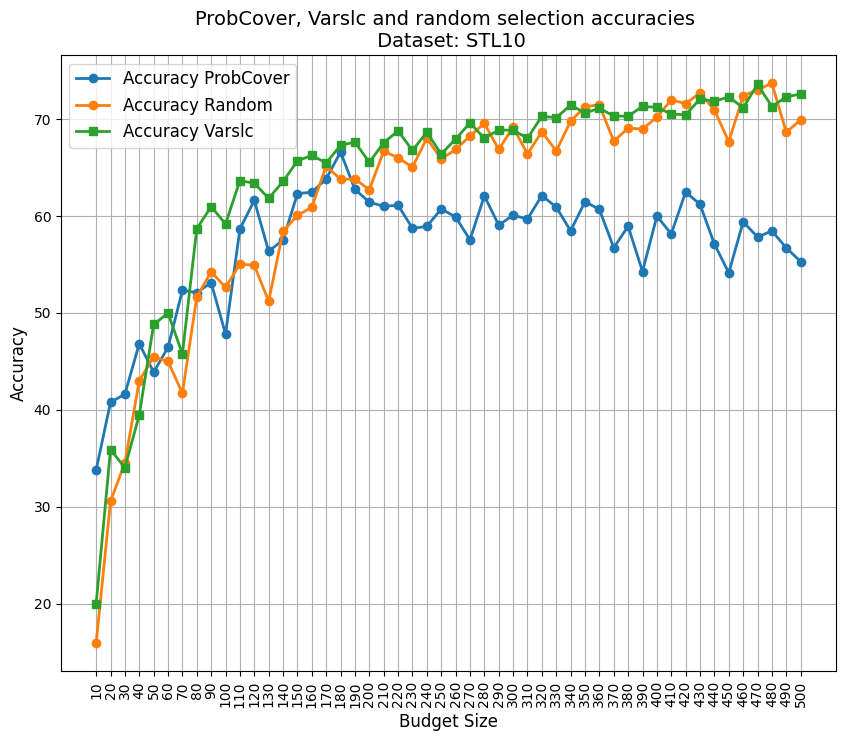

In [ ]:
plot_accuracy(final_results_stl10, "STL10")

In this plot, the x-axis is the budget size and the y-axis is the accuracy. We compare the performence of the three models.As we can see, for small budget, the ProbCover algorithm achieves higher accuracy. However, as the budget increases, the Varslc algorithm outperforms ProbCover and sometimes even surpasses the accuracy of the random selection method.




In the table below, we can see the accuracy of the random selection (acc_rand) vs the accuracy of the probCover algorithm (acc_prob) and the varSelection algorithm (acc_varslc), the budget size (budget), and the indices they chose (probcover_active_set) for the probCover algorithm, (varslc_active_set) for the varSelection algorithm and (random_set) for the random selection.


### CIFAR10

Start constructing graph using delta=0.85 (cosine similarity)


/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/2282487937.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cuda_feats = torch.tensor(self.rel_features)


Finished constructing graph using delta=0.85 (cosine similarity)
Graph contains 2605252 edges.
Start constructing graph using delta=0.85 (cosine similarity)
Finished constructing graph using delta=0.85 (cosine similarity)
Graph contains 2605252 edges.

Graph DataFrame:
   x    y         d
0  0    0  1.000000
1  0   19  0.910001
2  0  264  0.871852
3  0  302  0.877468
4  0  321  0.868041
Start selecting 500 samples.
Iteration 0.	Graph edges: 2605252.	Max degree: 1001.	Coverage: 0.000
Iteration 1.	Graph edges: 2122123.	Max degree: 846.	Coverage: 0.020
Iteration 2.	Graph edges: 1792551.	Max degree: 502.	Coverage: 0.037
Iteration 3.	Graph edges: 1668563.	Max degree: 371.	Coverage: 0.047
Iteration 4.	Graph edges: 1543729.	Max degree: 359.	Coverage: 0.054
Iteration 5.	Graph edges: 1495425.	Max degree: 348.	Coverage: 0.062
Iteration 6.	Graph edges: 1424160.	Max degree: 322.	Coverage: 0.069
Iteration 7.	Graph edges: 1373853.	Max degree: 319.	Coverage: 0.075
Iteration 8.	Graph edges: 1335596.	M

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 1/10, Loss: 2.2916712760925293
Epoch 2/10, Loss: 2.064620018005371
Epoch 3/10, Loss: 1.8885886669158936
Epoch 4/10, Loss: 1.711022138595581
Epoch 5/10, Loss: 1.5246950387954712
Epoch 6/10, Loss: 1.3291429281234741
Epoch 7/10, Loss: 1.1340752840042114
Epoch 8/10, Loss: 0.9447816014289856
Epoch 9/10, Loss: 0.7727711796760559
Epoch 10/10, Loss: 0.6228281259536743
Accuracy: 21.12%
Epoch 1/10, Loss: 2.326326847076416
Epoch 2/10, Loss: 2.0604379177093506
Epoch 3/10, Loss: 1.8366100788116455
Epoch 4/10, Loss: 1.611617088317871
Epoch 5/10, Loss: 1.3882540464401245
Epoch 6/10, Loss: 1.1665560007095337
Epoch 7/10, Loss: 0.9490066766738892
Epoch 8/10, Loss: 0.7404529452323914
Epoch 9/10, Loss: 0.5566058158874512
Epoch 10/10, Loss: 0.40248268842697144
Accuracy: 19.43%
Epoch 1/10, Loss: 2.2997512817382812
Epoch 2/10, Loss: 1.9810512065887451
Epoch 3/10, Loss: 1.7329967021942139
Epoch 4/10, Loss: 1.4990116357803345
Epoch 5/10, Loss: 1.2691537141799927
Epoch 6/10, Loss: 1.0504168272018433
Epoch

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/4218523931.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, row_df], ignore_index=True)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires

Accuracy: 24.03%
Epoch 1/10, Loss: 2.314302444458008
Epoch 2/10, Loss: 2.0984690189361572
Epoch 3/10, Loss: 1.9199556112289429
Epoch 4/10, Loss: 1.7377817630767822
Epoch 5/10, Loss: 1.550762414932251
Epoch 6/10, Loss: 1.3644919395446777
Epoch 7/10, Loss: 1.1815530061721802
Epoch 8/10, Loss: 1.004309058189392
Epoch 9/10, Loss: 0.833354651927948
Epoch 10/10, Loss: 0.6747251749038696
Accuracy: 22.33%
Epoch 1/10, Loss: 2.307098388671875
Epoch 2/10, Loss: 2.0721030235290527
Epoch 3/10, Loss: 1.8854373693466187
Epoch 4/10, Loss: 1.706782341003418
Epoch 5/10, Loss: 1.5251376628875732
Epoch 6/10, Loss: 1.3435423374176025
Epoch 7/10, Loss: 1.1664178371429443
Epoch 8/10, Loss: 0.9942566752433777
Epoch 9/10, Loss: 0.8312541246414185
Epoch 10/10, Loss: 0.6851251721382141
Accuracy: 20.21%
Epoch 1/10, Loss: 2.315981864929199
Epoch 2/10, Loss: 2.090122938156128
Epoch 3/10, Loss: 1.9011938571929932
Epoch 4/10, Loss: 1.7142117023468018
Epoch 5/10, Loss: 1.5216392278671265
Epoch 6/10, Loss: 1.3316160440

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 28.26%
Epoch 1/10, Loss: 2.319788932800293
Epoch 2/10, Loss: 2.1613223552703857
Epoch 3/10, Loss: 2.0343246459960938
Epoch 4/10, Loss: 1.9017893075942993
Epoch 5/10, Loss: 1.7603391408920288
Epoch 6/10, Loss: 1.6120542287826538
Epoch 7/10, Loss: 1.4612596035003662
Epoch 8/10, Loss: 1.3098152875900269
Epoch 9/10, Loss: 1.1608067750930786
Epoch 10/10, Loss: 1.0143275260925293
Accuracy: 23.10%
Epoch 1/10, Loss: 2.305863380432129
Epoch 2/10, Loss: 2.141852378845215
Epoch 3/10, Loss: 1.999350905418396
Epoch 4/10, Loss: 1.8496955633163452
Epoch 5/10, Loss: 1.6871800422668457
Epoch 6/10, Loss: 1.5150202512741089
Epoch 7/10, Loss: 1.339754581451416
Epoch 8/10, Loss: 1.16763436794281
Epoch 9/10, Loss: 1.004017949104309
Epoch 10/10, Loss: 0.8486381769180298
Accuracy: 24.63%
Epoch 1/10, Loss: 2.3024357557296753
Epoch 2/10, Loss: 1.9687260389328003
Epoch 3/10, Loss: 1.6783930659294128
Epoch 4/10, Loss: 1.5088573098182678
Epoch 5/10, Loss: 1.3806297779083252
Epoch 6/10, Loss: 1.0856611728

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 26.20%
Epoch 1/10, Loss: 2.290603518486023
Epoch 2/10, Loss: 1.9849742650985718
Epoch 3/10, Loss: 1.8231475353240967
Epoch 4/10, Loss: 1.5145145654678345
Epoch 5/10, Loss: 1.2237120270729065
Epoch 6/10, Loss: 1.0766803324222565
Epoch 7/10, Loss: 1.040304720401764
Epoch 8/10, Loss: 0.8784185647964478
Epoch 9/10, Loss: 0.7631196677684784
Epoch 10/10, Loss: 0.6255260407924652
Accuracy: 28.20%
Epoch 1/10, Loss: 2.2477561235427856
Epoch 2/10, Loss: 2.0349682569503784
Epoch 3/10, Loss: 1.8131873607635498
Epoch 4/10, Loss: 1.5740759372711182
Epoch 5/10, Loss: 1.3695220351219177
Epoch 6/10, Loss: 1.2124063968658447
Epoch 7/10, Loss: 1.0806888937950134
Epoch 8/10, Loss: 0.8290773928165436
Epoch 9/10, Loss: 0.812023401260376
Epoch 10/10, Loss: 0.6617844998836517
Accuracy: 27.56%
Epoch 1/10, Loss: 2.2515807151794434
Epoch 2/10, Loss: 1.9070172905921936
Epoch 3/10, Loss: 1.6623711585998535
Epoch 4/10, Loss: 1.4346075057983398
Epoch 5/10, Loss: 1.2226741313934326
Epoch 6/10, Loss: 1.09422

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 30.22%
Epoch 1/10, Loss: 2.3107670545578003
Epoch 2/10, Loss: 2.1129684448242188
Epoch 3/10, Loss: 1.9116653203964233
Epoch 4/10, Loss: 1.7058402299880981
Epoch 5/10, Loss: 1.4453449249267578
Epoch 6/10, Loss: 1.2647122740745544
Epoch 7/10, Loss: 1.0552995800971985
Epoch 8/10, Loss: 0.8295431733131409
Epoch 9/10, Loss: 0.6749504804611206
Epoch 10/10, Loss: 0.5420019626617432
Accuracy: 32.27%
Epoch 1/10, Loss: 2.288485050201416
Epoch 2/10, Loss: 2.0213087797164917
Epoch 3/10, Loss: 1.839587390422821
Epoch 4/10, Loss: 1.5719784498214722
Epoch 5/10, Loss: 1.3142060041427612
Epoch 6/10, Loss: 1.129887342453003
Epoch 7/10, Loss: 0.9416058957576752
Epoch 8/10, Loss: 0.7868248522281647
Epoch 9/10, Loss: 0.6212262511253357
Epoch 10/10, Loss: 0.49011506140232086
Accuracy: 27.98%
Epoch 1/10, Loss: 2.2671239376068115
Epoch 2/10, Loss: 1.9360881447792053
Epoch 3/10, Loss: 1.7031466364860535
Epoch 4/10, Loss: 1.4654601216316223
Epoch 5/10, Loss: 1.2394282817840576
Epoch 6/10, Loss: 1.0919

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 30.79%
Epoch 1/10, Loss: 2.2841579914093018
Epoch 2/10, Loss: 2.0598697662353516
Epoch 3/10, Loss: 1.8425065279006958
Epoch 4/10, Loss: 1.632832109928131
Epoch 5/10, Loss: 1.4238813519477844
Epoch 6/10, Loss: 1.2174454927444458
Epoch 7/10, Loss: 1.029666244983673
Epoch 8/10, Loss: 0.8657739162445068
Epoch 9/10, Loss: 0.6909655034542084
Epoch 10/10, Loss: 0.5505404025316238
Accuracy: 33.69%
Epoch 1/10, Loss: 2.3108413219451904
Epoch 2/10, Loss: 2.117671847343445
Epoch 3/10, Loss: 1.9235255122184753
Epoch 4/10, Loss: 1.7141419053077698
Epoch 5/10, Loss: 1.4981048107147217
Epoch 6/10, Loss: 1.2898778319358826
Epoch 7/10, Loss: 1.0832387208938599
Epoch 8/10, Loss: 0.900327056646347
Epoch 9/10, Loss: 0.7401261627674103
Epoch 10/10, Loss: 0.5992229878902435
Accuracy: 30.05%
Epoch 1/10, Loss: 2.197697162628174
Epoch 2/10, Loss: 1.8777391115824382
Epoch 3/10, Loss: 1.6103253761927288
Epoch 4/10, Loss: 1.3563203016916912
Epoch 5/10, Loss: 1.26267143090566
Epoch 6/10, Loss: 1.118968923

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 31.74%
Epoch 1/10, Loss: 2.277937332789103
Epoch 2/10, Loss: 2.0005682706832886
Epoch 3/10, Loss: 1.7394167184829712
Epoch 4/10, Loss: 1.5572444597880046
Epoch 5/10, Loss: 1.3386540412902832
Epoch 6/10, Loss: 1.2738802433013916
Epoch 7/10, Loss: 1.0906451145807903
Epoch 8/10, Loss: 0.832571268081665
Epoch 9/10, Loss: 0.8561059832572937
Epoch 10/10, Loss: 0.6344590187072754
Accuracy: 34.24%
Epoch 1/10, Loss: 2.2888193130493164
Epoch 2/10, Loss: 2.1286768118540444
Epoch 3/10, Loss: 1.9284947315851848
Epoch 4/10, Loss: 1.7109788656234741
Epoch 5/10, Loss: 1.5474244356155396
Epoch 6/10, Loss: 1.370438019434611
Epoch 7/10, Loss: 1.1495868762334187
Epoch 8/10, Loss: 1.106398383776347
Epoch 9/10, Loss: 0.8840264081954956
Epoch 10/10, Loss: 0.7771060864130656
Accuracy: 29.79%
Epoch 1/10, Loss: 2.209756056467692
Epoch 2/10, Loss: 1.872599442799886
Epoch 3/10, Loss: 1.6385421355565388
Epoch 4/10, Loss: 1.3314520915349324
Epoch 5/10, Loss: 1.175427238146464
Epoch 6/10, Loss: 1.012425144

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 32.92%
Epoch 1/10, Loss: 2.287064552307129
Epoch 2/10, Loss: 2.067921280860901
Epoch 3/10, Loss: 1.8487216234207153
Epoch 4/10, Loss: 1.5813926060994465
Epoch 5/10, Loss: 1.3889563083648682
Epoch 6/10, Loss: 1.237722675005595
Epoch 7/10, Loss: 0.9885875781377157
Epoch 8/10, Loss: 0.8090357979138693
Epoch 9/10, Loss: 0.7020076513290405
Epoch 10/10, Loss: 0.5364764531453451
Accuracy: 36.82%
Epoch 1/10, Loss: 2.308298031489054
Epoch 2/10, Loss: 2.016632159550985
Epoch 3/10, Loss: 1.7730880975723267
Epoch 4/10, Loss: 1.550696849822998
Epoch 5/10, Loss: 1.3129626909891765
Epoch 6/10, Loss: 1.0983670155207317
Epoch 7/10, Loss: 0.8823635578155518
Epoch 8/10, Loss: 0.7428178588549296
Epoch 9/10, Loss: 0.5758533875147501
Epoch 10/10, Loss: 0.46791478991508484
Accuracy: 33.28%
Epoch 1/10, Loss: 2.1907999515533447
Epoch 2/10, Loss: 1.7904043594996135
Epoch 3/10, Loss: 1.5355706612269084
Epoch 4/10, Loss: 1.281323512395223
Epoch 5/10, Loss: 1.138550043106079
Epoch 6/10, Loss: 0.990995347

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 33.82%
Epoch 1/10, Loss: 2.2646506627400718
Epoch 2/10, Loss: 2.0002677838007608
Epoch 3/10, Loss: 1.747801423072815
Epoch 4/10, Loss: 1.509976863861084
Epoch 5/10, Loss: 1.314074993133545
Epoch 6/10, Loss: 1.133710781733195
Epoch 7/10, Loss: 0.9769792556762695
Epoch 8/10, Loss: 0.8142100771268209
Epoch 9/10, Loss: 0.6590746442476908
Epoch 10/10, Loss: 0.5414340297381083
Accuracy: 37.49%
Epoch 1/10, Loss: 2.2782609462738037
Epoch 2/10, Loss: 2.032575567563375
Epoch 3/10, Loss: 1.803169886271159
Epoch 4/10, Loss: 1.5616802374521892
Epoch 5/10, Loss: 1.337883710861206
Epoch 6/10, Loss: 1.1437787214914958
Epoch 7/10, Loss: 0.9475412368774414
Epoch 8/10, Loss: 0.7767889698346456
Epoch 9/10, Loss: 0.6302464803059896
Epoch 10/10, Loss: 0.5225216448307037
Accuracy: 32.35%
Epoch 1/10, Loss: 2.1726837158203125
Epoch 2/10, Loss: 1.8424798250198364
Epoch 3/10, Loss: 1.6137204766273499
Epoch 4/10, Loss: 1.1790920794010162
Epoch 5/10, Loss: 1.0902043282985687
Epoch 6/10, Loss: 0.988728225

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 32.27%
Epoch 1/10, Loss: 2.2328829765319824
Epoch 2/10, Loss: 2.111021727323532
Epoch 3/10, Loss: 1.6616659760475159
Epoch 4/10, Loss: 1.460624486207962
Epoch 5/10, Loss: 1.238267406821251
Epoch 6/10, Loss: 1.1728841066360474
Epoch 7/10, Loss: 0.8822108805179596
Epoch 8/10, Loss: 0.9214058518409729
Epoch 9/10, Loss: 0.7942277789115906
Epoch 10/10, Loss: 0.6929003596305847
Accuracy: 36.48%
Epoch 1/10, Loss: 2.2467952966690063
Epoch 2/10, Loss: 1.9671694934368134
Epoch 3/10, Loss: 1.780367374420166
Epoch 4/10, Loss: 1.5340693593025208
Epoch 5/10, Loss: 1.4653625190258026
Epoch 6/10, Loss: 1.2731733620166779
Epoch 7/10, Loss: 1.1171717643737793
Epoch 8/10, Loss: 0.9647708535194397
Epoch 9/10, Loss: 0.8041512817144394
Epoch 10/10, Loss: 0.8240408599376678
Accuracy: 31.77%
Epoch 1/10, Loss: 2.1615471839904785
Epoch 2/10, Loss: 1.835583209991455
Epoch 3/10, Loss: 1.4715441465377808
Epoch 4/10, Loss: 1.2434740364551544
Epoch 5/10, Loss: 1.0873085260391235
Epoch 6/10, Loss: 0.9236749

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 36.65%
Epoch 1/10, Loss: 2.2626126408576965
Epoch 2/10, Loss: 1.9859789907932281
Epoch 3/10, Loss: 1.7387591004371643
Epoch 4/10, Loss: 1.4375374913215637
Epoch 5/10, Loss: 1.243126630783081
Epoch 6/10, Loss: 1.0873245596885681
Epoch 7/10, Loss: 0.9091316014528275
Epoch 8/10, Loss: 0.7358196377754211
Epoch 9/10, Loss: 0.5929665267467499
Epoch 10/10, Loss: 0.4690892621874809
Accuracy: 38.03%
Epoch 1/10, Loss: 2.2639812231063843
Epoch 2/10, Loss: 2.0036725401878357
Epoch 3/10, Loss: 1.7743728458881378
Epoch 4/10, Loss: 1.5474887192249298
Epoch 5/10, Loss: 1.2925740480422974
Epoch 6/10, Loss: 1.0864567756652832
Epoch 7/10, Loss: 0.9723993986845016
Epoch 8/10, Loss: 0.7828558832406998
Epoch 9/10, Loss: 0.61692975461483
Epoch 10/10, Loss: 0.5242710188031197
Accuracy: 35.09%
Epoch 1/10, Loss: 2.15334153175354
Epoch 2/10, Loss: 1.727337896823883
Epoch 3/10, Loss: 1.3974565267562866
Epoch 4/10, Loss: 1.2237773835659027
Epoch 5/10, Loss: 1.0376770049333572
Epoch 6/10, Loss: 0.89332056

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 36.56%
Epoch 1/10, Loss: 2.2601752877235413
Epoch 2/10, Loss: 1.9498520195484161
Epoch 3/10, Loss: 1.7352539598941803
Epoch 4/10, Loss: 1.50396728515625
Epoch 5/10, Loss: 1.295409232378006
Epoch 6/10, Loss: 1.0972934663295746
Epoch 7/10, Loss: 0.9296230375766754
Epoch 8/10, Loss: 0.7747350931167603
Epoch 9/10, Loss: 0.6339848339557648
Epoch 10/10, Loss: 0.5217692628502846
Accuracy: 38.14%
Epoch 1/10, Loss: 2.2710044384002686
Epoch 2/10, Loss: 2.010839819908142
Epoch 3/10, Loss: 1.7432224750518799
Epoch 4/10, Loss: 1.537471741437912
Epoch 5/10, Loss: 1.3008831143379211
Epoch 6/10, Loss: 1.1057196259498596
Epoch 7/10, Loss: 0.9177988320589066
Epoch 8/10, Loss: 0.763974204659462
Epoch 9/10, Loss: 0.6422234922647476
Epoch 10/10, Loss: 0.5088195875287056
Accuracy: 34.97%
Epoch 1/10, Loss: 2.0116280794143675
Epoch 2/10, Loss: 1.9670085906982422
Epoch 3/10, Loss: 1.4905313014984132
Epoch 4/10, Loss: 1.4050014019012451
Epoch 5/10, Loss: 1.0934047102928162
Epoch 6/10, Loss: 1.16275439

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 29.39%
Epoch 1/10, Loss: 2.297392177581787
Epoch 2/10, Loss: 2.0050291538238527
Epoch 3/10, Loss: 1.8506266593933105
Epoch 4/10, Loss: 1.6440389633178711
Epoch 5/10, Loss: 1.3629952192306518
Epoch 6/10, Loss: 1.290762996673584
Epoch 7/10, Loss: 1.1147903442382812
Epoch 8/10, Loss: 1.0474347710609435
Epoch 9/10, Loss: 0.9759980797767639
Epoch 10/10, Loss: 0.9189691781997681
Accuracy: 33.66%
Epoch 1/10, Loss: 2.2254822731018065
Epoch 2/10, Loss: 1.9240946054458619
Epoch 3/10, Loss: 1.7374046087265014
Epoch 4/10, Loss: 1.5425047159194947
Epoch 5/10, Loss: 1.3470661163330078
Epoch 6/10, Loss: 1.1132015347480775
Epoch 7/10, Loss: 1.1342825889587402
Epoch 8/10, Loss: 0.8720254838466645
Epoch 9/10, Loss: 0.7989095479249955
Epoch 10/10, Loss: 0.8117254495620727
Accuracy: 33.46%
Epoch 1/10, Loss: 2.209583616256714
Epoch 2/10, Loss: 1.8329996585845947
Epoch 3/10, Loss: 1.5133067131042481
Epoch 4/10, Loss: 1.2374605655670166
Epoch 5/10, Loss: 1.0555849432945252
Epoch 6/10, Loss: 0.92723

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 37.14%
Epoch 1/10, Loss: 2.2659332752227783
Epoch 2/10, Loss: 1.9434030771255493
Epoch 3/10, Loss: 1.7696665287017823
Epoch 4/10, Loss: 1.4840169906616212
Epoch 5/10, Loss: 1.3266458988189698
Epoch 6/10, Loss: 1.036554491519928
Epoch 7/10, Loss: 0.9135752558708191
Epoch 8/10, Loss: 0.7192818760871887
Epoch 9/10, Loss: 0.6692447662353516
Epoch 10/10, Loss: 0.47340233325958253
Accuracy: 38.26%
Epoch 1/10, Loss: 2.2530815601348877
Epoch 2/10, Loss: 1.9345620155334473
Epoch 3/10, Loss: 1.7079961061477662
Epoch 4/10, Loss: 1.4742291212081908
Epoch 5/10, Loss: 1.2431481599807739
Epoch 6/10, Loss: 1.0707672595977784
Epoch 7/10, Loss: 0.8744179368019104
Epoch 8/10, Loss: 0.8623174250125885
Epoch 9/10, Loss: 0.6255851030349732
Epoch 10/10, Loss: 0.6055835127830506
Accuracy: 36.38%
Epoch 1/10, Loss: 2.1696911811828614
Epoch 2/10, Loss: 1.7732542514801026
Epoch 3/10, Loss: 1.4480854511260985
Epoch 4/10, Loss: 1.2009871482849122
Epoch 5/10, Loss: 1.0197818160057068
Epoch 6/10, Loss: 0.86

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 38.05%
Epoch 1/10, Loss: 2.2291934490203857
Epoch 2/10, Loss: 1.981009030342102
Epoch 3/10, Loss: 1.675989031791687
Epoch 4/10, Loss: 1.3992649793624878
Epoch 5/10, Loss: 1.2242660045623779
Epoch 6/10, Loss: 1.0267260551452637
Epoch 7/10, Loss: 0.8357091784477234
Epoch 8/10, Loss: 0.6849179983139038
Epoch 9/10, Loss: 0.5526491940021515
Epoch 10/10, Loss: 0.43576167821884154
Accuracy: 38.81%
Epoch 1/10, Loss: 2.281951379776001
Epoch 2/10, Loss: 2.0419668436050413
Epoch 3/10, Loss: 1.8040475845336914
Epoch 4/10, Loss: 1.5593087911605834
Epoch 5/10, Loss: 1.3206892728805542
Epoch 6/10, Loss: 1.1616655111312866
Epoch 7/10, Loss: 0.9672981858253479
Epoch 8/10, Loss: 0.8236926555633545
Epoch 9/10, Loss: 0.721311891078949
Epoch 10/10, Loss: 0.544056361913681
Accuracy: 37.49%
Epoch 1/10, Loss: 2.1722662448883057
Epoch 2/10, Loss: 1.8099302530288697
Epoch 3/10, Loss: 1.5166414260864258
Epoch 4/10, Loss: 1.2460753440856933
Epoch 5/10, Loss: 1.058731162548065
Epoch 6/10, Loss: 0.9031094

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 38.99%
Epoch 1/10, Loss: 2.2731340408325194
Epoch 2/10, Loss: 1.9905027389526366
Epoch 3/10, Loss: 1.7306967973709106
Epoch 4/10, Loss: 1.4470136642456055
Epoch 5/10, Loss: 1.2189794778823853
Epoch 6/10, Loss: 1.0614342212677002
Epoch 7/10, Loss: 0.8800618171691894
Epoch 8/10, Loss: 0.7877653479576111
Epoch 9/10, Loss: 0.6395992994308471
Epoch 10/10, Loss: 0.5624041438102723
Accuracy: 38.27%
Epoch 1/10, Loss: 2.290280342102051
Epoch 2/10, Loss: 2.0292509317398073
Epoch 3/10, Loss: 1.8066920280456542
Epoch 4/10, Loss: 1.5979941844940186
Epoch 5/10, Loss: 1.403944182395935
Epoch 6/10, Loss: 1.1929064512252807
Epoch 7/10, Loss: 1.0252896785736083
Epoch 8/10, Loss: 0.8461276531219483
Epoch 9/10, Loss: 0.7316731572151184
Epoch 10/10, Loss: 0.5744868040084838
Accuracy: 35.63%
Epoch 1/10, Loss: 2.1510953505833945
Epoch 2/10, Loss: 1.7382439374923706
Epoch 3/10, Loss: 1.5050452947616577
Epoch 4/10, Loss: 1.204614649216334
Epoch 5/10, Loss: 1.0151661137739818
Epoch 6/10, Loss: 0.94257

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 38.66%
Epoch 1/10, Loss: 2.215046246846517
Epoch 2/10, Loss: 1.928692062695821
Epoch 3/10, Loss: 1.5998204549153645
Epoch 4/10, Loss: 1.4006089170773823
Epoch 5/10, Loss: 1.1515269776185353
Epoch 6/10, Loss: 0.9936502277851105
Epoch 7/10, Loss: 0.8744358619054159
Epoch 8/10, Loss: 0.6861711889505386
Epoch 9/10, Loss: 0.5874169717232386
Epoch 10/10, Loss: 0.4866724858681361
Accuracy: 40.24%
Epoch 1/10, Loss: 2.26650337378184
Epoch 2/10, Loss: 1.9974443515141804
Epoch 3/10, Loss: 1.7411372661590576
Epoch 4/10, Loss: 1.5233287811279297
Epoch 5/10, Loss: 1.3285274704297383
Epoch 6/10, Loss: 1.1470988194147747
Epoch 7/10, Loss: 0.9903430044651031
Epoch 8/10, Loss: 0.8274896343549093
Epoch 9/10, Loss: 0.7234326601028442
Epoch 10/10, Loss: 0.6972250590721766
Accuracy: 38.02%
Epoch 1/10, Loss: 2.1188597877820334
Epoch 2/10, Loss: 1.6951830387115479
Epoch 3/10, Loss: 1.3553320566813152
Epoch 4/10, Loss: 1.1463045279184978
Epoch 5/10, Loss: 0.9462355573972067
Epoch 6/10, Loss: 0.795273

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 40.57%
Epoch 1/10, Loss: 2.228921095530192
Epoch 2/10, Loss: 1.8800640900929768
Epoch 3/10, Loss: 1.5738123257954915
Epoch 4/10, Loss: 1.3054322401682537
Epoch 5/10, Loss: 1.1246642967065175
Epoch 6/10, Loss: 0.9846888184547424
Epoch 7/10, Loss: 0.8125856121381124
Epoch 8/10, Loss: 0.6599016239245733
Epoch 9/10, Loss: 0.5407841751972834
Epoch 10/10, Loss: 0.44954919318358105
Accuracy: 40.47%
Epoch 1/10, Loss: 2.2616806427637735
Epoch 2/10, Loss: 1.960478166739146
Epoch 3/10, Loss: 1.6516330639521282
Epoch 4/10, Loss: 1.4211878180503845
Epoch 5/10, Loss: 1.2307334343592327
Epoch 6/10, Loss: 1.105199118455251
Epoch 7/10, Loss: 0.8656588892141978
Epoch 8/10, Loss: 0.7499215404192606
Epoch 9/10, Loss: 0.6008044332265854
Epoch 10/10, Loss: 0.4896431267261505
Accuracy: 39.59%
Epoch 1/10, Loss: 2.1486583948135376
Epoch 2/10, Loss: 1.6777619123458862
Epoch 3/10, Loss: 1.3922847509384155
Epoch 4/10, Loss: 1.1927722295125325
Epoch 5/10, Loss: 0.9970215857028961
Epoch 6/10, Loss: 0.8727

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 41.48%
Epoch 1/10, Loss: 2.22615647315979
Epoch 2/10, Loss: 1.8443946639696758
Epoch 3/10, Loss: 1.5256935954093933
Epoch 4/10, Loss: 1.2820911208788555
Epoch 5/10, Loss: 1.1642462015151978
Epoch 6/10, Loss: 0.9505785902341207
Epoch 7/10, Loss: 0.8142321010430654
Epoch 8/10, Loss: 0.6723546286424001
Epoch 9/10, Loss: 0.5738210181395212
Epoch 10/10, Loss: 0.4436669449011485
Accuracy: 41.30%
Epoch 1/10, Loss: 2.2723666429519653
Epoch 2/10, Loss: 2.003782550493876
Epoch 3/10, Loss: 1.7197952071825664
Epoch 4/10, Loss: 1.4799962838490803
Epoch 5/10, Loss: 1.2655550837516785
Epoch 6/10, Loss: 1.0641946991284688
Epoch 7/10, Loss: 0.8754402200380961
Epoch 8/10, Loss: 0.7392094433307648
Epoch 9/10, Loss: 0.6440597573916117
Epoch 10/10, Loss: 0.5156740993261337
Accuracy: 37.86%
Epoch 1/10, Loss: 2.0880020345960344
Epoch 2/10, Loss: 1.6359866176332747
Epoch 3/10, Loss: 1.3527464185442244
Epoch 4/10, Loss: 1.0968912414142065
Epoch 5/10, Loss: 0.9996556128774371
Epoch 6/10, Loss: 0.89837

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 39.39%
Epoch 1/10, Loss: 2.221165725163051
Epoch 2/10, Loss: 1.8164949076516288
Epoch 3/10, Loss: 1.5606698819569178
Epoch 4/10, Loss: 1.3589226007461548
Epoch 5/10, Loss: 1.1182466745376587
Epoch 6/10, Loss: 1.0507396459579468
Epoch 7/10, Loss: 0.8408165999821254
Epoch 8/10, Loss: 0.7084778802735465
Epoch 9/10, Loss: 0.63728266954422
Epoch 10/10, Loss: 0.5500976400715964
Accuracy: 41.18%
Epoch 1/10, Loss: 2.277014528002058
Epoch 2/10, Loss: 2.0191928148269653
Epoch 3/10, Loss: 1.711021133831569
Epoch 4/10, Loss: 1.444511958530971
Epoch 5/10, Loss: 1.3631913661956787
Epoch 6/10, Loss: 1.1063340987477983
Epoch 7/10, Loss: 1.041968251977648
Epoch 8/10, Loss: 0.8388738547052655
Epoch 9/10, Loss: 0.7654778616768974
Epoch 10/10, Loss: 0.6343343428203038
Accuracy: 39.70%
Epoch 1/10, Loss: 2.124900426183428
Epoch 2/10, Loss: 1.6375680991581507
Epoch 3/10, Loss: 1.2964615055492945
Epoch 4/10, Loss: 1.1329506380217416
Epoch 5/10, Loss: 0.9961831995419094
Epoch 6/10, Loss: 0.9524298565

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 40.36%
Epoch 1/10, Loss: 2.236455576760428
Epoch 2/10, Loss: 1.873836943081447
Epoch 3/10, Loss: 1.6004588774272375
Epoch 4/10, Loss: 1.3062056984220232
Epoch 5/10, Loss: 1.1044481822422572
Epoch 6/10, Loss: 0.9685204369681222
Epoch 7/10, Loss: 0.8470418793814523
Epoch 8/10, Loss: 0.6838361535753522
Epoch 9/10, Loss: 0.5758367223399026
Epoch 10/10, Loss: 0.46493382113320486
Accuracy: 40.57%
Epoch 1/10, Loss: 2.255730220249721
Epoch 2/10, Loss: 1.9793768780572074
Epoch 3/10, Loss: 1.7253839118140084
Epoch 4/10, Loss: 1.48160719871521
Epoch 5/10, Loss: 1.2752925327845983
Epoch 6/10, Loss: 1.1159150685582842
Epoch 7/10, Loss: 1.0001463549477714
Epoch 8/10, Loss: 0.8267032504081726
Epoch 9/10, Loss: 0.6974805082593646
Epoch 10/10, Loss: 0.596115061214992
Accuracy: 35.68%
Epoch 1/10, Loss: 2.155164429119655
Epoch 2/10, Loss: 1.7346116134098597
Epoch 3/10, Loss: 1.4129351207188197
Epoch 4/10, Loss: 1.1986294303621565
Epoch 5/10, Loss: 1.0207518594605582
Epoch 6/10, Loss: 0.90248876

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 41.75%
Epoch 1/10, Loss: 2.2174205098833357
Epoch 2/10, Loss: 1.8590112924575806
Epoch 3/10, Loss: 1.53610782963889
Epoch 4/10, Loss: 1.2961616005216325
Epoch 5/10, Loss: 1.1504532183919634
Epoch 6/10, Loss: 0.9810289485113961
Epoch 7/10, Loss: 0.8344819971493312
Epoch 8/10, Loss: 0.7136362620762416
Epoch 9/10, Loss: 0.5917943588324955
Epoch 10/10, Loss: 0.4826192430087498
Accuracy: 41.36%
Epoch 1/10, Loss: 2.270991223199027
Epoch 2/10, Loss: 1.9962769746780396
Epoch 3/10, Loss: 1.7134831632886613
Epoch 4/10, Loss: 1.4754276445933752
Epoch 5/10, Loss: 1.2774848937988281
Epoch 6/10, Loss: 1.1027740410396032
Epoch 7/10, Loss: 0.9271350758416312
Epoch 8/10, Loss: 0.7749956250190735
Epoch 9/10, Loss: 0.6497272253036499
Epoch 10/10, Loss: 0.5754572876862117
Accuracy: 38.75%
Epoch 1/10, Loss: 2.0277186930179596
Epoch 2/10, Loss: 1.6241010427474976
Epoch 3/10, Loss: 1.3494155257940292
Epoch 4/10, Loss: 1.1564299166202545
Epoch 5/10, Loss: 0.9802556186914444
Epoch 6/10, Loss: 0.85204

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 42.40%
Epoch 1/10, Loss: 2.2274114787578583
Epoch 2/10, Loss: 1.848906397819519
Epoch 3/10, Loss: 1.522967979311943
Epoch 4/10, Loss: 1.3026189282536507
Epoch 5/10, Loss: 1.2716282308101654
Epoch 6/10, Loss: 1.0915146619081497
Epoch 7/10, Loss: 0.9124877452850342
Epoch 8/10, Loss: 0.7569628283381462
Epoch 9/10, Loss: 0.6399462446570396
Epoch 10/10, Loss: 0.5276878345757723
Accuracy: 41.15%
Epoch 1/10, Loss: 2.2795059084892273
Epoch 2/10, Loss: 1.9624118953943253
Epoch 3/10, Loss: 1.735856980085373
Epoch 4/10, Loss: 1.526226669549942
Epoch 5/10, Loss: 1.3649250119924545
Epoch 6/10, Loss: 1.1700564920902252
Epoch 7/10, Loss: 1.0940015465021133
Epoch 8/10, Loss: 0.8852688670158386
Epoch 9/10, Loss: 0.7422105371952057
Epoch 10/10, Loss: 0.629675880074501
Accuracy: 40.89%
Epoch 1/10, Loss: 2.125244900584221
Epoch 2/10, Loss: 1.626228854060173
Epoch 3/10, Loss: 1.298254482448101
Epoch 4/10, Loss: 1.127152480185032
Epoch 5/10, Loss: 0.9386295601725578
Epoch 6/10, Loss: 0.82166556268

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 41.94%
Epoch 1/10, Loss: 2.1921951174736023
Epoch 2/10, Loss: 1.821977213025093
Epoch 3/10, Loss: 1.5304802656173706
Epoch 4/10, Loss: 1.3390981703996658
Epoch 5/10, Loss: 1.1660078465938568
Epoch 6/10, Loss: 1.0075331255793571
Epoch 7/10, Loss: 0.8415888249874115
Epoch 8/10, Loss: 0.6981164515018463
Epoch 9/10, Loss: 0.6042824201285839
Epoch 10/10, Loss: 0.49770117923617363
Accuracy: 40.69%
Epoch 1/10, Loss: 2.2549052238464355
Epoch 2/10, Loss: 1.999491885304451
Epoch 3/10, Loss: 1.7026218175888062
Epoch 4/10, Loss: 1.4801581054925919
Epoch 5/10, Loss: 1.3039034754037857
Epoch 6/10, Loss: 1.1196615397930145
Epoch 7/10, Loss: 0.9559749066829681
Epoch 8/10, Loss: 0.8656600713729858
Epoch 9/10, Loss: 0.6885606572031975
Epoch 10/10, Loss: 0.5861456096172333
Accuracy: 39.99%
Epoch 1/10, Loss: 2.1132128089666367
Epoch 2/10, Loss: 1.609943002462387
Epoch 3/10, Loss: 1.3002495616674423
Epoch 4/10, Loss: 1.0837002322077751
Epoch 5/10, Loss: 0.9559095725417137
Epoch 6/10, Loss: 0.8570

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 40.89%
Epoch 1/10, Loss: 2.2055582404136658
Epoch 2/10, Loss: 1.8549936562776566
Epoch 3/10, Loss: 1.5397463291883469
Epoch 4/10, Loss: 1.3153645992279053
Epoch 5/10, Loss: 1.1036586612462997
Epoch 6/10, Loss: 0.967798501253128
Epoch 7/10, Loss: 0.8362414166331291
Epoch 8/10, Loss: 0.6812232211232185
Epoch 9/10, Loss: 0.6046275570988655
Epoch 10/10, Loss: 0.4946121796965599
Accuracy: 41.09%
Epoch 1/10, Loss: 2.2669237554073334
Epoch 2/10, Loss: 2.0237376391887665
Epoch 3/10, Loss: 1.772243693470955
Epoch 4/10, Loss: 1.5427254438400269
Epoch 5/10, Loss: 1.3717600852251053
Epoch 6/10, Loss: 1.1858885884284973
Epoch 7/10, Loss: 1.024569220840931
Epoch 8/10, Loss: 0.8989027142524719
Epoch 9/10, Loss: 0.7320704758167267
Epoch 10/10, Loss: 0.6063278466463089
Accuracy: 38.99%
Epoch 1/10, Loss: 2.066389865345425
Epoch 2/10, Loss: 1.618161718050639
Epoch 3/10, Loss: 1.3271491130193074
Epoch 4/10, Loss: 1.163983682791392
Epoch 5/10, Loss: 1.003781470987532
Epoch 6/10, Loss: 0.862592763

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 9/10, Loss: 0.6229796707630157
Epoch 10/10, Loss: 0.5585010084840987
Accuracy: 43.10%
Epoch 1/10, Loss: 2.2055829101138644
Epoch 2/10, Loss: 1.7731153567632039
Epoch 3/10, Loss: 1.5385454893112183
Epoch 4/10, Loss: 1.3087252378463745
Epoch 5/10, Loss: 1.1642949846055772
Epoch 6/10, Loss: 1.0303998192151387
Epoch 7/10, Loss: 0.8957681788338555
Epoch 8/10, Loss: 0.888382805718316
Epoch 9/10, Loss: 0.720517506202062
Epoch 10/10, Loss: 0.6334206461906433
Accuracy: 41.72%
Epoch 1/10, Loss: 2.254172404607137
Epoch 2/10, Loss: 1.9540363285276625
Epoch 3/10, Loss: 1.6899201075236003
Epoch 4/10, Loss: 1.4733621676762898
Epoch 5/10, Loss: 1.303436107105679
Epoch 6/10, Loss: 1.2360371351242065
Epoch 7/10, Loss: 1.0928660564952426
Epoch 8/10, Loss: 0.90581789943907
Epoch 9/10, Loss: 0.8844088051054213
Epoch 10/10, Loss: 0.6778480807940165
Accuracy: 39.65%
Epoch 1/10, Loss: 2.1355155309041343
Epoch 2/10, Loss: 1.575317144393921
Epoch 3/10, Loss: 1.3575750324461195
Epoch 4/10, Loss: 1.11445001

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 43.37%
Epoch 1/10, Loss: 2.2224025196499295
Epoch 2/10, Loss: 1.8611269659466214
Epoch 3/10, Loss: 1.5073680480321248
Epoch 4/10, Loss: 1.2982719871732924
Epoch 5/10, Loss: 1.1256644990709093
Epoch 6/10, Loss: 0.9790397418869866
Epoch 7/10, Loss: 0.8273714250988431
Epoch 8/10, Loss: 0.6716951363616519
Epoch 9/10, Loss: 0.5328773061434428
Epoch 10/10, Loss: 0.4702973531352149
Accuracy: 40.13%
Epoch 1/10, Loss: 2.251087956958347
Epoch 2/10, Loss: 1.9249259365929499
Epoch 3/10, Loss: 1.6517215834723578
Epoch 4/10, Loss: 1.4208816024992201
Epoch 5/10, Loss: 1.1847981810569763
Epoch 6/10, Loss: 1.0381989611519709
Epoch 7/10, Loss: 0.9356559978591071
Epoch 8/10, Loss: 0.7777726650238037
Epoch 9/10, Loss: 0.6115151511298286
Epoch 10/10, Loss: 0.5001857777436575
Accuracy: 41.17%
Epoch 1/10, Loss: 2.114986154768202
Epoch 2/10, Loss: 1.6096132331424289
Epoch 3/10, Loss: 1.312475813759698
Epoch 4/10, Loss: 1.1164499918619792
Epoch 5/10, Loss: 0.9366687337557474
Epoch 6/10, Loss: 0.84925

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 42.92%
Epoch 1/10, Loss: 2.205608261956109
Epoch 2/10, Loss: 1.8232502010133531
Epoch 3/10, Loss: 1.520521534813775
Epoch 4/10, Loss: 1.292862892150879
Epoch 5/10, Loss: 1.1078067024548848
Epoch 6/10, Loss: 0.9557851221826341
Epoch 7/10, Loss: 0.8301753931575351
Epoch 8/10, Loss: 0.7081412672996521
Epoch 9/10, Loss: 0.5591653121842278
Epoch 10/10, Loss: 0.44941989580790204
Accuracy: 41.18%
Epoch 1/10, Loss: 2.241546551386515
Epoch 2/10, Loss: 1.928033219443427
Epoch 3/10, Loss: 1.6370812786950006
Epoch 4/10, Loss: 1.443727731704712
Epoch 5/10, Loss: 1.3055343760384455
Epoch 6/10, Loss: 1.1281826893488567
Epoch 7/10, Loss: 0.9327796300252279
Epoch 8/10, Loss: 0.8039388193024529
Epoch 9/10, Loss: 0.6979342169231839
Epoch 10/10, Loss: 0.59534885485967
Accuracy: 42.83%
Epoch 1/10, Loss: 2.1659092545509337
Epoch 2/10, Loss: 1.6070047259330749
Epoch 3/10, Loss: 1.4903162837028503
Epoch 4/10, Loss: 1.305319756269455
Epoch 5/10, Loss: 1.0822946310043335
Epoch 6/10, Loss: 0.9592863023

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 42.64%
Epoch 1/10, Loss: 2.150051999092102
Epoch 2/10, Loss: 1.7637329578399659
Epoch 3/10, Loss: 1.5765835523605347
Epoch 4/10, Loss: 1.317135512828827
Epoch 5/10, Loss: 1.1548751890659332
Epoch 6/10, Loss: 1.1208200573921203
Epoch 7/10, Loss: 1.0050869584083557
Epoch 8/10, Loss: 0.8512298434972763
Epoch 9/10, Loss: 0.7584910154342651
Epoch 10/10, Loss: 0.6849694222211837
Accuracy: 40.37%
Epoch 1/10, Loss: 2.206538224220276
Epoch 2/10, Loss: 1.895997941493988
Epoch 3/10, Loss: 1.7623043298721313
Epoch 4/10, Loss: 1.4586157023906707
Epoch 5/10, Loss: 1.4360344886779786
Epoch 6/10, Loss: 1.4078285932540893
Epoch 7/10, Loss: 1.2509384155273438
Epoch 8/10, Loss: 1.0864383578300476
Epoch 9/10, Loss: 0.925178200006485
Epoch 10/10, Loss: 0.8132513105869293
Accuracy: 39.81%
Epoch 1/10, Loss: 2.092490589618683
Epoch 2/10, Loss: 1.5952385783195495
Epoch 3/10, Loss: 1.2809969186782837
Epoch 4/10, Loss: 1.0941919267177582
Epoch 5/10, Loss: 0.9502984344959259
Epoch 6/10, Loss: 0.83086566

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 9/10, Loss: 0.5487016975879669
Epoch 10/10, Loss: 0.4553920984268188
Accuracy: 43.55%
Epoch 1/10, Loss: 2.186770570278168
Epoch 2/10, Loss: 1.8144961953163148
Epoch 3/10, Loss: 1.5556561946868896
Epoch 4/10, Loss: 1.324273371696472
Epoch 5/10, Loss: 1.1333917915821075
Epoch 6/10, Loss: 0.9740389823913574
Epoch 7/10, Loss: 0.8902086198329926
Epoch 8/10, Loss: 0.7135447531938552
Epoch 9/10, Loss: 0.5940901935100555
Epoch 10/10, Loss: 0.5418395906686783
Accuracy: 40.74%
Epoch 1/10, Loss: 2.221452260017395
Epoch 2/10, Loss: 1.8683635354042054
Epoch 3/10, Loss: 1.5747782349586488
Epoch 4/10, Loss: 1.4026718735694885
Epoch 5/10, Loss: 1.2226165413856507
Epoch 6/10, Loss: 1.0298568189144135
Epoch 7/10, Loss: 0.9558408379554748
Epoch 8/10, Loss: 0.8118682622909545
Epoch 9/10, Loss: 0.7281669080257416
Epoch 10/10, Loss: 0.5904142111539841
Accuracy: 42.56%
Epoch 1/10, Loss: 2.1091139554977416
Epoch 2/10, Loss: 1.6553369164466858
Epoch 3/10, Loss: 1.3314787983894347
Epoch 4/10, Loss: 1.1054

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 10/10, Loss: 0.47687454521656036
Accuracy: 44.03%
Epoch 1/10, Loss: 2.182927441596985
Epoch 2/10, Loss: 1.7736653566360474
Epoch 3/10, Loss: 1.4760183572769165
Epoch 4/10, Loss: 1.2676409602165222
Epoch 5/10, Loss: 1.0604419946670531
Epoch 6/10, Loss: 0.9159965097904206
Epoch 7/10, Loss: 0.7606875896453857
Epoch 8/10, Loss: 0.6468599498271942
Epoch 9/10, Loss: 0.528065237402916
Epoch 10/10, Loss: 0.44796597957611084
Accuracy: 41.17%
Epoch 1/10, Loss: 2.2313058137893678
Epoch 2/10, Loss: 1.8633922815322876
Epoch 3/10, Loss: 1.5726224184036255
Epoch 4/10, Loss: 1.361045241355896
Epoch 5/10, Loss: 1.1906891465187073
Epoch 6/10, Loss: 1.0352836489677428
Epoch 7/10, Loss: 0.876202929019928
Epoch 8/10, Loss: 0.7667717933654785
Epoch 9/10, Loss: 0.6567823052406311
Epoch 10/10, Loss: 0.5274389505386352
Accuracy: 43.75%
Epoch 1/10, Loss: 2.117870581150055
Epoch 2/10, Loss: 1.6507430911064147
Epoch 3/10, Loss: 1.2736747026443482
Epoch 4/10, Loss: 1.1011394739151001
Epoch 5/10, Loss: 0.9339

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 9/10, Loss: 0.6010555326938629
Epoch 10/10, Loss: 0.5023372173309326
Accuracy: 44.56%
Epoch 1/10, Loss: 2.167880392074585
Epoch 2/10, Loss: 1.7740437507629394
Epoch 3/10, Loss: 1.469111144542694
Epoch 4/10, Loss: 1.2663909554481507
Epoch 5/10, Loss: 1.1051791429519653
Epoch 6/10, Loss: 0.9585176408290863
Epoch 7/10, Loss: 0.8488952994346619
Epoch 8/10, Loss: 0.7044201612472534
Epoch 9/10, Loss: 0.5516556978225708
Epoch 10/10, Loss: 0.48904821574687957
Accuracy: 39.77%
Epoch 1/10, Loss: 2.2277896881103514
Epoch 2/10, Loss: 1.8971778631210328
Epoch 3/10, Loss: 1.6337211012840271
Epoch 4/10, Loss: 1.4409396290779113
Epoch 5/10, Loss: 1.2497273802757263
Epoch 6/10, Loss: 1.0987278997898102
Epoch 7/10, Loss: 0.9643768310546875
Epoch 8/10, Loss: 0.818816876411438
Epoch 9/10, Loss: 0.7057081818580627
Epoch 10/10, Loss: 0.5941782891750336
Accuracy: 42.08%
Epoch 1/10, Loss: 2.1222716136412187
Epoch 2/10, Loss: 1.5979663241993298
Epoch 3/10, Loss: 1.2322183143008838
Epoch 4/10, Loss: 1.027

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 10/10, Loss: 0.5226952487772162
Accuracy: 41.62%
Epoch 1/10, Loss: 2.1716297323053535
Epoch 2/10, Loss: 1.7580220265821977
Epoch 3/10, Loss: 1.5041711222041736
Epoch 4/10, Loss: 1.2869184775785967
Epoch 5/10, Loss: 1.1431166367097334
Epoch 6/10, Loss: 0.9808009917085821
Epoch 7/10, Loss: 0.867595992305062
Epoch 8/10, Loss: 0.8230650912631642
Epoch 9/10, Loss: 0.6114702278917487
Epoch 10/10, Loss: 0.5045149217952382
Accuracy: 42.82%
Epoch 1/10, Loss: 2.2053577683188696
Epoch 2/10, Loss: 1.8609459400177002
Epoch 3/10, Loss: 1.6295777342536233
Epoch 4/10, Loss: 1.3938026536594739
Epoch 5/10, Loss: 1.2607913234017112
Epoch 6/10, Loss: 1.0490870150652798
Epoch 7/10, Loss: 0.9380448731509122
Epoch 8/10, Loss: 0.8175811875950206
Epoch 9/10, Loss: 0.7178081192753532
Epoch 10/10, Loss: 0.6112273741852153
Accuracy: 42.05%
Epoch 1/10, Loss: 2.0325477556748823
Epoch 2/10, Loss: 1.523601466959173
Epoch 3/10, Loss: 1.2250941612503745
Epoch 4/10, Loss: 1.0283881317485462
Epoch 5/10, Loss: 0.890

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 8/10, Loss: 0.6445563272996382
Epoch 9/10, Loss: 0.5680567947300997
Epoch 10/10, Loss: 0.4944790466265245
Accuracy: 44.23%
Epoch 1/10, Loss: 2.165109233422713
Epoch 2/10, Loss: 1.7304733341390437
Epoch 3/10, Loss: 1.4769983833486384
Epoch 4/10, Loss: 1.2837629426609387
Epoch 5/10, Loss: 1.0973421064290134
Epoch 6/10, Loss: 0.9317778403108771
Epoch 7/10, Loss: 0.8260562257333235
Epoch 8/10, Loss: 0.7182652327147397
Epoch 9/10, Loss: 0.5944521806456826
Epoch 10/10, Loss: 0.5191019936041399
Accuracy: 43.40%
Epoch 1/10, Loss: 2.175697099078785
Epoch 2/10, Loss: 1.7841967127539895
Epoch 3/10, Loss: 1.4916289502924138
Epoch 4/10, Loss: 1.3886689164421775
Epoch 5/10, Loss: 1.16611787405881
Epoch 6/10, Loss: 1.0129814798181707
Epoch 7/10, Loss: 0.8831782286817377
Epoch 8/10, Loss: 0.7452057870951566
Epoch 9/10, Loss: 0.6587515337900682
Epoch 10/10, Loss: 0.5027772540395911
Accuracy: 42.93%
Epoch 1/10, Loss: 2.0449584505774756
Epoch 2/10, Loss: 1.5196449648250232
Epoch 3/10, Loss: 1.17600

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 8/10, Loss: 0.5882831107486378
Epoch 9/10, Loss: 0.546257040717385
Epoch 10/10, Loss: 0.46607615460049023
Accuracy: 42.66%
Epoch 1/10, Loss: 2.147355404767123
Epoch 2/10, Loss: 1.6982992020520298
Epoch 3/10, Loss: 1.4259399500760166
Epoch 4/10, Loss: 1.1942370317199014
Epoch 5/10, Loss: 1.0418881394646384
Epoch 6/10, Loss: 0.9281720898368142
Epoch 7/10, Loss: 0.7833819551901384
Epoch 8/10, Loss: 0.6674853292378512
Epoch 9/10, Loss: 0.5395189415324818
Epoch 10/10, Loss: 0.42397152293812146
Accuracy: 42.23%
Epoch 1/10, Loss: 2.153909856622869
Epoch 2/10, Loss: 1.7923891869458286
Epoch 3/10, Loss: 1.5976456078616055
Epoch 4/10, Loss: 1.3499966643073342
Epoch 5/10, Loss: 1.152555985884233
Epoch 6/10, Loss: 1.0107565359635786
Epoch 7/10, Loss: 0.8307158676060763
Epoch 8/10, Loss: 0.6936276067386974
Epoch 9/10, Loss: 0.6115910600532185
Epoch 10/10, Loss: 0.4609694101593711
Accuracy: 43.95%
Epoch 1/10, Loss: 2.04361492395401
Epoch 2/10, Loss: 1.5327876508235931
Epoch 3/10, Loss: 1.21524

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 8/10, Loss: 0.5970340892672539
Epoch 9/10, Loss: 0.5252532859643301
Epoch 10/10, Loss: 0.5472859640916189
Accuracy: 42.67%
Epoch 1/10, Loss: 2.1885271072387695
Epoch 2/10, Loss: 1.814726044734319
Epoch 3/10, Loss: 1.4991822789112728
Epoch 4/10, Loss: 1.3662551840146382
Epoch 5/10, Loss: 1.1647170583407085
Epoch 6/10, Loss: 1.0082975427309673
Epoch 7/10, Loss: 0.8841338356335958
Epoch 8/10, Loss: 0.748627245426178
Epoch 9/10, Loss: 0.7162186553080877
Epoch 10/10, Loss: 0.5479177162051201
Accuracy: 43.03%
Epoch 1/10, Loss: 2.1809202233950296
Epoch 2/10, Loss: 1.8253677884737651
Epoch 3/10, Loss: 1.628192404905955
Epoch 4/10, Loss: 1.3559765915075939
Epoch 5/10, Loss: 1.3185028036435444
Epoch 6/10, Loss: 1.1621190806229909
Epoch 7/10, Loss: 0.9937748163938522
Epoch 8/10, Loss: 0.8821648905674616
Epoch 9/10, Loss: 0.7159778823455175
Epoch 10/10, Loss: 0.715501440068086
Accuracy: 42.22%
Epoch 1/10, Loss: 2.028513789176941
Epoch 2/10, Loss: 1.4725211262702942
Epoch 3/10, Loss: 1.194519

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 9/10, Loss: 0.5679909164706866
Epoch 10/10, Loss: 0.5019813850522041
Accuracy: 44.90%
Epoch 1/10, Loss: 2.1571488678455353
Epoch 2/10, Loss: 1.7324844300746918
Epoch 3/10, Loss: 1.4691655337810516
Epoch 4/10, Loss: 1.307463750243187
Epoch 5/10, Loss: 1.0741406828165054
Epoch 6/10, Loss: 0.9754975587129593
Epoch 7/10, Loss: 0.7816264679034551
Epoch 8/10, Loss: 0.7209356178840002
Epoch 9/10, Loss: 0.593290887773037
Epoch 10/10, Loss: 0.5157155493895212
Accuracy: 42.22%
Epoch 1/10, Loss: 2.1747026443481445
Epoch 2/10, Loss: 1.822713812192281
Epoch 3/10, Loss: 1.5492748618125916
Epoch 4/10, Loss: 1.395567884047826
Epoch 5/10, Loss: 1.1782380640506744
Epoch 6/10, Loss: 1.1001128355662029
Epoch 7/10, Loss: 0.8839538395404816
Epoch 8/10, Loss: 0.7793132066726685
Epoch 9/10, Loss: 0.6706967999537786
Epoch 10/10, Loss: 0.5697254290183386
Accuracy: 45.68%
Epoch 1/10, Loss: 1.9987913370132446
Epoch 2/10, Loss: 1.4428010980288188
Epoch 3/10, Loss: 1.192122797171275
Epoch 4/10, Loss: 1.033217

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 9/10, Loss: 0.5341214761137962
Epoch 10/10, Loss: 0.44822938988606137
Accuracy: 44.14%
Epoch 1/10, Loss: 2.1788609425226846
Epoch 2/10, Loss: 1.7682465016841888
Epoch 3/10, Loss: 1.4739474455515544
Epoch 4/10, Loss: 1.2798183610041935
Epoch 5/10, Loss: 1.1029388060172398
Epoch 6/10, Loss: 0.9591596722602844
Epoch 7/10, Loss: 0.8225962320963541
Epoch 8/10, Loss: 0.7231118083000183
Epoch 9/10, Loss: 0.5850969726840655
Epoch 10/10, Loss: 0.5380024711290995
Accuracy: 43.21%
Epoch 1/10, Loss: 2.199609031279882
Epoch 2/10, Loss: 1.7883677979310353
Epoch 3/10, Loss: 1.50736603140831
Epoch 4/10, Loss: 1.2641682475805283
Epoch 5/10, Loss: 1.1352761437495549
Epoch 6/10, Loss: 1.013462354739507
Epoch 7/10, Loss: 0.8603077928225199
Epoch 8/10, Loss: 0.7057361056407293
Epoch 9/10, Loss: 0.636526587108771
Epoch 10/10, Loss: 0.49499943604071933
Accuracy: 43.57%
Epoch 1/10, Loss: 2.0337070318368764
Epoch 2/10, Loss: 1.4449003843160777
Epoch 3/10, Loss: 1.1549433744870699
Epoch 4/10, Loss: 1.0308

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 7/10, Loss: 0.8140485836909368
Epoch 8/10, Loss: 0.657402366399765
Epoch 9/10, Loss: 0.642274056489651
Epoch 10/10, Loss: 0.5609937126819904
Accuracy: 44.71%
Epoch 1/10, Loss: 2.1874288412240834
Epoch 2/10, Loss: 1.808587331038255
Epoch 3/10, Loss: 1.4733282235952525
Epoch 4/10, Loss: 1.2706563747846162
Epoch 5/10, Loss: 1.1188442065165594
Epoch 6/10, Loss: 0.9877128371825585
Epoch 7/10, Loss: 0.8310950031647315
Epoch 8/10, Loss: 0.7548116193367884
Epoch 9/10, Loss: 0.625774642595878
Epoch 10/10, Loss: 0.5548219187901571
Accuracy: 42.87%
Epoch 1/10, Loss: 2.143133154282203
Epoch 2/10, Loss: 1.7290846201089711
Epoch 3/10, Loss: 1.4449506906362681
Epoch 4/10, Loss: 1.3691253845508282
Epoch 5/10, Loss: 1.1822817142193134
Epoch 6/10, Loss: 1.0389136534470778
Epoch 7/10, Loss: 0.9428163950259869
Epoch 8/10, Loss: 0.830082322542484
Epoch 9/10, Loss: 0.6674862022583301
Epoch 10/10, Loss: 0.5767798125743866
Accuracy: 44.58%
Epoch 1/10, Loss: 1.9937586234166071
Epoch 2/10, Loss: 1.4814494

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 7/10, Loss: 0.7288953295120826
Epoch 8/10, Loss: 0.6128734441903921
Epoch 9/10, Loss: 0.5391322809916276
Epoch 10/10, Loss: 0.48340718104289127
Accuracy: 43.10%
Epoch 1/10, Loss: 2.1913005205301137
Epoch 2/10, Loss: 1.7796005469102125
Epoch 3/10, Loss: 1.4675489755777211
Epoch 4/10, Loss: 1.266154408454895
Epoch 5/10, Loss: 1.1444599032402039
Epoch 6/10, Loss: 0.9990759354371291
Epoch 7/10, Loss: 0.9128770048801715
Epoch 8/10, Loss: 0.7481389229114239
Epoch 9/10, Loss: 0.6281798069293683
Epoch 10/10, Loss: 0.5115002324947944
Accuracy: 43.63%
Epoch 1/10, Loss: 2.182768097290626
Epoch 2/10, Loss: 1.8319914249273448
Epoch 3/10, Loss: 1.576182457116934
Epoch 4/10, Loss: 1.3547040590873132
Epoch 5/10, Loss: 1.223010851786687
Epoch 6/10, Loss: 1.0244161028128405
Epoch 7/10, Loss: 0.8758796774424039
Epoch 8/10, Loss: 0.763046397612645
Epoch 9/10, Loss: 0.6390493374604446
Epoch 10/10, Loss: 0.5389289443309491
Accuracy: 44.45%
Epoch 1/10, Loss: 2.0206050597704373
Epoch 2/10, Loss: 1.50369

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 9/10, Loss: 0.521635658465899
Epoch 10/10, Loss: 0.46504809191593754
Accuracy: 44.56%
Epoch 1/10, Loss: 2.1367691388496985
Epoch 2/10, Loss: 1.6825496233426607
Epoch 3/10, Loss: 1.4316749756152813
Epoch 4/10, Loss: 1.214276442160973
Epoch 5/10, Loss: 1.1156429648399353
Epoch 6/10, Loss: 0.986460057588724
Epoch 7/10, Loss: 0.8536790105012747
Epoch 8/10, Loss: 0.7109978519953214
Epoch 9/10, Loss: 0.6058933918292706
Epoch 10/10, Loss: 0.5294484679515545
Accuracy: 45.23%
Epoch 1/10, Loss: 2.177390612088717
Epoch 2/10, Loss: 1.8228555000745332
Epoch 3/10, Loss: 1.5762119843409612
Epoch 4/10, Loss: 1.3733858145200288
Epoch 5/10, Loss: 1.2076009649496813
Epoch 6/10, Loss: 1.0731993409303517
Epoch 7/10, Loss: 0.9160650464204642
Epoch 8/10, Loss: 0.8318460125189561
Epoch 9/10, Loss: 0.7261653244495392
Epoch 10/10, Loss: 0.6322280810429499
Accuracy: 44.44%
Epoch 1/10, Loss: 1.981935782091958
Epoch 2/10, Loss: 1.4820088318416051
Epoch 3/10, Loss: 1.2291861091341292
Epoch 4/10, Loss: 1.09070

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 5/10, Loss: 0.9326561370066234
Epoch 6/10, Loss: 0.9229418975966317
Epoch 7/10, Loss: 0.8073983490467072
Epoch 8/10, Loss: 0.6865205062287194
Epoch 9/10, Loss: 0.6364237091370991
Epoch 10/10, Loss: 0.5754790955356189
Accuracy: 43.60%
Epoch 1/10, Loss: 2.1631480029651096
Epoch 2/10, Loss: 1.6999272874423437
Epoch 3/10, Loss: 1.4382706029074532
Epoch 4/10, Loss: 1.2682318431990487
Epoch 5/10, Loss: 1.1532698827130454
Epoch 6/10, Loss: 0.9728171825408936
Epoch 7/10, Loss: 0.907594987324306
Epoch 8/10, Loss: 0.7395594673497337
Epoch 9/10, Loss: 0.6751813462802342
Epoch 10/10, Loss: 0.6185771546193531
Accuracy: 45.01%
Epoch 1/10, Loss: 2.1294642771993364
Epoch 2/10, Loss: 1.7551520211356026
Epoch 3/10, Loss: 1.5733941878591264
Epoch 4/10, Loss: 1.3099148614065987
Epoch 5/10, Loss: 1.212088167667389
Epoch 6/10, Loss: 1.066700088126319
Epoch 7/10, Loss: 0.9681106720651899
Epoch 8/10, Loss: 0.928621096270425
Epoch 9/10, Loss: 0.7490866269384112
Epoch 10/10, Loss: 0.6503610014915466
Accur

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 3/10, Loss: 1.1666302680969238
Epoch 4/10, Loss: 1.0125661109175002
Epoch 5/10, Loss: 0.9742143707615989
Epoch 6/10, Loss: 0.8524651782853263
Epoch 7/10, Loss: 0.7357502090079444
Epoch 8/10, Loss: 0.6077430014099393
Epoch 9/10, Loss: 0.5679920315742493
Epoch 10/10, Loss: 0.486316693680627
Accuracy: 45.40%
Epoch 1/10, Loss: 2.1459008114678517
Epoch 2/10, Loss: 1.6753363524164473
Epoch 3/10, Loss: 1.440329441002437
Epoch 4/10, Loss: 1.1701056276048933
Epoch 5/10, Loss: 1.0592722850186485
Epoch 6/10, Loss: 0.9422968540872846
Epoch 7/10, Loss: 0.8034012232507978
Epoch 8/10, Loss: 0.682793385216168
Epoch 9/10, Loss: 0.5477289365870612
Epoch 10/10, Loss: 0.4580052729163851
Accuracy: 43.79%
Epoch 1/10, Loss: 2.115952500275203
Epoch 2/10, Loss: 1.730578328881945
Epoch 3/10, Loss: 1.45782813004085
Epoch 4/10, Loss: 1.2956126161984034
Epoch 5/10, Loss: 1.1341828150408608
Epoch 6/10, Loss: 0.9780259898730687
Epoch 7/10, Loss: 0.8537206266607557
Epoch 8/10, Loss: 0.7420225143432617
Epoch 9/1

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 6/10, Loss: 0.7788270158427102
Epoch 7/10, Loss: 0.7285594855036054
Epoch 8/10, Loss: 0.6119699052401951
Epoch 9/10, Loss: 0.5534590354987553
Epoch 10/10, Loss: 0.45359860147748676
Accuracy: 44.50%
Epoch 1/10, Loss: 2.14911778484072
Epoch 2/10, Loss: 1.6719800318990434
Epoch 3/10, Loss: 1.4125729288373674
Epoch 4/10, Loss: 1.2209541116442
Epoch 5/10, Loss: 1.0726461836269923
Epoch 6/10, Loss: 0.9035995985780444
Epoch 7/10, Loss: 0.7574061857802528
Epoch 8/10, Loss: 0.6958240909235818
Epoch 9/10, Loss: 0.5964404067822865
Epoch 10/10, Loss: 0.4509757033416203
Accuracy: 43.50%
Epoch 1/10, Loss: 2.1355917879513333
Epoch 2/10, Loss: 1.7068830047334944
Epoch 3/10, Loss: 1.4568342311041695
Epoch 4/10, Loss: 1.279562703200749
Epoch 5/10, Loss: 1.094712951353618
Epoch 6/10, Loss: 0.9579350820609501
Epoch 7/10, Loss: 0.8559057244232723
Epoch 8/10, Loss: 0.6845986502511161
Epoch 9/10, Loss: 0.5910238006285259
Epoch 10/10, Loss: 0.4956325888633728
Accuracy: 42.37%
Epoch 1/10, Loss: 1.9788654

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 7/10, Loss: 0.8599766731262207
Epoch 8/10, Loss: 0.8046391805013021
Epoch 9/10, Loss: 0.7008538564046224
Epoch 10/10, Loss: 0.6210697015126546
Accuracy: 44.71%
Epoch 1/10, Loss: 2.183846195538839
Epoch 2/10, Loss: 1.7048510471979776
Epoch 3/10, Loss: 1.5661122401555378
Epoch 4/10, Loss: 1.3655683040618896
Epoch 5/10, Loss: 1.1928794980049133
Epoch 6/10, Loss: 1.073821727434794
Epoch 7/10, Loss: 0.9709375262260437
Epoch 8/10, Loss: 0.8964898904164632
Epoch 9/10, Loss: 0.7657742619514465
Epoch 10/10, Loss: 0.7074600160121918
Accuracy: 44.00%
Epoch 1/10, Loss: 2.0845539490381877
Epoch 2/10, Loss: 1.6758031845092773
Epoch 3/10, Loss: 1.547768195470174
Epoch 4/10, Loss: 1.3235331932703653
Epoch 5/10, Loss: 1.2094106117884318
Epoch 6/10, Loss: 1.0639169812202454
Epoch 7/10, Loss: 0.9403233587741852
Epoch 8/10, Loss: 0.8701387802759807
Epoch 9/10, Loss: 0.7730247378349304
Epoch 10/10, Loss: 0.7336500036219756
Accuracy: 42.91%
Epoch 1/10, Loss: 1.9713416258494059
Epoch 2/10, Loss: 1.3913

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 9/10, Loss: 0.56503853003184
Epoch 10/10, Loss: 0.5325758695602417
Accuracy: 46.13%
Epoch 1/10, Loss: 2.1553990920384725
Epoch 2/10, Loss: 1.682560920715332
Epoch 3/10, Loss: 1.4032111008961996
Epoch 4/10, Loss: 1.1830800453821817
Epoch 5/10, Loss: 1.0154573400815328
Epoch 6/10, Loss: 0.8690573493639628
Epoch 7/10, Loss: 0.8015983899434408
Epoch 8/10, Loss: 0.6851894358793894
Epoch 9/10, Loss: 0.5771305918693542
Epoch 10/10, Loss: 0.4726742108662923
Accuracy: 44.82%
Epoch 1/10, Loss: 2.1472973108291624
Epoch 2/10, Loss: 1.709751009941101
Epoch 3/10, Loss: 1.5018866539001465
Epoch 4/10, Loss: 1.2721423904101055
Epoch 5/10, Loss: 1.2254644950230917
Epoch 6/10, Loss: 1.0910855650901794
Epoch 7/10, Loss: 0.9359305461247762
Epoch 8/10, Loss: 0.7956598083178202
Epoch 9/10, Loss: 0.7055864493052165
Epoch 10/10, Loss: 0.605873699982961
Accuracy: 45.54%
Epoch 1/10, Loss: 1.9993751684824626
Epoch 2/10, Loss: 1.453851310412089
Epoch 3/10, Loss: 1.2007055004437766
Epoch 4/10, Loss: 1.0083384

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 9/10, Loss: 0.5619995375474294
Epoch 10/10, Loss: 0.45373931725819905
Accuracy: 44.70%
Epoch 1/10, Loss: 2.1071990013122557
Epoch 2/10, Loss: 1.6201336860656739
Epoch 3/10, Loss: 1.3224470138549804
Epoch 4/10, Loss: 1.1221513946851094
Epoch 5/10, Loss: 1.0139246145884195
Epoch 6/10, Loss: 0.8905601779619853
Epoch 7/10, Loss: 0.7249606947104136
Epoch 8/10, Loss: 0.6453524927298228
Epoch 9/10, Loss: 0.5206647713979086
Epoch 10/10, Loss: 0.3985911766688029
Accuracy: 46.15%
Epoch 1/10, Loss: 2.135054349899292
Epoch 2/10, Loss: 1.708433167139689
Epoch 3/10, Loss: 1.4507277727127075
Epoch 4/10, Loss: 1.2418185472488403
Epoch 5/10, Loss: 1.1365362922350566
Epoch 6/10, Loss: 1.003989871342977
Epoch 7/10, Loss: 0.8664832552274068
Epoch 8/10, Loss: 0.7534689863522848
Epoch 9/10, Loss: 0.6160167217254638
Epoch 10/10, Loss: 0.5327131668726603
Accuracy: 47.03%
Epoch 1/10, Loss: 1.9624258836110433
Epoch 2/10, Loss: 1.4053441603978476
Epoch 3/10, Loss: 1.193204661210378
Epoch 4/10, Loss: 1.0128

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 6/10, Loss: 0.8148744901021322
Epoch 7/10, Loss: 0.6954023559888204
Epoch 8/10, Loss: 0.614953198035558
Epoch 9/10, Loss: 0.5542605360349019
Epoch 10/10, Loss: 0.5004574795564015
Accuracy: 45.29%
Epoch 1/10, Loss: 2.123368334770203
Epoch 2/10, Loss: 1.6463242848714192
Epoch 3/10, Loss: 1.3666101535161337
Epoch 4/10, Loss: 1.1909756104151408
Epoch 5/10, Loss: 0.9984007954597474
Epoch 6/10, Loss: 0.8678097049395244
Epoch 7/10, Loss: 0.705704414844513
Epoch 8/10, Loss: 0.5975576102733612
Epoch 9/10, Loss: 0.49673377474149066
Epoch 10/10, Loss: 0.42144706547260286
Accuracy: 45.97%
Epoch 1/10, Loss: 2.1400059858957925
Epoch 2/10, Loss: 1.6978258609771728
Epoch 3/10, Loss: 1.490303103129069
Epoch 4/10, Loss: 1.238895575205485
Epoch 5/10, Loss: 1.0682723919550579
Epoch 6/10, Loss: 0.933694577217102
Epoch 7/10, Loss: 0.7975355585416158
Epoch 8/10, Loss: 0.7307908137639364
Epoch 9/10, Loss: 0.5985345900058746
Epoch 10/10, Loss: 0.4691984534263611
Accuracy: 47.78%
Epoch 1/10, Loss: 1.99870

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 6/10, Loss: 0.8200761266052723
Epoch 7/10, Loss: 0.7380729299038649
Epoch 8/10, Loss: 0.689064335078001
Epoch 9/10, Loss: 0.5749357435852289
Epoch 10/10, Loss: 0.49547780584543943
Accuracy: 46.14%
Epoch 1/10, Loss: 2.068294368684292
Epoch 2/10, Loss: 1.6692320257425308
Epoch 3/10, Loss: 1.3640203177928925
Epoch 4/10, Loss: 1.2295229770243168
Epoch 5/10, Loss: 1.066443257033825
Epoch 6/10, Loss: 0.9520214907824993
Epoch 7/10, Loss: 0.8591270856559277
Epoch 8/10, Loss: 0.7108461204916239
Epoch 9/10, Loss: 0.6038682628422976
Epoch 10/10, Loss: 0.4952022545039654
Accuracy: 44.85%
Epoch 1/10, Loss: 2.1147414073348045
Epoch 2/10, Loss: 1.663143903017044
Epoch 3/10, Loss: 1.4606218039989471
Epoch 4/10, Loss: 1.2533115446567535
Epoch 5/10, Loss: 1.1093419380486012
Epoch 6/10, Loss: 0.9631357677280903
Epoch 7/10, Loss: 0.8570063188672066
Epoch 8/10, Loss: 0.7780029661953449
Epoch 9/10, Loss: 0.7196894399821758
Epoch 10/10, Loss: 0.5796376802027225
Accuracy: 46.64%
Epoch 1/10, Loss: 1.9690

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 6/10, Loss: 0.7726254686713219
Epoch 7/10, Loss: 0.692550141364336
Epoch 8/10, Loss: 0.6174007374793291
Epoch 9/10, Loss: 0.5732909347862005
Epoch 10/10, Loss: 0.48328259214758873
Accuracy: 46.22%
Epoch 1/10, Loss: 2.1275816336274147
Epoch 2/10, Loss: 1.6274535208940506
Epoch 3/10, Loss: 1.355968751013279
Epoch 4/10, Loss: 1.1725458391010761
Epoch 5/10, Loss: 1.047857467085123
Epoch 6/10, Loss: 0.9275671541690826
Epoch 7/10, Loss: 0.8073037229478359
Epoch 8/10, Loss: 0.697567030787468
Epoch 9/10, Loss: 0.5620256587862968
Epoch 10/10, Loss: 0.45778428204357624
Accuracy: 46.07%
Epoch 1/10, Loss: 2.0625336542725563
Epoch 2/10, Loss: 1.602235034108162
Epoch 3/10, Loss: 1.3441236168146133
Epoch 4/10, Loss: 1.1582328453660011
Epoch 5/10, Loss: 1.0330087281763554
Epoch 6/10, Loss: 0.8350367341190577
Epoch 7/10, Loss: 0.7329014390707016
Epoch 8/10, Loss: 0.6852547712624073
Epoch 9/10, Loss: 0.5874533150345087
Epoch 10/10, Loss: 0.4384411871433258
Accuracy: 47.06%


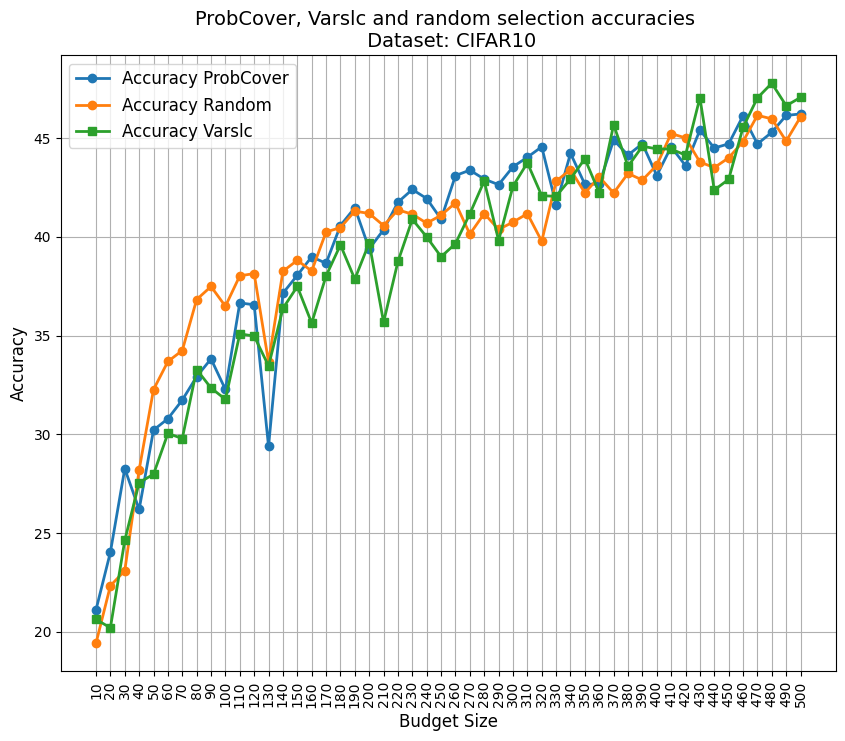

In [ ]:
final_results_cifar10 = compare_probcover_alg(budget_sizes=budget_sizes, delta=cifar10_optimal_delta, divide_factor=CIFAR10_DIVIDE_FACTOR, num_classes=CIFAR10_NUM_CLASSES, dataset_features=cifar10_features, n_clusters = 150, run_varslc=True)
plot_accuracy(final_results_cifar10, "CIFAR10")

In this plot, the x-axis is the budget size and the y-axis is the accuracy. We compare the performence of the three models. We can see that for smaller budget sizes, the ProbCover algorithm achieves higher accuracy. As the budget increases, the Varslc algorithm starts to perform competitively, sometimes matching or even surpassing the accuracy of both ProbCover and the random selection method.

In the table above, we can see the accuracy of the random selection (acc_rand) vs the accuracy of the probCover algorithm (acc_prob), Var Selection algorithm (acc_varslc) the budget size (budget), and the indices they chose (active_set) for the probCover algorithm, the  (random_set) for the random selection.

### CIFAR100

In [ ]:
delta = 0.75
budget_sizes = np.arange(100, 2100, 100)

In [ ]:
final_results_cifar100 = compare_probcover_alg(budget_sizes = budget_sizes, delta = cifar100_optimal_delta, divide_factor=CIFAR100_DIVIDE_FACTOR, num_classes=CIFAR100_NUM_CLASSES, dataset_features=cifar100_feaures, n_clusters=500, run_varslc=True)

Start constructing graph using delta=0.75 (cosine similarity)


/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/2282487937.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cuda_feats = torch.tensor(self.rel_features)


Finished constructing graph using delta=0.75 (cosine similarity)
Graph contains 34079550 edges.
Start constructing graph using delta=0.75 (cosine similarity)
Finished constructing graph using delta=0.75 (cosine similarity)
Graph contains 34079550 edges.

Graph DataFrame:
   x   y         d
0  0   0  1.000000
1  0  24  0.857788
2  0  26  0.779456
3  0  30  0.801633
4  0  57  0.823591
Start selecting 2000 samples.
Iteration 0.	Graph edges: 34079550.	Max degree: 5411.	Coverage: 0.000
Iteration 1.	Graph edges: 21453159.	Max degree: 2788.	Coverage: 0.108
Iteration 2.	Graph edges: 18090116.	Max degree: 2104.	Coverage: 0.164
Iteration 3.	Graph edges: 15847629.	Max degree: 1866.	Coverage: 0.206
Iteration 4.	Graph edges: 13966547.	Max degree: 1408.	Coverage: 0.243
Iteration 5.	Graph edges: 13043084.	Max degree: 1305.	Coverage: 0.272
Iteration 6.	Graph edges: 12094635.	Max degree: 1295.	Coverage: 0.298
Iteration 7.	Graph edges: 11082891.	Max degree: 1079.	Coverage: 0.324
Iteration 8.	Graph edges

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 1/10, Loss: 4.618201017379761
Epoch 2/10, Loss: 4.3964362144470215
Epoch 3/10, Loss: 4.156861782073975
Epoch 4/10, Loss: 4.0066216588020325
Epoch 5/10, Loss: 3.6339860558509827
Epoch 6/10, Loss: 3.2449209094047546
Epoch 7/10, Loss: 3.2568289637565613
Epoch 8/10, Loss: 2.8383597135543823
Epoch 9/10, Loss: 2.597256124019623
Epoch 10/10, Loss: 2.508033573627472
Accuracy: 5.58%
Epoch 1/10, Loss: 4.604735374450684
Epoch 2/10, Loss: 4.263271629810333
Epoch 3/10, Loss: 4.0945292711257935
Epoch 4/10, Loss: 3.690192759037018
Epoch 5/10, Loss: 3.690849721431732
Epoch 6/10, Loss: 3.3929022550582886
Epoch 7/10, Loss: 2.987047016620636
Epoch 8/10, Loss: 2.751012146472931
Epoch 9/10, Loss: 2.5760555267333984
Epoch 10/10, Loss: 2.0882811844348907
Accuracy: 3.05%
Epoch 1/10, Loss: 4.57555091381073
Epoch 2/10, Loss: 4.287973999977112
Epoch 3/10, Loss: 4.018193483352661
Epoch 4/10, Loss: 3.6558932662010193
Epoch 5/10, Loss: 3.2336146235466003
Epoch 6/10, Loss: 2.9890474677085876
Epoch 7/10, Loss: 

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/4218523931.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, row_df], ignore_index=True)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires

Accuracy: 7.59%
Epoch 1/10, Loss: 4.596758297511509
Epoch 2/10, Loss: 4.309286594390869
Epoch 3/10, Loss: 4.039975813456944
Epoch 4/10, Loss: 3.7851501192365373
Epoch 5/10, Loss: 3.466550588607788
Epoch 6/10, Loss: 3.043062618800572
Epoch 7/10, Loss: 2.7319815499441966
Epoch 8/10, Loss: 2.395213944571359
Epoch 9/10, Loss: 2.061574782643999
Epoch 10/10, Loss: 1.725866402898516
Accuracy: 7.01%
Epoch 1/10, Loss: 4.619854177747454
Epoch 2/10, Loss: 4.350688525608608
Epoch 3/10, Loss: 4.137492656707764
Epoch 4/10, Loss: 3.828561646597726
Epoch 5/10, Loss: 3.401294708251953
Epoch 6/10, Loss: 3.103360686983381
Epoch 7/10, Loss: 2.8757499626704623
Epoch 8/10, Loss: 2.4395885126931325
Epoch 9/10, Loss: 2.104497858456203
Epoch 10/10, Loss: 1.8659459011895316
Accuracy: 7.07%
Epoch 1/10, Loss: 4.5986169338226315
Epoch 2/10, Loss: 4.309607458114624
Epoch 3/10, Loss: 3.981085419654846
Epoch 4/10, Loss: 3.5434980154037476
Epoch 5/10, Loss: 3.1598806858062742
Epoch 6/10, Loss: 2.760945200920105
Epoch 

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Accuracy: 9.40%
Epoch 1/10, Loss: 4.627807569503784
Epoch 2/10, Loss: 4.340036678314209
Epoch 3/10, Loss: 4.04578423500061
Epoch 4/10, Loss: 3.7020705223083494
Epoch 5/10, Loss: 3.323241353034973
Epoch 6/10, Loss: 2.927126336097717
Epoch 7/10, Loss: 2.487821400165558
Epoch 8/10, Loss: 2.144281768798828
Epoch 9/10, Loss: 1.939980697631836
Epoch 10/10, Loss: 1.6402576446533204
Accuracy: 8.58%
Epoch 1/10, Loss: 4.600039339065551
Epoch 2/10, Loss: 4.3093156814575195
Epoch 3/10, Loss: 3.954942774772644
Epoch 4/10, Loss: 3.4856935024261473
Epoch 5/10, Loss: 3.055165147781372
Epoch 6/10, Loss: 2.590906322002411
Epoch 7/10, Loss: 2.2177805423736574
Epoch 8/10, Loss: 1.907827115058899
Epoch 9/10, Loss: 1.615912389755249
Epoch 10/10, Loss: 1.3557608723640442
Accuracy: 9.08%
Epoch 1/10, Loss: 4.5880321722764235
Epoch 2/10, Loss: 4.264246555475088
Epoch 3/10, Loss: 3.8656899012052097
Epoch 4/10, Loss: 3.434585846387423
Epoch 5/10, Loss: 3.000783975307758
Epoch 6/10, Loss: 2.5914543592012844
Epoch 

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 8/10, Loss: 1.9219025648557222
Epoch 9/10, Loss: 1.6682480573654175
Epoch 10/10, Loss: 1.3658805260291467
Accuracy: 10.53%
Epoch 1/10, Loss: 4.603068241706262
Epoch 2/10, Loss: 4.362606415381799
Epoch 3/10, Loss: 4.053209176430335
Epoch 4/10, Loss: 3.7205788172208347
Epoch 5/10, Loss: 3.3304664538456845
Epoch 6/10, Loss: 2.9592762543604922
Epoch 7/10, Loss: 2.512250019953801
Epoch 8/10, Loss: 2.231454766713656
Epoch 9/10, Loss: 1.8702936630982618
Epoch 10/10, Loss: 1.6110174105717585
Accuracy: 8.94%
Epoch 1/10, Loss: 4.591361669393686
Epoch 2/10, Loss: 4.299915643838736
Epoch 3/10, Loss: 3.900881052017212
Epoch 4/10, Loss: 3.4511177723224344
Epoch 5/10, Loss: 2.9957938194274902
Epoch 6/10, Loss: 2.5070757499107947
Epoch 7/10, Loss: 2.152160406112671
Epoch 8/10, Loss: 1.8437204544360821
Epoch 9/10, Loss: 1.5672883070432222
Epoch 10/10, Loss: 1.3369550888354962
Accuracy: 10.61%
Epoch 1/10, Loss: 4.596483111381531
Epoch 2/10, Loss: 4.2639095187187195
Epoch 3/10, Loss: 3.830097198486

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 7/10, Loss: 2.349698707461357
Epoch 8/10, Loss: 2.0331431329250336
Epoch 9/10, Loss: 1.7543805688619614
Epoch 10/10, Loss: 1.5429653823375702
Accuracy: 11.28%
Epoch 1/10, Loss: 4.609943598508835
Epoch 2/10, Loss: 4.325747728347778
Epoch 3/10, Loss: 3.992840439081192
Epoch 4/10, Loss: 3.572881266474724
Epoch 5/10, Loss: 3.180764138698578
Epoch 6/10, Loss: 2.8393445163965225
Epoch 7/10, Loss: 2.45386703312397
Epoch 8/10, Loss: 2.170379303395748
Epoch 9/10, Loss: 1.864461712539196
Epoch 10/10, Loss: 1.625347726047039
Accuracy: 10.59%
Epoch 1/10, Loss: 4.586893379688263
Epoch 2/10, Loss: 4.238736644387245
Epoch 3/10, Loss: 3.800163134932518
Epoch 4/10, Loss: 3.3123659491539
Epoch 5/10, Loss: 2.856385827064514
Epoch 6/10, Loss: 2.4382331520318985
Epoch 7/10, Loss: 2.098781704902649
Epoch 8/10, Loss: 1.801605187356472
Epoch 9/10, Loss: 1.5644007325172424
Epoch 10/10, Loss: 1.3326799422502518
Accuracy: 11.53%
Epoch 1/10, Loss: 4.581562845330489
Epoch 2/10, Loss: 4.2456354342008895
Epoch

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 5/10, Loss: 2.983278374922903
Epoch 6/10, Loss: 2.626084465729563
Epoch 7/10, Loss: 2.3170361267892936
Epoch 8/10, Loss: 2.0203946640616968
Epoch 9/10, Loss: 1.828864574432373
Epoch 10/10, Loss: 1.5541448844106573
Accuracy: 11.14%
Epoch 1/10, Loss: 4.599451366223787
Epoch 2/10, Loss: 4.328797340393066
Epoch 3/10, Loss: 3.9610554920999625
Epoch 4/10, Loss: 3.5645532984482613
Epoch 5/10, Loss: 3.1876575695840934
Epoch 6/10, Loss: 2.854006993143182
Epoch 7/10, Loss: 2.5149238987972864
Epoch 8/10, Loss: 2.213108928580033
Epoch 9/10, Loss: 1.9609360820368718
Epoch 10/10, Loss: 1.6529843932703923
Accuracy: 12.16%
Epoch 1/10, Loss: 4.5880944603367855
Epoch 2/10, Loss: 4.2549879801900765
Epoch 3/10, Loss: 3.847274014824315
Epoch 4/10, Loss: 3.3633694146808826
Epoch 5/10, Loss: 2.922380848934776
Epoch 6/10, Loss: 2.565752707029644
Epoch 7/10, Loss: 2.3070914557105615
Epoch 8/10, Loss: 1.9833553339305676
Epoch 9/10, Loss: 1.7108018272801448
Epoch 10/10, Loss: 1.4958447280683016
Accuracy: 1

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 5/10, Loss: 2.845468206839128
Epoch 6/10, Loss: 2.526094978505915
Epoch 7/10, Loss: 2.238913357257843
Epoch 8/10, Loss: 1.9290953115983442
Epoch 9/10, Loss: 1.7127099470658735
Epoch 10/10, Loss: 1.4462493387135593
Accuracy: 12.24%
Epoch 1/10, Loss: 4.584001346067949
Epoch 2/10, Loss: 4.2562457431446425
Epoch 3/10, Loss: 3.8489445447921753
Epoch 4/10, Loss: 3.42317474972118
Epoch 5/10, Loss: 3.0814311612736094
Epoch 6/10, Loss: 2.7468328150835903
Epoch 7/10, Loss: 2.4076460979201575
Epoch 8/10, Loss: 2.1438349322839216
Epoch 9/10, Loss: 1.8970809307965366
Epoch 10/10, Loss: 1.6554923165928235
Accuracy: 12.30%
Epoch 1/10, Loss: 4.584829027002508
Epoch 2/10, Loss: 4.25192217393355
Epoch 3/10, Loss: 3.7821743813428013
Epoch 4/10, Loss: 3.2845640832727607
Epoch 5/10, Loss: 2.8845019232143057
Epoch 6/10, Loss: 2.549398655241186
Epoch 7/10, Loss: 2.2251438335938887
Epoch 8/10, Loss: 1.9748652252283962
Epoch 9/10, Loss: 1.7549452239816838
Epoch 10/10, Loss: 1.5061399665745823
Accuracy: 1

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 4/10, Loss: 3.2372439765930174
Epoch 5/10, Loss: 2.884791126251221
Epoch 6/10, Loss: 2.5462824726104736
Epoch 7/10, Loss: 2.2927798080444335
Epoch 8/10, Loss: 2.072052059173584
Epoch 9/10, Loss: 1.803973536491394
Epoch 10/10, Loss: 1.5977360534667968
Accuracy: 14.09%
Epoch 1/10, Loss: 4.5842184066772464
Epoch 2/10, Loss: 4.275746669769287
Epoch 3/10, Loss: 3.8726588535308837
Epoch 4/10, Loss: 3.4379047679901125
Epoch 5/10, Loss: 3.0569538974761965
Epoch 6/10, Loss: 2.717244930267334
Epoch 7/10, Loss: 2.4481458854675293
Epoch 8/10, Loss: 2.184748339653015
Epoch 9/10, Loss: 1.8821533107757569
Epoch 10/10, Loss: 1.6438423156738282
Accuracy: 13.88%
Epoch 1/10, Loss: 4.570649738311768
Epoch 2/10, Loss: 4.168610372543335
Epoch 3/10, Loss: 3.616258668899536
Epoch 4/10, Loss: 3.137670469284058
Epoch 5/10, Loss: 2.7550724220275877
Epoch 6/10, Loss: 2.426139135360718
Epoch 7/10, Loss: 2.1177933406829834
Epoch 8/10, Loss: 1.9226101970672607
Epoch 9/10, Loss: 1.6770247077941896
Epoch 10/10, 

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 4/10, Loss: 3.2310160110736716
Epoch 5/10, Loss: 2.8672922972975106
Epoch 6/10, Loss: 2.606903651664997
Epoch 7/10, Loss: 2.3253996290009598
Epoch 8/10, Loss: 2.0985656154566796
Epoch 9/10, Loss: 1.8832031858378444
Epoch 10/10, Loss: 1.6441495706295144
Accuracy: 14.41%
Epoch 1/10, Loss: 4.583028891990924
Epoch 2/10, Loss: 4.177119148188624
Epoch 3/10, Loss: 3.782963991165161
Epoch 4/10, Loss: 3.3933056962901147
Epoch 5/10, Loss: 2.9956528482765985
Epoch 6/10, Loss: 2.7189193676257957
Epoch 7/10, Loss: 2.514613928466008
Epoch 8/10, Loss: 2.256371366566625
Epoch 9/10, Loss: 2.040978123401773
Epoch 10/10, Loss: 1.8514462298360364
Accuracy: 13.45%
Epoch 1/10, Loss: 4.562921885786386
Epoch 2/10, Loss: 4.164610410558766
Epoch 3/10, Loss: 3.6326522251655318
Epoch 4/10, Loss: 3.2602099632394723
Epoch 5/10, Loss: 2.9326813549830995
Epoch 6/10, Loss: 2.639931818534588
Epoch 7/10, Loss: 2.4308558003655794
Epoch 8/10, Loss: 2.13818634378499
Epoch 9/10, Loss: 1.953521880610236
Epoch 10/10, Lo

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 4/10, Loss: 3.175645463168621
Epoch 5/10, Loss: 2.8481600061059
Epoch 6/10, Loss: 2.5874758511781693
Epoch 7/10, Loss: 2.3261671625077724
Epoch 8/10, Loss: 2.0542168840765953
Epoch 9/10, Loss: 1.8589973114430904
Epoch 10/10, Loss: 1.6165990754961967
Accuracy: 13.42%
Epoch 1/10, Loss: 4.577806770801544
Epoch 2/10, Loss: 4.192739352583885
Epoch 3/10, Loss: 3.73741502314806
Epoch 4/10, Loss: 3.327798828482628
Epoch 5/10, Loss: 2.991665631532669
Epoch 6/10, Loss: 2.708546817302704
Epoch 7/10, Loss: 2.45965314283967
Epoch 8/10, Loss: 2.2086430303752422
Epoch 9/10, Loss: 1.9557801447808743
Epoch 10/10, Loss: 1.7487068586051464
Accuracy: 14.45%
Epoch 1/10, Loss: 4.573082432150841
Epoch 2/10, Loss: 4.168386526405811
Epoch 3/10, Loss: 3.6362931728363037
Epoch 4/10, Loss: 3.26497058570385
Epoch 5/10, Loss: 2.923840656876564
Epoch 6/10, Loss: 2.588171385228634
Epoch 7/10, Loss: 2.403184946626425
Epoch 8/10, Loss: 2.1663424968719482
Epoch 9/10, Loss: 1.9016596786677837
Epoch 10/10, Loss: 1.7

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 3/10, Loss: 3.4958664281027656
Epoch 4/10, Loss: 3.131991481781006
Epoch 5/10, Loss: 2.797059713091169
Epoch 6/10, Loss: 2.528603526524135
Epoch 7/10, Loss: 2.2910071883882797
Epoch 8/10, Loss: 2.102707930973598
Epoch 9/10, Loss: 1.8381836788994925
Epoch 10/10, Loss: 1.6618658031736102
Accuracy: 13.23%
Epoch 1/10, Loss: 4.555686841692244
Epoch 2/10, Loss: 4.159002774102348
Epoch 3/10, Loss: 3.678591067450387
Epoch 4/10, Loss: 3.3087546144212996
Epoch 5/10, Loss: 2.9604985509599957
Epoch 6/10, Loss: 2.658979334150042
Epoch 7/10, Loss: 2.4427025386265346
Epoch 8/10, Loss: 2.1936490671975273
Epoch 9/10, Loss: 1.9275969982147216
Epoch 10/10, Loss: 1.7302576439721244
Accuracy: 15.62%
Epoch 1/10, Loss: 4.546183259146554
Epoch 2/10, Loss: 4.050120312826974
Epoch 3/10, Loss: 3.5340806416102817
Epoch 4/10, Loss: 3.136970165797642
Epoch 5/10, Loss: 2.7826552391052246
Epoch 6/10, Loss: 2.5135260105133055
Epoch 7/10, Loss: 2.285873760495867
Epoch 8/10, Loss: 2.0494528021131244
Epoch 9/10, Lo

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 4/10, Loss: 2.941325589230186
Epoch 5/10, Loss: 2.6283397611818815
Epoch 6/10, Loss: 2.3601883524342586
Epoch 7/10, Loss: 2.113691979332974
Epoch 8/10, Loss: 1.8710629155761318
Epoch 9/10, Loss: 1.6979098916053772
Epoch 10/10, Loss: 1.4660295248031616
Accuracy: 15.29%
Epoch 1/10, Loss: 4.54799401132684
Epoch 2/10, Loss: 4.089744705902903
Epoch 3/10, Loss: 3.614136764877721
Epoch 4/10, Loss: 3.21931202788102
Epoch 5/10, Loss: 2.907206240453218
Epoch 6/10, Loss: 2.614754739560579
Epoch 7/10, Loss: 2.386025607585907
Epoch 8/10, Loss: 2.1648135467579492
Epoch 9/10, Loss: 1.9700921303347538
Epoch 10/10, Loss: 1.7555713120259737
Accuracy: 15.73%
Epoch 1/10, Loss: 4.5221441294017595
Epoch 2/10, Loss: 3.969549718656038
Epoch 3/10, Loss: 3.484544590899819
Epoch 4/10, Loss: 3.111767655924747
Epoch 5/10, Loss: 2.812793543464259
Epoch 6/10, Loss: 2.5348498821258545
Epoch 7/10, Loss: 2.28886835512362
Epoch 8/10, Loss: 2.1004681618590104
Epoch 9/10, Loss: 1.9026942284483659
Epoch 10/10, Loss: 

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 3/10, Loss: 3.116729579320768
Epoch 4/10, Loss: 2.7271421886071927
Epoch 5/10, Loss: 2.430225197861834
Epoch 6/10, Loss: 2.1622996795468215
Epoch 7/10, Loss: 1.9372370126770764
Epoch 8/10, Loss: 1.7136821281619188
Epoch 9/10, Loss: 1.4927737552945206
Epoch 10/10, Loss: 1.3283693499681426
Accuracy: 14.94%
Epoch 1/10, Loss: 4.568912192088802
Epoch 2/10, Loss: 4.14395905704033
Epoch 3/10, Loss: 3.6304922685390566
Epoch 4/10, Loss: 3.2513175475888136
Epoch 5/10, Loss: 2.937759719243864
Epoch 6/10, Loss: 2.648453927621609
Epoch 7/10, Loss: 2.428107564042254
Epoch 8/10, Loss: 2.193421424888983
Epoch 9/10, Loss: 1.9884652742525426
Epoch 10/10, Loss: 1.7904385299217411
Accuracy: 15.34%
Epoch 1/10, Loss: 4.52659189410326
Epoch 2/10, Loss: 3.975354962232636
Epoch 3/10, Loss: 3.428083582622249
Epoch 4/10, Loss: 3.0606338454455866
Epoch 5/10, Loss: 2.7375247420334237
Epoch 6/10, Loss: 2.5026498015333964
Epoch 7/10, Loss: 2.2325657053691583
Epoch 8/10, Loss: 2.0227469671063307
Epoch 9/10, Los

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 3/10, Loss: 2.833556435324929
Epoch 4/10, Loss: 2.5119092789563267
Epoch 5/10, Loss: 2.2550480419939216
Epoch 6/10, Loss: 1.9952111840248108
Epoch 7/10, Loss: 1.7888015671209856
Epoch 8/10, Loss: 1.5450775596228512
Epoch 9/10, Loss: 1.359658268364993
Epoch 10/10, Loss: 1.1469854224811902
Accuracy: 14.27%
Epoch 1/10, Loss: 4.529804544015364
Epoch 2/10, Loss: 3.9992138635028494
Epoch 3/10, Loss: 3.519092857837677
Epoch 4/10, Loss: 3.182034069841558
Epoch 5/10, Loss: 2.9060980298302392
Epoch 6/10, Loss: 2.671740705316717
Epoch 7/10, Loss: 2.421655161814256
Epoch 8/10, Loss: 2.2057974203066393
Epoch 9/10, Loss: 2.0158870816230774
Epoch 10/10, Loss: 1.8005413602698932
Accuracy: 16.98%
Epoch 1/10, Loss: 4.5150393139232285
Epoch 2/10, Loss: 3.96623295545578
Epoch 3/10, Loss: 3.448932105844671
Epoch 4/10, Loss: 3.103122841228138
Epoch 5/10, Loss: 2.8052558953111824
Epoch 6/10, Loss: 2.5454379970377143
Epoch 7/10, Loss: 2.316147641702132
Epoch 8/10, Loss: 2.1025720130313528
Epoch 9/10, Lo

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 3/10, Loss: 2.6798172732616994
Epoch 4/10, Loss: 2.372719612527401
Epoch 5/10, Loss: 2.1199577057615238
Epoch 6/10, Loss: 1.917040523062361
Epoch 7/10, Loss: 1.7249404420243932
Epoch 8/10, Loss: 1.5000049040672627
Epoch 9/10, Loss: 1.3289379249227808
Epoch 10/10, Loss: 1.1465030807129881
Accuracy: 13.89%
Epoch 1/10, Loss: 4.528606414794922
Epoch 2/10, Loss: 4.0219680704969045
Epoch 3/10, Loss: 3.5359455220242766
Epoch 4/10, Loss: 3.1681773764021854
Epoch 5/10, Loss: 2.894592132974178
Epoch 6/10, Loss: 2.663097970029141
Epoch 7/10, Loss: 2.419123441615003
Epoch 8/10, Loss: 2.2255482978009162
Epoch 9/10, Loss: 1.9942534832244223
Epoch 10/10, Loss: 1.8026219758581608
Accuracy: 16.26%
Epoch 1/10, Loss: 4.491232131389862
Epoch 2/10, Loss: 3.8852112242516053
Epoch 3/10, Loss: 3.4008075176401342
Epoch 4/10, Loss: 3.054915372361528
Epoch 5/10, Loss: 2.7866943897084986
Epoch 6/10, Loss: 2.529049612106161
Epoch 7/10, Loss: 2.2911522160185145
Epoch 8/10, Loss: 2.1060100134382855
Epoch 9/10,

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 3/10, Loss: 2.532260854244232
Epoch 4/10, Loss: 2.2534954023361204
Epoch 5/10, Loss: 1.9991108465194702
Epoch 6/10, Loss: 1.7967647457122802
Epoch 7/10, Loss: 1.6069296765327454
Epoch 8/10, Loss: 1.4227259850502014
Epoch 9/10, Loss: 1.2374734139442445
Epoch 10/10, Loss: 1.0666184675693513
Accuracy: 14.31%
Epoch 1/10, Loss: 4.518497343063355
Epoch 2/10, Loss: 3.9718229246139525
Epoch 3/10, Loss: 3.5030150604248047
Epoch 4/10, Loss: 3.1938578605651857
Epoch 5/10, Loss: 2.9223664236068725
Epoch 6/10, Loss: 2.6569536685943604
Epoch 7/10, Loss: 2.418034520149231
Epoch 8/10, Loss: 2.223141415119171
Epoch 9/10, Loss: 2.037168309688568
Epoch 10/10, Loss: 1.853167908191681
Accuracy: 17.56%
Epoch 1/10, Loss: 4.467138166427612
Epoch 2/10, Loss: 3.7972888374328613
Epoch 3/10, Loss: 3.3247741746902464
Epoch 4/10, Loss: 2.9622193145751954
Epoch 5/10, Loss: 2.7163919401168823
Epoch 6/10, Loss: 2.471661477088928
Epoch 7/10, Loss: 2.237055313587189
Epoch 8/10, Loss: 2.0332546401023865
Epoch 9/10,

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 3/10, Loss: 2.401837240766596
Epoch 4/10, Loss: 2.1770878853621305
Epoch 5/10, Loss: 1.965872793285935
Epoch 6/10, Loss: 1.7400012777911291
Epoch 7/10, Loss: 1.5829302778950445
Epoch 8/10, Loss: 1.3955580548003867
Epoch 9/10, Loss: 1.2753927067474082
Epoch 10/10, Loss: 1.0758930853119604
Accuracy: 13.70%
Epoch 1/10, Loss: 4.510877988956593
Epoch 2/10, Loss: 3.946812868118286
Epoch 3/10, Loss: 3.4921248930471913
Epoch 4/10, Loss: 3.1326118310292563
Epoch 5/10, Loss: 2.8940536357738353
Epoch 6/10, Loss: 2.6235969773045293
Epoch 7/10, Loss: 2.4217503468195596
Epoch 8/10, Loss: 2.231874741889812
Epoch 9/10, Loss: 2.0364337342756764
Epoch 10/10, Loss: 1.8761185186880607
Accuracy: 17.85%
Epoch 1/10, Loss: 4.441572701489484
Epoch 2/10, Loss: 3.7776472833421497
Epoch 3/10, Loss: 3.326663198294463
Epoch 4/10, Loss: 2.9921479799129345
Epoch 5/10, Loss: 2.7322510480880737
Epoch 6/10, Loss: 2.497001131375631
Epoch 7/10, Loss: 2.2624047663476734
Epoch 8/10, Loss: 2.0820375040725425
Epoch 9/10

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 2/10, Loss: 2.5940143246399727
Epoch 3/10, Loss: 2.311811376036259
Epoch 4/10, Loss: 2.0389307005363597
Epoch 5/10, Loss: 1.8280240401887058
Epoch 6/10, Loss: 1.609308589968765
Epoch 7/10, Loss: 1.4708419661772878
Epoch 8/10, Loss: 1.29103247010917
Epoch 9/10, Loss: 1.1255443033419157
Epoch 10/10, Loss: 0.9931289846437019
Accuracy: 14.09%
Epoch 1/10, Loss: 4.5074436204475266
Epoch 2/10, Loss: 3.9320399468405203
Epoch 3/10, Loss: 3.4704804504126834
Epoch 4/10, Loss: 3.1421865245752167
Epoch 5/10, Loss: 2.8397153469554164
Epoch 6/10, Loss: 2.6127305323617502
Epoch 7/10, Loss: 2.3805189341829536
Epoch 8/10, Loss: 2.1921241743522777
Epoch 9/10, Loss: 1.9995693972236233
Epoch 10/10, Loss: 1.7783420566926922
Accuracy: 18.01%
Epoch 1/10, Loss: 4.429668116987798
Epoch 2/10, Loss: 3.77706183466995
Epoch 3/10, Loss: 3.314986412985283
Epoch 4/10, Loss: 2.9820179562819633
Epoch 5/10, Loss: 2.7177429533841315
Epoch 6/10, Loss: 2.5056805066895067
Epoch 7/10, Loss: 2.2924176684597084
Epoch 8/10

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 2/10, Loss: 2.458277527491252
Epoch 3/10, Loss: 2.1854206562042235
Epoch 4/10, Loss: 1.9203685919443767
Epoch 5/10, Loss: 1.7295965751012166
Epoch 6/10, Loss: 1.5465408782164256
Epoch 7/10, Loss: 1.3816688964764277
Epoch 8/10, Loss: 1.240682198603948
Epoch 9/10, Loss: 1.0733475695053736
Epoch 10/10, Loss: 0.9250563147167364
Accuracy: 13.25%
Epoch 1/10, Loss: 4.500991638501485
Epoch 2/10, Loss: 3.887792642911275
Epoch 3/10, Loss: 3.416643269856771
Epoch 4/10, Loss: 3.111898652712504
Epoch 5/10, Loss: 2.8695857604344686
Epoch 6/10, Loss: 2.637932864824931
Epoch 7/10, Loss: 2.4239785254001616
Epoch 8/10, Loss: 2.2110199908415478
Epoch 9/10, Loss: 2.025037600596746
Epoch 10/10, Loss: 1.8294212341308593
Accuracy: 18.08%
Epoch 1/10, Loss: 4.434679937362671
Epoch 2/10, Loss: 3.748129932085673
Epoch 3/10, Loss: 3.3220693349838255
Epoch 4/10, Loss: 3.0161277214686075
Epoch 5/10, Loss: 2.747334372997284
Epoch 6/10, Loss: 2.532478137811025
Epoch 7/10, Loss: 2.3262981454531353
Epoch 8/10, Lo

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_2723/1687092725.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


Epoch 2/10, Loss: 2.285557550097269
Epoch 3/10, Loss: 2.0258719694046747
Epoch 4/10, Loss: 1.7862050930658977
Epoch 5/10, Loss: 1.5900358113031539
Epoch 6/10, Loss: 1.422179897626241
Epoch 7/10, Loss: 1.278787718878852
Epoch 8/10, Loss: 1.0988070434994168
Epoch 9/10, Loss: 0.9597247649752905
Epoch 10/10, Loss: 0.8225509131711627
Accuracy: 13.48%
Epoch 1/10, Loss: 4.494923644595676
Epoch 2/10, Loss: 3.9244307866172186
Epoch 3/10, Loss: 3.458322385000804
Epoch 4/10, Loss: 3.1307261822715637
Epoch 5/10, Loss: 2.828422096040514
Epoch 6/10, Loss: 2.622792633752974
Epoch 7/10, Loss: 2.4074316989807856
Epoch 8/10, Loss: 2.195073231818184
Epoch 9/10, Loss: 1.9741866967034718
Epoch 10/10, Loss: 1.7741027786618186
Accuracy: 18.44%
Epoch 1/10, Loss: 4.416539264103723
Epoch 2/10, Loss: 3.7472385035620794
Epoch 3/10, Loss: 3.2938901696886336
Epoch 4/10, Loss: 2.9775009950002036
Epoch 5/10, Loss: 2.6825412398292903
Epoch 6/10, Loss: 2.4946998301006498
Epoch 7/10, Loss: 2.2523601168677923
Epoch 8/10,

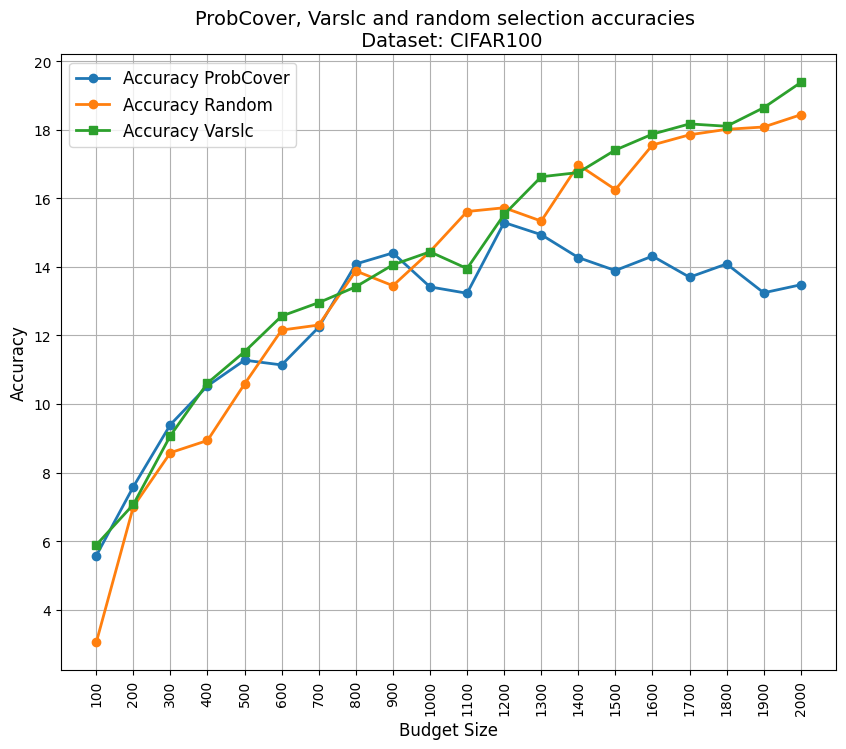

In [ ]:
plot_accuracy(final_results_cifar100, 'CIFAR100')

In this plot, the x-axis is the budget size and the y-axis is the accuracy. We compare the performence of the three models. For smaller budget sizes, the ProbCover algorithm performs well (which aligns with the claim the prob cover performs well in low-budget scenarios). However, as the budget increases, the Varslc algorithm improves and eventually outperforms both ProbCover and the random selection methods. At the largest budget sizes, it achieves the highest accuracy. Since cifar100 consists of 100 classes, the budget size is increased by 100 (to reduce imbalance).









# Summary

We trained a simclr model, and run it on three different datasets. For each dataset, we run the probCover and VarSelection algorithms and compared it to random selection for different budget sizes. The naive implemantation of Varslc (using random selection from each gaussian), seems to perform better than random in all budget regims and it performs better than probcover in the medium-high busgets




In [ ]:
def get_active_set_labels(results_df, divide_factor: int, num_values: int):
    """Gets the labels from teh active sets of prob cover and var selection"""
    prob_labels = results_df['probcover_active_set'].iloc[-1][:num_values] // divide_factor
    varslc_labels = results_df['varslc_active_set'].iloc[-1][:num_values] // divide_factor
    return prob_labels, varslc_labels

In [ ]:
def plot_labels_distribution(stl10_labels, cifar10_labels, cifar100_labels, suptitle):
    fig, ax = plt.subplots(1,3, figsize=(12,4))
    ax[0].hist(stl10_labels, bins=STL10_NUM_CLASSES)
    ax[0].set_title("STL10 Labels")
    ax[0].set_xlabel("Label")
    ax[0].set_ylabel("Frequency")

    ax[1].hist(cifar10_labels, bins=CIFAR10_NUM_CLASSES)
    ax[1].set_title("CIFAR10 Labels")
    ax[1].set_xlabel("Label")

    ax[2].hist(cifar100_labels, bins=CIFAR100_NUM_CLASSES)
    ax[2].set_title("CIFAR100 Labels")
    ax[2].set_xlabel("Label")

    plt.suptitle(suptitle)
    plt.show()


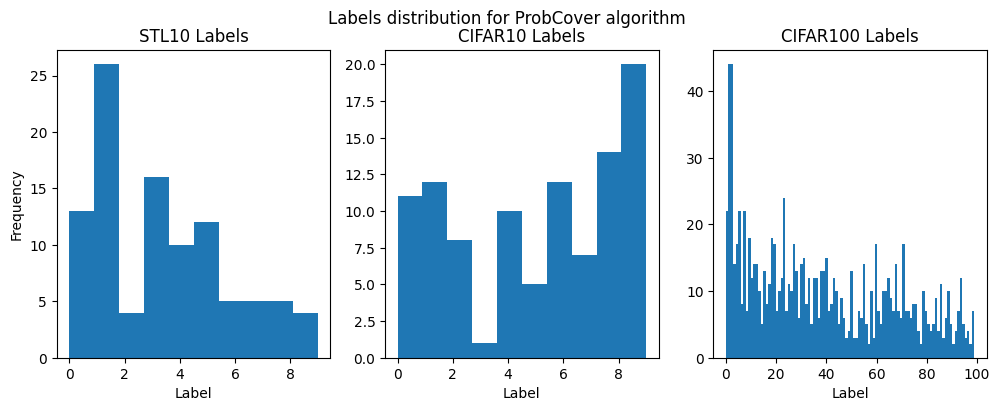

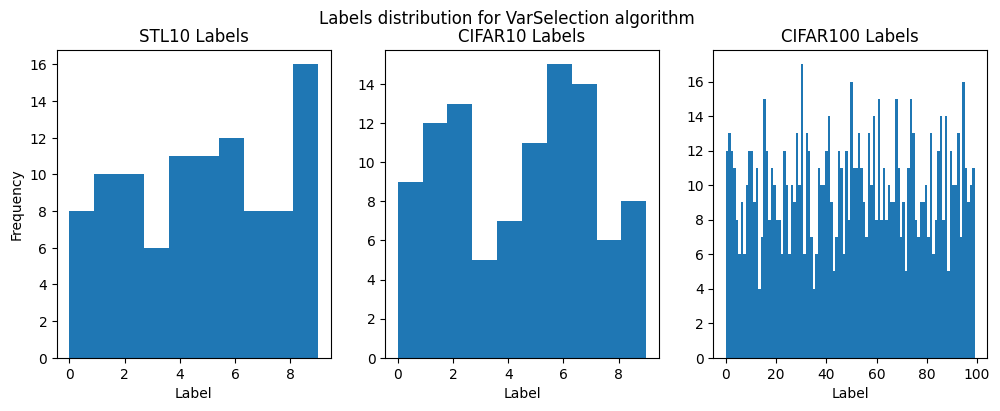

In [ ]:
prob_labels_stl10, varslc_labels_stl10 = get_active_set_labels(final_results_stl10, STL10_DIVIDE_FACTOR, num_values=100)
prob_labels_cifar10, varslc_labels_cifar10 = get_active_set_labels(final_results_cifar10, CIFAR10_DIVIDE_FACTOR, num_values=100)
prob_labels_cifar100, varslc_labels_cifar100 = get_active_set_labels(final_results_cifar100, CIFAR100_DIVIDE_FACTOR, num_values=1000)


plot_labels_distribution(prob_labels_stl10, prob_labels_cifar10, prob_labels_cifar100, "Labels distribution for ProbCover algorithm")
plot_labels_distribution(varslc_labels_stl10, varslc_labels_cifar10, varslc_labels_cifar100, "Labels distribution for VarSelection algorithm" )


Histograms of label distribution over three satasets in both ProbCover and Varslc algorithms, the active set is of size is 100 for STL10 and CIFAR10, and 1000 for CIFAR100. We can see that the label distribution in the probCover algorithm is very imbalanced with noticeable gaps, while the VarSelection algorithm provides a more balanced distribution.